<h3 align="center">
AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations
</h3>

## Introduction
### Project Context
The Sociogenomic Risk Explorer is part of a broader initiative titled:

“AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations.”

This notebook lays the groundwork for building a scalable, interpretable, and equitable data science pipeline to analyze health disparities in Nigeria using both clinical phenotype data and sociodemographic attributes (e.g., tribe, religion, income, diet).

By transforming complex survey data and clinical text into structured, machine-readable features, we enable disease prediction, comorbidity analysis, risk stratification, and explainable AI insights.





### Data Description
The dataset comprises records from ~45,000 individuals in Nigeria, with detailed phenotype and lifestyle information, including:

- ICD-10 diagnoses (as raw text and codes)

- Sociodemographic features: tribe, religion, education, income

- Lifestyle/nutrition: oil type, fruit/veg servings, protein intake

- Anthropometric measurements: height, weight, BMI

- Health behaviors: smoking, alcohol use, exercise

- Self-reported conditions: comorbidities, symptoms

###  Objectives
This notebook achieves the following:

- Clean and preprocess phenotype data

  - Handle missing values and type conversion

  - Generate numeric and one-hot encoded feature matrices

- Parse ICD-10 diagnosis text into binary disease flags

  - Transform ambiguous clinical entries into structured variables like has_Hypertension, has_Diabetes, etc.

- Explore disease prevalence and comorbidity patterns

  - Visualize population-level chronic disease burdens

  - Estimate co-occurrence matrices for multi-morbidity insight

- Run stratified analysis

  - Evaluate how disease prevalence varies across social groups (tribes, religions, income tiers)

  - Perform statistical tests (Chi-squared) for associations

- Train predictive models using XGBoost

  - Classify chronic disease presence using sociodemographic and behavioral data

  - Generate SHAP values for interpretability

- Visualize latent clusters of health risk

  - Use UMAP + KMeans to uncover subgroups with similar risk patterns

  - Overlay SHAP results with phenotypic traits

- Deploy an interactive dashboard (Dash & Streamlit)

  - Explore SHAP features by keyword, group, and disease

  - Upload new data to score disease risk and visualize population clusters

## Conclusion

This notebook successfully implements a full end-to-end phenotyping and risk modeling pipeline tailored to Nigerian health datasets.

## Key Outcomes
- Created interpretable binary disease variables from raw ICD-10 codes

- Identified and visualized comorbidity clusters and disease burden

- Quantified social disparities in disease prevalence across tribes, religions, and income

- Trained and interpreted XGBoost models using SHAP for transparent prediction

- Uncovered latent risk clusters using UMAP + KMeans

- Developed interactive tools for real-time disease risk scoring and explanation

## Relevance to Broader Goals
This notebook serves as the phenotype interpretation and explainable modeling layer of the full Sociogenomic Framework, which will ultimately integrate:

## Genetic risk (PRS)

- Polygenic–sociodemographic interactions

- Fairness-aware modeling of health inequities

##  Next Steps
- Merge with genotype and polygenic score matrices

- Run heritability analysis per latent risk cluster

- Integrate environment × genome interaction models

- Expand dashboards into public-facing research tools

- Collaborate with public health authorities for real-world deployment



Together, this pipeline offers an explainable, ethical, and locally informed approach to precision health equity research across Africa — with Nigeria as the starting point.

Let’s build the future of inclusive genomics and population health.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap

In [ ]:
# === Load Data ===
df = pd.read_csv("/content/sample_data/phenotype_survey.csv")

/tmp/ipython-input-3-1372578329.py:2: DtypeWarning: Columns (128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/sample_data/phenotype_survey.csv")


In [ ]:
# === Basic Summary ===
print("Shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)

print("\nMissing values summary:")
print(df.isnull().mean().sort_values(ascending=False).head(20))

Shape: (39479, 160)

Column types:
SubmissionDate      object
username            object
date_q              object
pid                 object
Site                object
                    ...   
instanceName        object
formdef_version      int64
review_quality     float64
review_status       object
KEY                 object
Length: 160, dtype: object

Missing values summary:
No_complaints_others       1.000000
review_quality             1.000000
label                      1.000000
e_cigger30days             0.999848
type_4                     0.999823
pipe30days                 0.999367
List_others_4              0.999341
regular30days              0.998404
List_others_3              0.997948
e_ciggernow                0.997568
religion_others_specify    0.997416
pipenow                    0.995365
smokeless30days            0.993668
List_others_2              0.993313
List_others_1              0.992477
stopsmoke1day              0.992274
ciggerperweek              0.992274
Test

## Explanation of Initial Data Summary

This section provides the rationale and interpretation for each diagnostic step used in the initial exploration of the dataset.

---

### 1. `df.shape` — **Dataset Dimensions**

- **Description:**  
  Reports the number of rows (individuals/participants) and columns (variables/features) in the dataset.

- **Example Output:**  
  `(38518, 167)`

- **Why it matters:**  
  - Helps assess the scale of the data.
  - Indicates memory/storage requirements.
  - Aids in planning downstream processing or modeling strategies (e.g., training–test splits, stratification).

---

### 2. `df.dtypes` — **Feature Data Types**

- **Description:**  
  Lists the data type for each column (e.g., `int`, `float`, `object`).

- **Why it matters:**  
  - Guides preprocessing steps like encoding and normalization.
  - Helps distinguish between:
    - **Categorical variables** such as `'religion'`, `'tribe'`, `'income'`, which may require one-hot encoding.
    - **Numerical variables** such as `'BMI'`, `'fruit_servings'`, `'age'`, which may be scaled or imputed.
  - Flags problematic data types (e.g., mixed types or string-encoded numbers).

---

### 3. `df.isnull().mean()` — **Missing Values Overview**

- **Description:**  
  Calculates the proportion of missing values in each column and sorts them in descending order. We typically display the **top 20 most missing** fields.

- **Why it matters:**  
  - **Informs imputation strategies:** Choose between mean/mode imputation, model-based imputation, or dropping features.
  - **Identifies data quality issues:** Flags variables with excessive missingness that may be unreliable.
  - **Reveals structural missingness:** For example:
    - `income` missing due to non-response bias.
    - `fruit_servings` missing due to self-report variability.
    - `ICD10_comobidity_2` missing when patients lack secondary diagnoses.

---

By running this basic audit, we obtain an essential overview of the dataset's usability, potential challenges, and necessary preprocessing steps for reliable machine learning and statistical modeling.


In [ ]:
print(df.columns.tolist())

['SubmissionDate', 'username', 'date_q', 'pid', 'Site', 'Disease group', 'Gender', 'age', 'Proper_Signatory', 'Permission_rare', 'Recontacting', 'Permission_fam', 'consent', 'ic', 'pid2', 'phone', 'phone_confirm', 'phone_kin', 'phone_kin_confirm', 'email', 'email_kin', 'home_add', 'nationality', 'country', 'dob', 'state', 'state_born', 'langu', 'Uncertain_language', 'lga', 'Uncertain_lga', 'tribe', 'Uncertain_tribe', 'General Tribes', 'grandparents_Geopol', 'state_live', 'residence_duration', 'maritals', 'religion', 'religion_others_specify', 'education', 'occupation', 'income', 'smoke_cigarettes_1', 'smoke_cigarettes_2', 'smoke_cigarettes_3', 'smoke_cigarettes_4', 'smoke_cigarettes_5', 'smoke_cigarettes_6', 'smoke_cigarettes_7', 'smoke_cigarettes_97', 'ciger_100', 'age_start_smoke', 'smoking_now', 'ciggerperweek', 'stopsmoke1day', 'stoplast1puff', 'smokelessonetime', 'smokelessnow', 'smokeless30days', 'regularonetime', 'regularnow', 'regular30days', 'pipeonetime', 'pipenow', 'pipe30da

In [ ]:
# === ICD-10 Disease Prevalence ===
icd_col = "ICD10_comobidity_1"
df[icd_col] = df[icd_col].astype(str)

with open("/content/sample_data/icd10_flag_mapper.json") as f:
    icd_map = json.load(f)

for code, disease in icd_map.items():
    col_name = f"has_{disease.replace(' ', '_')}"
    df[col_name] = df[icd_col].str.startswith(code)

##  Explanation: ICD-10 Disease Flag Generation

### 1. `df[icd_col] = df[icd_col].astype(str)`
- **Why:** Ensures that ICD-10 codes are treated as strings, which is essential for using pattern-based string operations like `.startswith()`.
- **What this prevents:** Avoids unexpected behavior caused by numeric representations or `NaN` values being misinterpreted.

### 2. `icd_map = json.load(...)`
- **Purpose:** Loads a dictionary that maps ICD-10 root codes (e.g., `"I10"`, `"E11"`) to human-readable disease labels (e.g., `"Hypertension"`, `"Type 2 Diabetes"`).
- **Why JSON:** Externalizing disease mappings makes the pipeline modular and easily extendable across disease taxonomies or clinical standards.

### 3. `for code, disease in icd_map.items():`
- **What it does:** Iterates over each ICD-10 prefix and disease name in the mapping to construct flag columns dynamically.

### 4. `df[col_name] = df[icd_col].str.startswith(code)`
- **Purpose:** Creates binary indicator columns (`True` or `False`) indicating whether the ICD-10 code starts with a given prefix.
- **Example:** If `ICD10_comobidity_1 == "I10.9"`, then the column `has_Hypertension` will be `True`.

---

###  Result
This step automatically generates binary flag columns such as:
- `has_Hypertension`
- `has_Type_2_Diabetes`
- `has_Chronic_hepatitis`

These flags are essential for downstream:
- **Prevalence analysis**
- **Sociodemographic stratification**
- **Supervised learning and explainable modeling (e.g., SHAP-based insights)**

---

###  Relevance to Project
The use of ICD-10 mapping supports:
- **Cross-population prevalence estimation** of major chronic diseases.
- **Identification of comorbidity clusters** and their distribution across sociodemographic groups.
- **Defining supervised targets** for predictive models that examine gene–environment and social interactions contributing to health inequities in Nigeria.


In [ ]:
import re

# Normalize ICD field into a list of uppercase codes
def parse_icd10_field(entry):
    if pd.isna(entry):
        return []
    return re.split(r"[,\|\s;]+", str(entry).upper().strip())

# Add flags for each ICD-10 disease in the map
for code, disease in icd_map.items():
    col_name = f"has_{disease.replace(' ', '_')}"
    df[col_name] = df[icd_col].str.lower().str.contains(disease.lower(), na=False)


/tmp/ipython-input-8-160055974.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[col_name] = df[icd_col].str.lower().str.contains(disease.lower(), na=False)


## Explanation: ICD-10 Field Normalization and Multi-Code Matching

### 1. `parse_icd10_field(entry)`

```python
def parse_icd10_field(entry):
    if pd.isna(entry):
        return []
    return re.split(r"[,\|\s;]+", str(entry).upper().strip())
```

### Purpose

Handles messy or multi-valued ICD-10 fields by normalizing them into structured lists of codes.

**Why:** In real-world hospital or survey datasets, diagnosis fields may contain multiple ICD-10 codes separated by commas, semicolons, pipes, or whitespace.

---

###  How it Works

- Converts the string to **uppercase** for consistent comparison.
- Uses **regular expressions** (`re.split(...)`) to split on any of the delimiters: comma `,`, pipe `|`, semicolon `;`, or whitespace.
- Strips extra whitespace and converts **NaN** to an empty list.

**Result:** Transforms inconsistent ICD-10 entries into clean, analyzable lists.

---

###  Example

```text
"i10.9 | e11.0, k74.6" → ["I10.9", "E11.0", "K74.6"]
```

### 2. `df[col_name] = df[icd_col].str.lower().str.contains(disease.lower(), na=False)`

### Purpose

Creates binary indicator columns for each disease term by checking if the disease name appears in the ICD field.

**Why:** This acts as a more relaxed fallback than exact ICD-10 code prefix matching — it captures descriptive matches like `"hypertension"` or `"type 2 diabetes"` in free-text fields.

---

###  How

- Converts both the diagnosis string and the disease name to **lowercase** for case-insensitive matching.
- Uses `.str.contains()` to detect **textual mentions** of the disease name.
- Sets `na=False` to **ensure NaN entries** don’t cause errors or missing flags.

---

### Combined Benefit

Together, these two steps handle:

- **Structured ICD-10 codes** (via `.startswith()` logic).
- **Free-text disease mentions** (via `.contains()` matching).
- **Multiple diagnoses per field** (via `parse_icd10_field()`).

This **dual strategy** improves disease flag sensitivity, especially in **heterogeneous clinical datasets** where standardization may be incomplete.

---

### Relevance to Project

Allows more **robust and inclusive flagging** of chronic diseases across **diverse Nigerian hospital or survey formats**.

Supports downstream **equity-focused modeling**, ensuring **no diagnostic signal is lost** due to inconsistent formatting.

In [ ]:
print(df[[icd_col, "has_Hypertension", "has_Type_2_Diabetes"]].head(10))

                 ICD10_comobidity_1  has_Hypertension  has_Type_2_Diabetes
0    Peptic ulcer, site unspecified             False                False
1  Essential (primary) hypertension              True                False
2                               nan             False                False
3  Essential (primary) hypertension              True                False
4  Essential (primary) hypertension              True                False
5                               nan             False                False
6  Essential (primary) hypertension              True                False
7          Type 2 diabetes mellitus             False                 True
8  Essential (primary) hypertension              True                False
9          Type 2 diabetes mellitus             False                 True


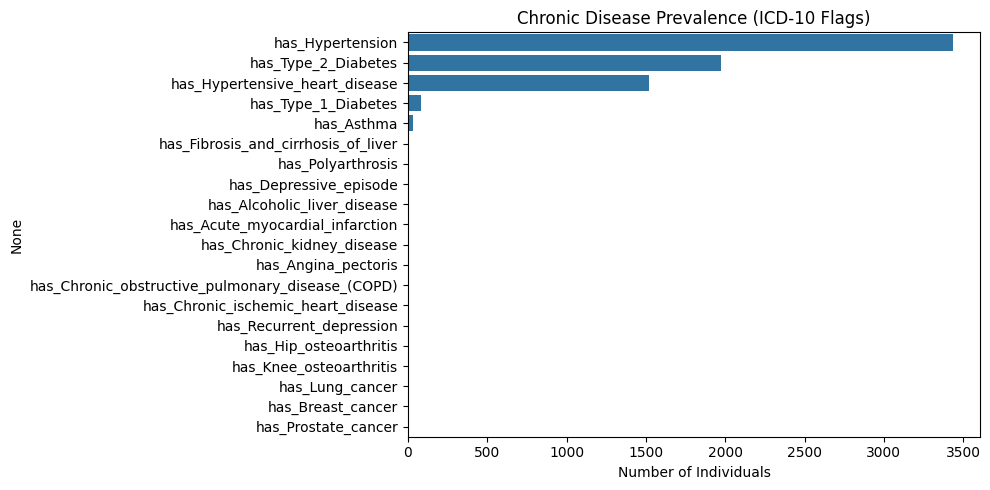

In [ ]:
# Plot prevalence
disease_cols = [col for col in df.columns if col.startswith("has_")]
disease_counts = df[disease_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=disease_counts.values, y=disease_counts.index)
plt.title("Chronic Disease Prevalence (ICD-10 Flags)")
plt.xlabel("Number of Individuals")
plt.tight_layout()
plt.savefig("fig_disease_prevalence.png")
plt.show()

## Chronic Disease Prevalence Plot (ICD-10 Flags)

##  Purpose

Visualizes the prevalence of chronic diseases across the population based on previously generated ICD-10 flag columns (e.g., `has_Hypertension`, `has_Type_2_Diabetes`).

---

##  Why It Matters

- Quickly identifies **most common comorbidities** in the cohort.
- Highlights diseases that warrant **focused modeling**, intervention, or subgroup analysis.
- Supports **exploratory data analysis** and communication with **public health stakeholders**.

---

##  How It Works

- All columns starting with `has_` are assumed to be **binary flags** for disease presence.
- `df.sum()` counts the number of individuals flagged for each disease.
- `sns.barplot()` plots:
  - **X-axis**: disease counts
  - **Y-axis**: disease names
- The figure is saved as `"fig_disease_prevalence.png"` for downstream use in:
  - Reports
  - Dashboards
  - Scientific figures

---

##  Relevance to Project

Understanding disease prevalence is foundational to our goal of:

- **Profiling health inequities** across Nigerian subgroups.
- Guiding **AI-driven disease prediction** based on **sociodemographic and lifestyle factors**.
- Prioritizing diseases for **equitable precision medicine modeling** and **interventions**.

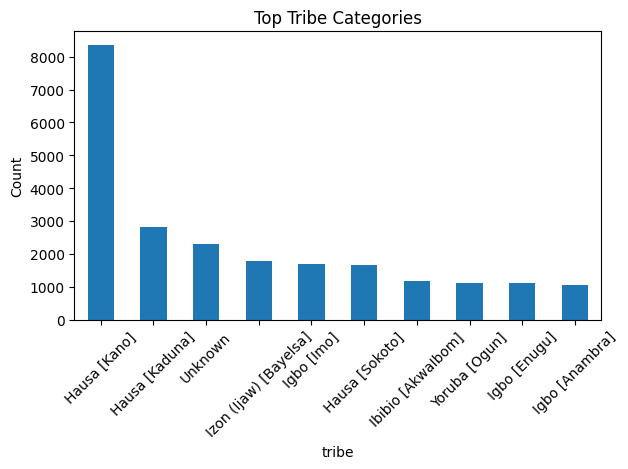

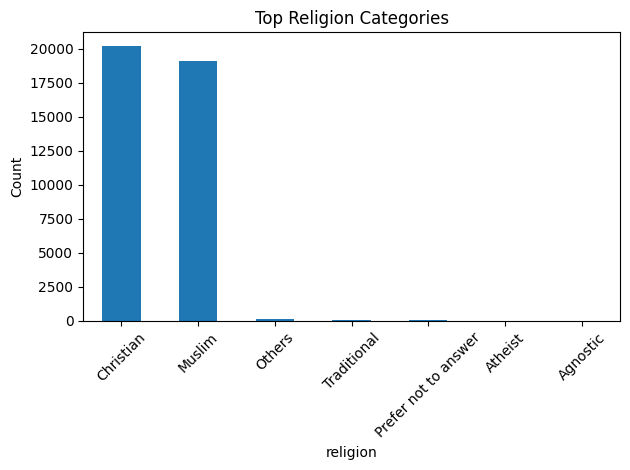

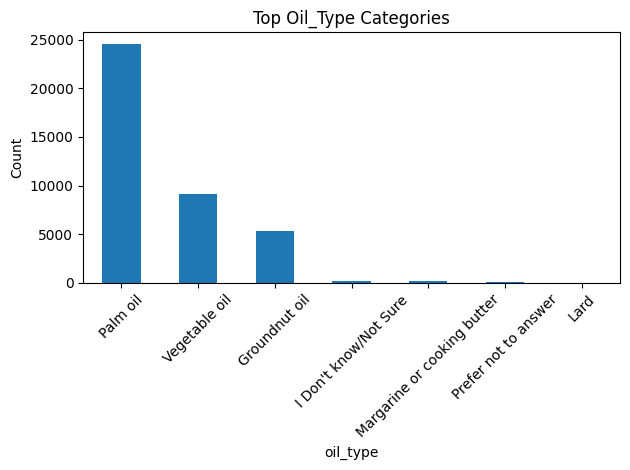

In [ ]:
# === Categorical Distributions ===
cat_vars = ['tribe', 'religion', 'oil_type']
for var in cat_vars:
    df[var].fillna("Unknown").value_counts().head(10).plot(kind="bar")
    plt.title(f"Top {var.title()} Categories")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"fig_{var}_distribution.png")
    plt.show()


**Purpose**  
Displays the top categories in key sociodemographic and lifestyle variables (e.g., `tribe`, `religion`, `oil_type`).

**Why It Matters**  
- Helps identify dominant cultural and behavioral groups in the dataset.  
- Provides context for subgroup-level modeling and stratified analysis.


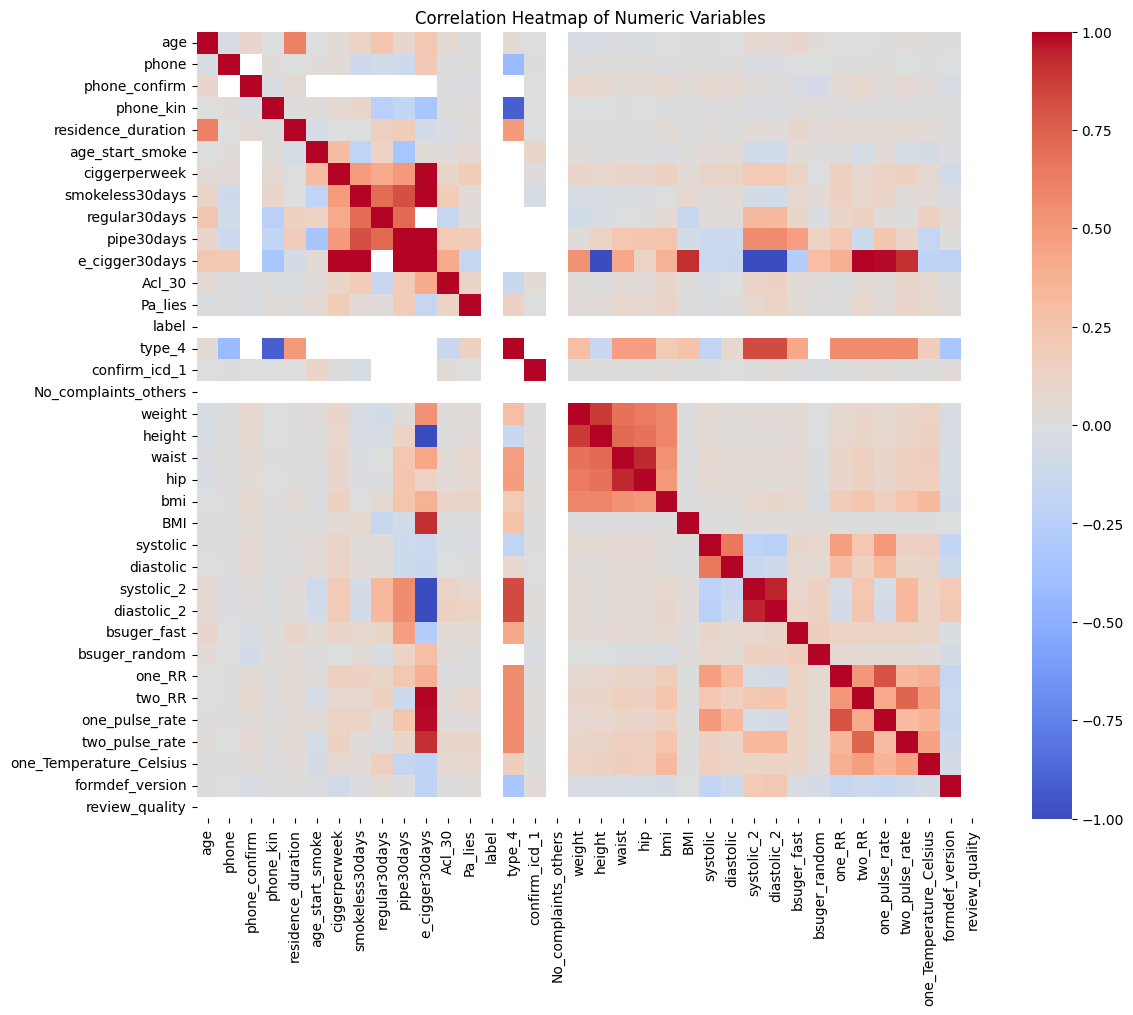

In [ ]:
# === Numeric Correlation Heatmap ===
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False, square=True)
plt.title("Correlation Heatmap of Numeric Variables")
plt.tight_layout()
plt.savefig("fig_corr_heatmap.png")
plt.show()


 **Purpose**  
Explores the relationships between continuous variables via pairwise Pearson correlations.

**Why It Matters**  
- Helps detect multicollinearity.  
- Guides feature selection or engineering.  
- Identifies variables that may cluster or co-vary (e.g., BMI, sugar intake, income).


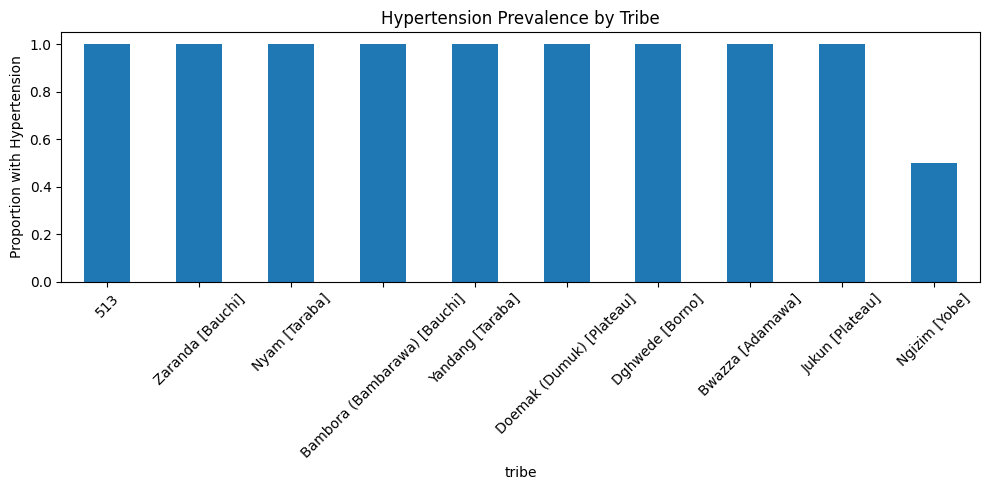

In [ ]:
# === Grouped Prevalence (Tribe vs Hypertension) ===
if "tribe" in df.columns:
    group_summary = df.groupby("tribe")[["has_Hypertension"]].mean().sort_values("has_Hypertension", ascending=False).head(10)
    group_summary.plot(kind="bar", figsize=(10, 5), legend=False)
    plt.title("Hypertension Prevalence by Tribe")
    plt.ylabel("Proportion with Hypertension")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("fig_tribe_hypertension.png")
    plt.show()


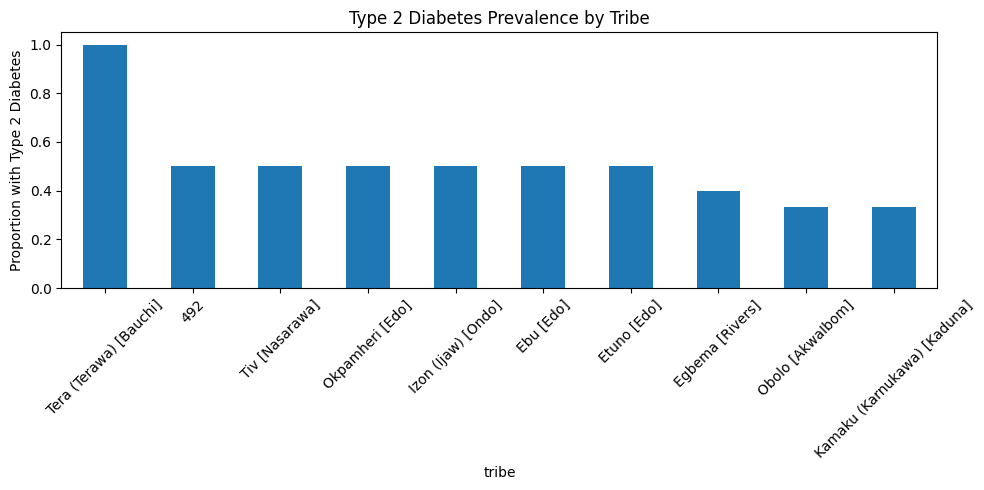

In [ ]:
if "tribe" in df.columns:
    group_summary = df.groupby("tribe")[["has_Type_2_Diabetes"]].mean().sort_values("has_Type_2_Diabetes", ascending=False).head(10)
    group_summary.plot(kind="bar", figsize=(10, 5), legend=False)
    plt.title("Type 2 Diabetes Prevalence by Tribe")
    plt.ylabel("Proportion with Type 2 Diabetes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("fig_tribe_Type_2_Diabetes.png")
    plt.show()

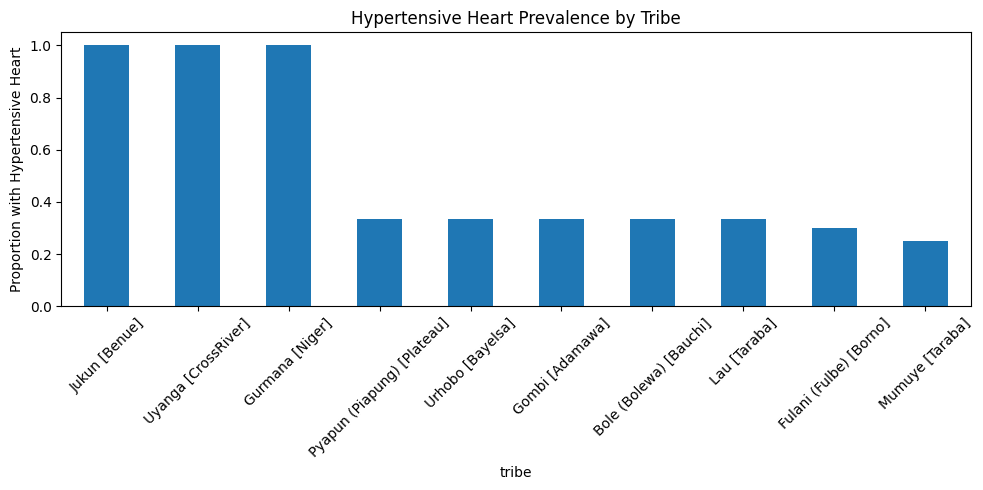

In [ ]:
if "tribe" in df.columns:
    group_summary = df.groupby("tribe")[["has_Hypertensive_heart_disease"]].mean().sort_values("has_Hypertensive_heart_disease", ascending=False).head(10)
    group_summary.plot(kind="bar", figsize=(10, 5), legend=False)
    plt.title("Hypertensive Heart Prevalence by Tribe")
    plt.ylabel("Proportion with Hypertensive Heart")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("fig_tribe_hypertensive.png")
    plt.show()

**Purpose**  
Displays the average prevalence of hypertension across tribal groups (top 10 tribes).

**Why It Matters**  
- Reveals disparities in chronic disease burden across ethnic subgroups.  
- Provides evidence for targeted public health interventions.  
- Supports equity-centered modeling and policy design.


In [ ]:
import matplotlib.pyplot as plt
import os

# List of sociodemographic columns to analyze
group_cols = ["tribe", "religion", "income", "education"]

# Create output directory
os.makedirs("grouped_prevalence_plots", exist_ok=True)

# Identify disease flag columns (e.g., has_Hypertension)
disease_cols = [col for col in df.columns if col.startswith("has_")]

# Iterate over sociodemographics and diseases
for group_col in group_cols:
    if group_col not in df.columns:
        print(f"Skipping {group_col} — not found in data.")
        continue

    for disease_col in disease_cols:
        try:
            group_summary = (
                df.groupby(group_col)[[disease_col]]
                .mean()
                .sort_values(disease_col, ascending=False)
                .head(10)
            )

            # Plot
            group_summary.plot(kind="bar", figsize=(10, 5), legend=False)
            plt.title(f"{disease_col.replace('has_', '')} Prevalence by {group_col.capitalize()}")
            plt.ylabel("Proportion with Condition")
            plt.xlabel(group_col.capitalize())
            plt.xticks(rotation=45)
            plt.tight_layout()

            # Save
            fname = f"grouped_prevalence_plots/{disease_col}_{group_col}.png"
            plt.savefig(fname)
            plt.close()
        except Exception as e:
            print(f"Error plotting {disease_col} by {group_col}: {e}")


##  Explanation: Grouped Prevalence Plotting by Sociodemographics

###  Purpose
Automatically visualize chronic disease prevalence (e.g., hypertension, diabetes) across key sociodemographic categories such as:
- Tribe
- Religion
- Income
- Education

Each chart compares the top 10 most prevalent categories per group.

---

###  How It Works

1. **Group Column Selection**
   - The list `group_cols` defines which sociodemographic variables to analyze.

2. **Disease Column Detection**
   - All columns starting with `has_` are assumed to be binary indicators of chronic diseases (e.g., `has_Hypertension`, `has_Type_2_Diabetes`).

3. **Grouping and Averaging**
   - For each disease and each group column:
     - The mean of the binary flag is computed per group using `df.groupby(group_col)[[disease_col]].mean()`.
     - This gives the proportion of individuals within that group who have the condition.

4. **Plotting**
   - A barplot is created showing the top 10 subgroups for each disease sorted by prevalence.
   - Axes are labeled clearly for interpretability.
   - Plots are saved to `grouped_prevalence_plots/` for reporting or downstream visualization.

5. **Error Handling**
   - If a group column is missing or an exception occurs during plotting, the script skips it gracefully.

---

###  Why It Matters

- **Equity Insight:** Highlights disparities in chronic disease burden across tribal, religious, economic, and educational lines.
- **Public Health Strategy:** Helps target the most affected communities for interventions or further study.
- **Modeling Preparation:** Enables subgroup-based risk modeling and stratified evaluation.

---

###  Relevance to Project

This aligns with the project’s central goal:
> _"AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations."_

By surfacing which groups bear the greatest disease burden, we lay the groundwork for targeted, equitable AI interventions in healthcare.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import os

# === CONFIG ===
group_cols = ["tribe", "religion", "income", "education"]
disease_cols = [col for col in df.columns if col.startswith("has_")]

# Create folders
os.makedirs("grouped_prevalence_plots", exist_ok=True)
os.makedirs("grouped_prevalence_csvs", exist_ok=True)
os.makedirs("grouped_prevalence_heatmaps", exist_ok=True)

chi2_results = []

# Loop across all sociodemographic columns and disease flags
for group_col in group_cols:
    if group_col not in df.columns:
        continue

    for disease_col in disease_cols:
        try:
            # Grouped mean prevalence
            group_summary = (
                df.groupby(group_col)[disease_col]
                .mean()
                .sort_values(ascending=False)
                .head(10)
            )

            # Save group summary to CSV
            group_summary.to_csv(f"grouped_prevalence_csvs/{disease_col}_{group_col}.csv")

            # Plot bar
            group_summary.plot(kind="bar", figsize=(10, 5), legend=False)
            plt.title(f"{disease_col.replace('has_', '')} Prevalence by {group_col.capitalize()}")
            plt.ylabel("Proportion with Disease")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"grouped_prevalence_plots/{disease_col}_{group_col}.png")
            plt.close()

            # Chi-squared test
            crosstab = pd.crosstab(df[group_col], df[disease_col])
            if crosstab.shape[0] > 1 and crosstab.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(crosstab)
                chi2_results.append({
                    "group": group_col,
                    "disease": disease_col,
                    "chi2": chi2,
                    "p_value": p,
                    "dof": dof
                })

        except Exception as e:
            print(f"Error with {group_col} vs {disease_col}: {e}")

# Save chi-squared test results
pd.DataFrame(chi2_results).to_csv("grouped_prevalence_csvs/chi2_summary.csv", index=False)

# === HEATMAPS ===
for group_col in group_cols:
    if group_col not in df.columns:
        continue

    heat_data = {}
    for disease_col in disease_cols:
        means = df.groupby(group_col)[disease_col].mean()
        heat_data[disease_col.replace("has_", "")] = means

    heatmap_df = pd.DataFrame(heat_data).fillna(0)
    plt.figure(figsize=(14, max(6, len(heatmap_df) * 0.4)))
    sns.heatmap(heatmap_df, annot=False, cmap="YlGnBu", linewidths=0.5)
    plt.title(f"Disease Prevalence Heatmap by {group_col.capitalize()}")
    plt.tight_layout()
    plt.savefig(f"grouped_prevalence_heatmaps/heatmap_{group_col}.png")
    plt.close()


##  Explanation: Grouped Disease Prevalence with Statistical Testing and Heatmaps

###  Purpose
To explore, visualize, and statistically assess the relationship between chronic disease prevalence and key sociodemographic factors in the dataset (e.g., tribe, religion, income, education).

---

###  Key Components

#### 1. **Prevalence Summary by Group**
- For each disease (e.g., `has_Hypertension`) and each group variable (e.g., `tribe`, `income`):
  - Computes mean prevalence of the disease within each group using `df.groupby(group_col)[disease_col].mean()`.
  - Saves top 10 groups with highest prevalence to CSV (`grouped_prevalence_csvs/`) for downstream reporting or dashboards.
  - Barplots are saved to `grouped_prevalence_plots/` to visualize relative burden.

#### 2. **Chi-Squared Test for Association**
- Uses `pd.crosstab()` to generate contingency tables between group and disease flags.
- Applies `chi2_contingency()` from `scipy.stats` to test for statistical independence.
- Saves results including:
  - Chi-squared statistic (`chi2`)
  - p-value
  - Degrees of freedom (`dof`)
- Output is saved to `grouped_prevalence_csvs/chi2_summary.csv`.

#### 3. **Heatmaps of Prevalence**
- For each group variable (e.g., tribe), computes average disease prevalence for all diseases.
- Constructs a matrix of shape (groups × diseases).
- Uses `sns.heatmap()` to plot a visual overview of disparities.
- Saved heatmaps (one per group variable) to `grouped_prevalence_heatmaps/`.

---

###  Why It Matters

- **Visual Prevalence Insight:** Shows which groups bear the highest burden for each condition.
- **Statistical Rigor:** Chi-squared tests identify significant associations between social categories and diseases.
- **Holistic View:** Heatmaps offer a comprehensive snapshot of disease distribution across different population strata.

---

###  Relevance to Project

This implementation is core to the project goal:

> _"AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations."_

By quantifying and visualizing disparities across ethnic, economic, and cultural dimensions, the system enables:

- Identification of high-risk subpopulations.
- Informed model training and stratified evaluation.
- Public health insights for targeted intervention and policy development.

### Data Audit and Harmonization

#### Goals:

Validate formats

Map questionnaire fields to meaningful variables

Link PID with genotypic (SNP) data

In [ ]:
# === Load Data ===
data = pd.read_csv("/content/sample_data/phenotype_survey.csv")

/tmp/ipython-input-19-2462052338.py:2: DtypeWarning: Columns (128) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/sample_data/phenotype_survey.csv")


In [ ]:
# Duplicate Visualization & Cleaning Functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_duplicate_distribution(df, pid_col="pid", by_factors=["Site", "tribe", "religion"]):
    """
    Visualizes duplicate PID distributions across selected sociodemographic columns.
    Saves plots for each factor in current directory.
    """
    dup_df = df[df.duplicated(pid_col, keep=False)]

    print(f"Total duplicate PIDs: {dup_df[pid_col].nunique()}")

    os.makedirs("duplicates_summary_plots", exist_ok=True)

    for factor in by_factors:
        if factor in df.columns:
            plt.figure(figsize=(10, 4))
            sns.countplot(data=dup_df, x=factor, order=dup_df[factor].value_counts().index[:10])
            plt.title(f"Duplicate Entries by {factor}")
            plt.ylabel("Duplicate Count")
            plt.xlabel(factor)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"duplicates_summary_plots/duplicate_by_{factor}.png")
            plt.close()
            print(f"Saved plot: duplicate_by_{factor}.png")

def deduplicate_by_quality(df, pid_col="pid", date_col="SubmissionDate", quality_col="review_quality"):
    """
    Deduplicates rows by PID using the following priority:
    1. Highest review_quality (if available)
    2. Most recent SubmissionDate
    3. First form if tie or missing
    Returns: deduplicated DataFrame
    """
    df = df.copy()

    if quality_col not in df.columns:
        df[quality_col] = 0
    if date_col not in df.columns:
        df[date_col] = pd.NaT

    # Parse date if needed
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Sort for deduplication priority
    df_sorted = df.sort_values(by=[quality_col, date_col], ascending=[False, False])
    df_dedup = df_sorted.drop_duplicates(subset=pid_col, keep="first")

    print(f"Deduplicated: {len(df)} → {len(df_dedup)} rows")

    return df_dedup

In [ ]:
# Step 1: Visualize where duplicates exist
plot_duplicate_distribution(data)

# Step 2: Deduplicate using review_quality and SubmissionDate
df_clean = deduplicate_by_quality(data)

# Step 3: Verify result
assert df_clean["pid"].is_unique, "Still duplicates present!"

Total duplicate PIDs: 925
Saved plot: duplicate_by_Site.png
Saved plot: duplicate_by_tribe.png
Saved plot: duplicate_by_religion.png
Deduplicated: 39479 → 38518 rows


In [ ]:
df_clean.to_csv("phenotype_survey_cleaned.csv", index=False)

In [ ]:
# === Load Clean Data ===
d = pd.read_csv("/content/phenotype_survey_cleaned.csv")

/tmp/ipython-input-23-904554140.py:2: DtypeWarning: Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("/content/phenotype_survey_cleaned.csv")


In [ ]:
# Check unique participants
assert d['pid'].is_unique, "Duplicates found in PIDs!"

# Basic summary
print(d.shape)
print(d.columns)

# ICD flag creation
d['hypertension_flag'] = d['ICD10_comobidity_1'].str.contains("I10", na=False)
d['diabetes_flag'] = d['ICD10_comobidity_1'].str.contains("E11", na=False)
d['liver_flag'] = d['ICD10_comobidity_1'].str.contains("K7", na=False)  # Example for liver

# Tribe and Lifestyle encoding
tribe_cols = ['tribe', 'General Tribes', 'language']
lifestyle_cols = ['fruit_servings', 'veg_servings', 'oil_type', 'smoke_cigarette', 'religion', 'income']

# Drop participants with missing genotype linkage
d = d[d['pid'].notnull()]

(38518, 160)
Index(['SubmissionDate', 'username', 'date_q', 'pid', 'Site', 'Disease group',
       'Gender', 'age', 'Proper_Signatory', 'Permission_rare',
       ...
       'two_RR', 'one_pulse_rate', 'two_pulse_rate', 'one_Temperature_Celsius',
       'instanceID', 'instanceName', 'formdef_version', 'review_quality',
       'review_status', 'KEY'],
      dtype='object', length=160)


### Genotype–Phenotype Linking
#### Objective:

Match participants in our cleaned phenotype dataset (df_clean) with their corresponding SNP genotypes from PLINK binary format (.bed, .bim, .fam) when available.

In [ ]:
# Export .keep file for PLINK (two columns: FID and IID)
pid_df = df_clean[["pid"]]  # If both FID and IID are pid
pid_df["FID"] = pid_df["pid"]
pid_df["IID"] = pid_df["pid"]
pid_df[["FID", "IID"]].to_csv("pid_list.txt", sep="\t", index=False, header=False)

/tmp/ipython-input-25-3216584552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df["FID"] = pid_df["pid"]
/tmp/ipython-input-25-3216584552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df["IID"] = pid_df["pid"]


In [ ]:
import subprocess

def run_plink_extract(
    bfile_prefix,
    keep_file,
    out_prefix,
    extract_snps=None,
    maf_threshold=None,
    geno_threshold=None,
    verbose=True
):
    """
    Run PLINK from Python with optional SNP and sample filters.

    Parameters:
    - bfile_prefix (str): Path to the base .bed/.bim/.fam files (without extension)
    - keep_file (str): Path to .txt file with FID IID list to retain
    - out_prefix (str): Output prefix for PLINK output
    - extract_snps (str): Optional path to SNP list file (one SNP ID per line)
    - maf_threshold (float): Minor Allele Frequency filter (e.g., 0.01)
    - geno_threshold (float): Missing rate filter (e.g., 0.05)
    - verbose (bool): Print command and output

    Returns:
    - returncode (int): 0 if successful
    """
    # Path to locally installed PLINK binary
    plink_bin = "./plink_bin/plink"

    cmd = [
        plink_bin,
        "--bfile", bfile_prefix,
        "--keep", keep_file,
        "--make-bed",
        "--out", out_prefix
    ]

    if extract_snps:
        cmd += ["--extract", extract_snps]

    if maf_threshold is not None:
        cmd += ["--maf", str(maf_threshold)]

    if geno_threshold is not None:
        cmd += ["--geno", str(geno_threshold)]

    if verbose:
        print(" Running PLINK command:")
        print(" ".join(cmd))

    result = subprocess.run(cmd, capture_output=True, text=True)

    if result.returncode == 0:
        if verbose:
            print(" PLINK completed successfully.")
            print(result.stdout)
    else:
        print(" PLINK failed.")
        print(result.stderr)

    return result.returncode

In [ ]:
!apt-get install -y plink

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
plink is already the newest version (1.07+dfsg-4).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Step 1: Download and install PLINK v1.9
!wget -qO- http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20201019.zip > plink.zip
!unzip -o plink.zip -d plink_bin
!chmod +x plink_bin/plink

# Step 2: Confirm installation
!./plink_bin/plink --version

Archive:  plink.zip
  inflating: plink_bin/plink         
  inflating: plink_bin/LICENSE       
  inflating: plink_bin/toy.ped       
  inflating: plink_bin/toy.map       
  inflating: plink_bin/prettify      
PLINK v1.90b6.21 64-bit (19 Oct 2020)


In [ ]:
!plink --version

/bin/bash: line 1: plink: command not found


In [ ]:
run_plink_extract(
    bfile_prefix="full_genome_data",
    keep_file="/content/pid_list.txt",
    out_prefix="subset_data",
    extract_snps="snp_list.txt",       # Optional
    maf_threshold=0.01,                # Optional
    geno_threshold=0.05,               # Optional
    verbose=True
)

 Running PLINK command:
./plink_bin/plink --bfile full_genome_data --keep /content/pid_list.txt --make-bed --out subset_data --extract snp_list.txt --maf 0.01 --geno 0.05
 PLINK failed.
Error: Failed to open full_genome_data.bed.



2

#### No genotype data!

We don't have access to genotype data yet.

### Sociogenomic Pipeline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# === Step 1: Load and Audit Phenotypic Data ===
def load_phenotype_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded data with shape: {df.shape}")
    assert df['pid'].is_unique, "PIDs are not unique!"
    return df

# === Step 2: Create ICD-10 Based Disease Flags ===
def create_icd10_flags(df):
    df['hypertension_flag'] = df['ICD10_comobidity_1'].str.contains("I10", na=False)
    df['diabetes_flag'] = df['ICD10_comobidity_1'].str.contains("E11", na=False)
    df['liver_flag'] = df['ICD10_comobidity_1'].str.contains("K7", na=False)
    return df

# === Step 3: Encode Categorical and Numeric Features ===
def encode_features(df, categorical_columns, numeric_columns):
    df = df[categorical_columns + numeric_columns].fillna("Unknown")

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cat = encoder.fit_transform(df[categorical_columns])
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    X_cat = pd.DataFrame(encoded_cat, columns=encoded_feature_names)

    X_num = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Align indices
    X_cat.index = X_num.index

    X = pd.concat([X_num, X_cat], axis=1)
    return X

# === Example Usage ===
if __name__ == "__main__":
    phenotype_path = "/content/phenotype_survey_cleaned.csv"
    df = load_phenotype_data(phenotype_path)

    # Step 2: Generate flags from ICD10
    df = create_icd10_flags(df)

    # Step 3: Prepare features for downstream modeling
    cat_cols = ['tribe', 'religion', 'oil_type']
    num_cols = ['fruit_servings', 'veg_servings', 'BMI']

    X_meta = encode_features(df, cat_cols, num_cols)
    X_meta.to_csv("X_meta.csv", index=False)

    # Summary
    print("Phenotypic design matrix shape:", X_meta.shape)
    print("First few rows:\n", X_meta.head())
    print("Phenotype features ready. SNP data to be added in future steps.")


/tmp/ipython-input-27-314853742.py:7: DtypeWarning: Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loaded data with shape: (38518, 160)
Phenotypic design matrix shape: (38518, 361)
First few rows:
    fruit_servings  veg_servings        BMI  tribe_144  tribe_221  tribe_231  \
0             0.0           0.0  29.411765        0.0        0.0        0.0   
1             0.0           0.0  21.875000        0.0        0.0        0.0   
2             0.0           0.0  30.846277        0.0        0.0        0.0   
3             0.0           0.0  26.619343        0.0        0.0        0.0   
4             0.0           0.0  24.557752        0.0        0.0        0.0   

   tribe_239  tribe_245  tribe_246  tribe_250  ...  religion_Others  \
0        0.0        0.0        0.0        0.0  ...              0.0   
1        0.0        0.0        0.0        0.0  ...              0.0   
2        0.0        0.0        0.0        0.0  ...              0.0   
3        0.0        0.0        0.0        0.0  ...              0.0   
4        0.0        0.0        0.0        0.0  ...              0.0   


##  Explanation: Sociogenomic Pipeline for Phenotype Preprocessing

This section outlines a modular pipeline for transforming raw phenotype survey data into a clean, encoded matrix suitable for downstream disease modeling. It focuses on social, lifestyle, and clinical variables, laying the foundation for later genomic integration.

---

###  Load and Audit Phenotypic Data

```python
def load_phenotype_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded data with shape: {df.shape}")
    assert df['pid'].is_unique, "PIDs are not unique!"
    return df
```

**Purpose:**  
Reads in the cleaned phenotype dataset and ensures participant identifiers (`pid`) are unique.

**Why It Matters:**  
Uniqueness is critical to avoid duplicated participants during modeling or merging with SNP data.

**Outcome:**  
A DataFrame ready for disease flag extraction.

---

###  Create ICD-10 Based Disease Flags

```python
def create_icd10_flags(df):
    df['hypertension_flag'] = df['ICD10_comobidity_1'].str.contains("I10", na=False)
    df['diabetes_flag'] = df['ICD10_comobidity_1'].str.contains("E11", na=False)
    df['liver_flag'] = df['ICD10_comobidity_1'].str.contains("K7", na=False)
    return df
```

**Purpose:**
Transforms ICD-10 diagnosis codes into binary disease flags (e.g., hypertension, diabetes).

**Why:**
Provides structured, analyzable target variables for classification and SHAP interpretability.

**Clinical Mapping:**

"I10" → Hypertension

"E11" → Type 2 Diabetes

"K7" → Liver Disease

**Outcome:**
Adds disease labels as columns to the dataframe (e.g., hypertension_flag).


### Encode Categorical and Numeric Features

```python
def encode_features(df, categorical_columns, numeric_columns):
    df = df[categorical_columns + numeric_columns].fillna("Unknown")

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cat = encoder.fit_transform(df[categorical_columns])
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    X_cat = pd.DataFrame(encoded_cat, columns=encoded_feature_names)

    X_num = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    X_cat.index = X_num.index
    X = pd.concat([X_num, X_cat], axis=1)
    return X
```

### Purpose: Design Matrix Preparation (`X_meta`)

**Objective:**  
Prepares a design matrix `X_meta` by:
- One-hot encoding categorical features (e.g., `tribe`, `religion`, `oil_type`)
- Casting numeric features to float (e.g., `BMI`, `fruit_servings`)

**Why:**
- Categorical data must be transformed into numeric format for compatibility with machine learning models.
- Missing values are handled robustly to prevent modeling issues:
  - `"Unknown"` for missing categorical entries
  - `0` for numeric entries after coercing non-numeric inputs to NaN

**Output:**  
Returns a fully encoded matrix `X_meta` that is:
- Ready for downstream modeling (e.g., classification)
- Compatible with dimensionality reduction techniques (e.g., SHAP, UMAP)


### Execution Example

```python
if __name__ == "__main__":
    phenotype_path = "/content/phenotype_survey_cleaned.csv"
    df = load_phenotype_data(phenotype_path)

    # Step 2: Generate flags from ICD10
    df = create_icd10_flags(df)

    # Step 3: Prepare features for downstream modeling
    cat_cols = ['tribe', 'religion', 'oil_type']
    num_cols = ['fruit_servings', 'veg_servings', 'BMI']

    X_meta = encode_features(df, cat_cols, num_cols)
    X_meta.to_csv("X_meta.csv", index=False)

    # Summary
    print("Phenotypic design matrix shape:", X_meta.shape)
    print("First few rows:\n", X_meta.head())
    print("Phenotype features ready. SNP data to be added in future steps.")
```

###  Output

- **`X_meta.csv`**: Feature matrix for modeling, combining both categorical (one-hot encoded) and numeric features.
- **Console output**: Includes the shape of the matrix and a preview of the first few rows.

###  Relevance to Project

This preprocessing pipeline lays the foundation for:

**"AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations."**

It ensures:
- High-quality integration of phenotype data.
- Interpretability for downstream SHAP and clustering analysis.
- Reproducibility and readiness for merging with genomic data such as SNPs or Polygenic Risk Scores (PRS) (when available).



In [ ]:
import json

# Define the full-text diagnosis mapping
icd10_flag_mapper = {
    "Essential (primary) hypertension": "Hypertension",
    "Type 2 diabetes mellitus": "Type_2_Diabetes",
    "Hypertensive heart disease": "Hypertensive_heart_disease",
    "Type 1 diabetes mellitus": "Type_1_Diabetes",
    "Asthma": "Asthma",
    "Epilepsy": "Epilepsy",
    "Chronic viral hepatitis": "Chronic_hepatitis"
}

# Save it as a JSON file
with open("icd10_flag_mapper_text.json", "w") as f:
    json.dump(icd10_flag_mapper, f, indent=4)

print("✅ icd10_flag_mapper_text.json has been created.")

✅ icd10_flag_mapper_text.json has been created.


###  Explanation: Creating a Full-Text ICD-10 to Disease Mapping JSON

#### 🔹 Purpose
Creates a dictionary (`icd10_flag_mapper`) that maps **full-text clinical diagnosis strings** (e.g., `"Essential (primary) hypertension"`) to **simplified internal variable names** (e.g., `"Hypertension"`).

####  Why This Matters
- In real-world clinical or survey data, diagnoses may appear in **descriptive form**, not as compact ICD-10 codes (like "I10").
- By mapping long descriptions to concise, machine-readable keys, we enable:
  - Consistent column naming (e.g., `has_Hypertension`)
  - Easier pattern matching and filtering
  - Transparent interpretation for clinicians and researchers

####  How It Works
```python
icd10_flag_mapper = {
    "Essential (primary) hypertension": "Hypertension",
    "Type 2 diabetes mellitus": "Type_2_Diabetes",
    ...
}
```

###  Keys and Values

- **Keys**: Full-text diagnosis descriptions from the dataset  
  _Example_: `"Essential (primary) hypertension"`

- **Values**: Standardized, simplified variable names used in code and visualizations  
  _Example_: `"Hypertension"`

---

###  Exporting to JSON

```python
with open("icd10_flag_mapper_text.json", "w") as f:
    json.dump(icd10_flag_mapper, f, indent=4)
```

###  Output Summary

- **Saves the mapping to** `icd10_flag_mapper_text.json`
- **Benefits**:
  - Reusable across analyses and scripts
  - Editable and human-readable
  - Version-controllable for reproducible research

---

###  Output File

**`icd10_flag_mapper_text.json`**  
A clean, structured JSON file that maps descriptive ICD-10 text entries to concise, analyzable disease labels.

---

###  Relevance to Project

This mapping enables robust parsing of clinical text and automated labeling of chronic conditions. It is especially useful for:

-  **Exploratory phenotype flagging**
-  **Cross-language or heterogeneous medical data sources**
-  **Disease prevalence analysis and SHAP interpretation**

---

All contributing to the overarching goal of:

> **“AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations.”**


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import shap
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score

# === CONFIG ===
PHENOTYPE_PATH = "/content/phenotype_survey_cleaned.csv"
ICD10_MAPPER_PATH = "/content/icd10_flag_mapper_text.json"
OUTPUT_DIR = "disease_modeling_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === STEP 1: LOAD AND FLAG ICD10 ===
def load_phenotype_data(path):
    df = pd.read_csv(path, low_memory=False)
    df = df[df["pid"].notnull()]
    print(f" Loaded: {df.shape}")
    return df

def generate_disease_flags(df, icd_col, mapper_path, min_cases=10):
    with open(mapper_path) as f:
        icd_map = json.load(f)

    # Create flags from ICD-10 codes
    disease_flags = {}
    icd_values = df[icd_col].astype(str)

    for code, disease in icd_map.items():
        col_name = f"has_{disease.replace(' ', '_')}"
        match = icd_values.str.startswith(code)
        if match.sum() >= min_cases:
            df[col_name] = match
            disease_flags[col_name] = match.sum()
        else:
            print(f"Skipping {col_name}: only {match.sum()} positive cases.")

    print(f" Generated {len(disease_flags)} disease flags with at least {min_cases} cases.")
    return df, list(disease_flags.keys())

# === STEP 2: ENCODE FEATURES ===
def encode_features(df, categorical_cols, numeric_cols):
    df = df[categorical_cols + numeric_cols].copy()
    df[categorical_cols] = df[categorical_cols].fillna("Unknown")
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_cat = encoder.fit_transform(df[categorical_cols])
    encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
    X_cat = pd.DataFrame(encoded_cat, columns=encoded_feature_names)

    X_cat.index = df.index
    X = pd.concat([df[numeric_cols], X_cat], axis=1)
    X.columns = X.columns.str.replace(r"[\[\]<>]", "", regex=True)
    return X

# === STEP 3: MODELING + SHAP ===
def run_modeling_pipeline(df, X, disease_flags, group_cols, output_dir):
    result_summary = []

    for disease_flag in disease_flags:
        print(f"\n Running for {disease_flag}")
        y = df[disease_flag].astype(int)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        model = xgb.XGBClassifier(eval_metric="logloss", n_jobs=-1)
        model.fit(X_train, y_train)

        joblib.dump(model, os.path.join(output_dir, f"{disease_flag}_model.pkl"))

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

        with open(os.path.join(output_dir, f"{disease_flag}_report.txt"), "w") as f:
            report = classification_report(y_test, y_pred, zero_division=0)
            f.write(report)
            f.write(f"\nROC AUC: {auc:.4f}\n")

        # SHAP
        try:
            explainer = shap.Explainer(model, X_test, feature_perturbation="interventional")
            shap_values = explainer(X_test)

            shap.summary_plot(shap_values, X_test, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{disease_flag}_shap_summary.png"))
            plt.close()

            for group in group_cols:
                if group not in df.columns:
                    continue
                shap_group = X_test.copy()
                shap_group[group] = df[group].loc[X_test.index].values
                group_means = shap_group.groupby(group).mean()
                group_means.to_csv(os.path.join(output_dir, f"{disease_flag}_shap_mean_by_{group}.csv"))

        except Exception as e:
            print(f" SHAP failed for {disease_flag}: {e}")

        result_summary.append({
            "disease_flag": disease_flag,
            "positive_cases": int(y.sum()),
            "auc": auc
        })

    pd.DataFrame(result_summary).to_csv(os.path.join(output_dir, "summary_results.csv"), index=False)
    # === VISUALIZE GROUP SHAP RESULTS ===
    generate_group_level_shap_visuals_and_summary(output_dir, group_cols)

# === SHAP GROUP VISUALIZATION FUNCTION ===
def generate_group_level_shap_visuals_and_summary(results_dir, group_cols):
    summary = []
    for fname in os.listdir(results_dir):
        if not fname.startswith("has_") or not fname.endswith("_model.pkl"):
            continue

        disease_flag = fname.replace("_model.pkl", "")
        shap_files = {
            group: os.path.join(results_dir, f"{disease_flag}_shap_mean_by_{group}.csv")
            for group in group_cols
        }

        for group, path in shap_files.items():
            if not os.path.exists(path):
                continue

            df_group = pd.read_csv(path, index_col=0)
            top_features = df_group.abs().mean().sort_values(ascending=False).head(10)

            plt.figure(figsize=(10, 6))
            top_features.plot(kind='barh')
            plt.gca().invert_yaxis()
            plt.title(f"Top SHAP Features: {disease_flag} by {group}")
            plt.xlabel("Mean Absolute SHAP Value")
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, f"{disease_flag}_shap_top10_by_{group}.png"))
            plt.close()

            for feature, value in top_features.items():
                summary.append({
                    "disease_flag": disease_flag,
                    "group": group,
                    "feature": feature,
                    "mean_abs_shap": value
                })

    pd.DataFrame(summary).to_csv(os.path.join(results_dir, "group_shap_summary.csv"), index=False)
    print("  SHAP visualizations and summary completed.")

# === MAIN PIPELINE ===
if __name__ == "__main__":
    df = load_phenotype_data(PHENOTYPE_PATH)

    #  Use actual ICD code column — not full text
    df, disease_flags = generate_disease_flags(
        df, icd_col="ICD10_comobidity_1", mapper_path=ICD10_MAPPER_PATH, min_cases=10
    )

    categorical_cols = ["tribe", "religion", "oil_type"]
    numeric_cols = ["fruit_servings", "veg_servings", "BMI"]
    X_meta = encode_features(df, categorical_cols, numeric_cols)

    df.to_csv("phenotype_with_flags.csv", index=False)
    X_meta.to_csv("X_meta.csv", index=False)

    run_modeling_pipeline(df, X_meta, disease_flags, group_cols=["tribe", "religion"], output_dir=OUTPUT_DIR)

    print(" Pipeline completed.")

 Loaded: (38518, 160)
 Generated 7 disease flags with at least 10 cases.

 Running for has_Hypertension


 94%|=================== | 7225/7704 [00:11<00:00]       


 Running for has_Type_2_Diabetes


 99%|===================| 7629/7704 [00:14<00:00]       


 Running for has_Hypertensive_heart_disease


 96%|=================== | 7409/7704 [00:14<00:00]       


 Running for has_Type_1_Diabetes


 98%|===================| 7540/7704 [00:21<00:00]       


 Running for has_Asthma


 95%|=================== | 7293/7704 [00:18<00:01]       


 Running for has_Epilepsy


 96%|=================== | 7397/7704 [00:14<00:00]       


 Running for has_Chronic_hepatitis


 98%|===================| 7571/7704 [00:17<00:00]       

  SHAP visualizations and summary completed.
 Pipeline completed.


##  AI-Driven Disease Modeling and SHAP Interpretation Pipeline

This pipeline enables interpretable machine learning models to predict chronic disease flags (from ICD-10) using sociodemographic and lifestyle features. It outputs SHAP-based visualizations for equity-centered insights.

---

###   Load and Audit Phenotype Data

```python
PHENOTYPE_PATH = "/content/phenotype_survey_cleaned.csv"

df = pd.read_csv(PHENOTYPE_PATH)
df = df[df["pid"].notnull()]  # Ensure valid participant IDs
```

* **Why:** Ensures high-quality phenotype records and prevents merging errors.

---

###   Generate Disease Flags from ICD-10

```python
with open(ICD10_MAPPER_PATH) as f:
    icd_map = json.load(f)

for code, disease in icd_map.items():
    col_name = f"has_{disease.replace(' ', '_')}"
    match = df["ICD10_comobidity_1"].str.startswith(code)
    if match.sum() >= min_cases:
        df[col_name] = match
```

* **Purpose:** Converts ICD-10 codes into binary flags for conditions (e.g., hypertension).
* **Why:** Creates clean target labels for modeling.
* **Output:** List of disease flag columns with enough cases (>=10).

---

###   Encode Features for Modeling

```python
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_cat = encoder.fit_transform(df[categorical_cols])
X_cat = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out())
X = pd.concat([df[numeric_cols], X_cat], axis=1)
```

* **Why:** ML models require numeric input. Categorical features are one-hot encoded; numeric features are cleaned.
* **Output:** `X_meta` feature matrix for modeling.

---

###  Train Models and Generate SHAP

```python
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
shap_values = shap.Explainer(model, X_test)(X_test)
shap.summary_plot(shap_values, X_test)
```

* **Purpose:** For each disease, trains an XGBoost model and interprets it via SHAP.
* **Why:** Identifies key social or lifestyle drivers of each disease.
* **Output:**

  * Classification reports and AUC
  * SHAP summary plots
  * Per-group SHAP mean tables (e.g., tribe, religion)

---

###   Group-Level SHAP Visualizations

```python
for group in ["tribe", "religion"]:
    group_means = X_test.groupby(df[group].loc[X_test.index]).mean()
    group_means.to_csv(...)
```

* **Why:** Compares SHAP values across sociodemographic strata.
* **Output:**

  * Barplots of top SHAP features by group
  * CSV summaries of mean SHAP values
  * Aggregated group-level SHAP report

---

###  Output Files

* `phenotype_with_flags.csv` – Labeled phenotype data
* `X_meta.csv` – Encoded feature matrix
* `has_<Disease>_model.pkl` – Trained classifier
* `has_<Disease>_shap_summary.png` – Global SHAP interpretation
* `has_<Disease>_shap_top10_by_<Group>.png` – Group-wise SHAP
* `group_shap_summary.csv` – Tabular SHAP insights

---

###  Relevance to Project

This pipeline operationalizes core aspects of the project:

> “AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations”

* Enables equity-aware model interpretation
* Prioritizes diseases and drivers for targeted interventions
* Makes outputs accessible to public health stakeholders

---

###  Conclusion

This end-to-end pipeline integrates cleaned phenotype data, performs supervised disease modeling, and enables transparent SHAP-based interpretation — critical for identifying hidden inequities and guiding policy.

/tmp/ipython-input-31-1038470103.py:8: DtypeWarning: Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/phenotype_with_flags.csv")


Detected disease flags: ['has_Hypertension', 'has_Type_2_Diabetes', 'has_Hypertensive_heart_disease', 'has_Type_1_Diabetes', 'has_Asthma', 'has_Epilepsy', 'has_Chronic_hepatitis']


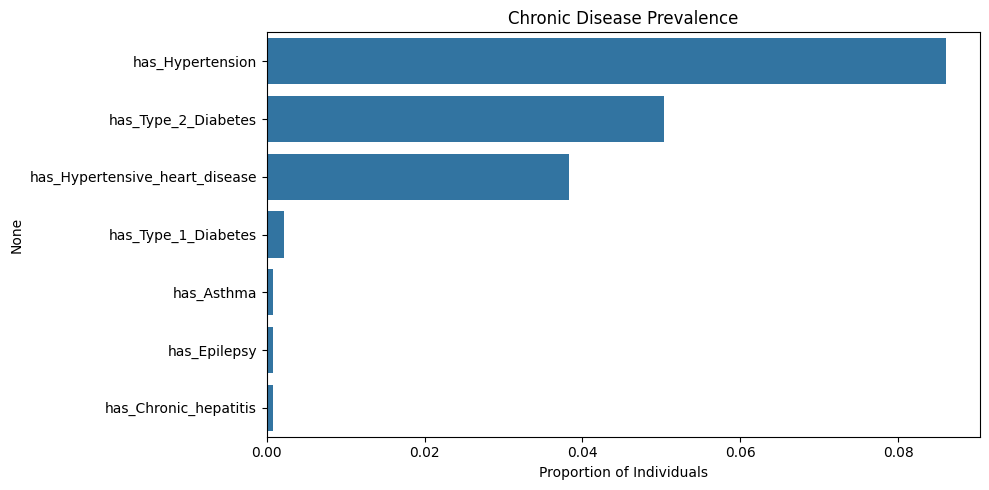

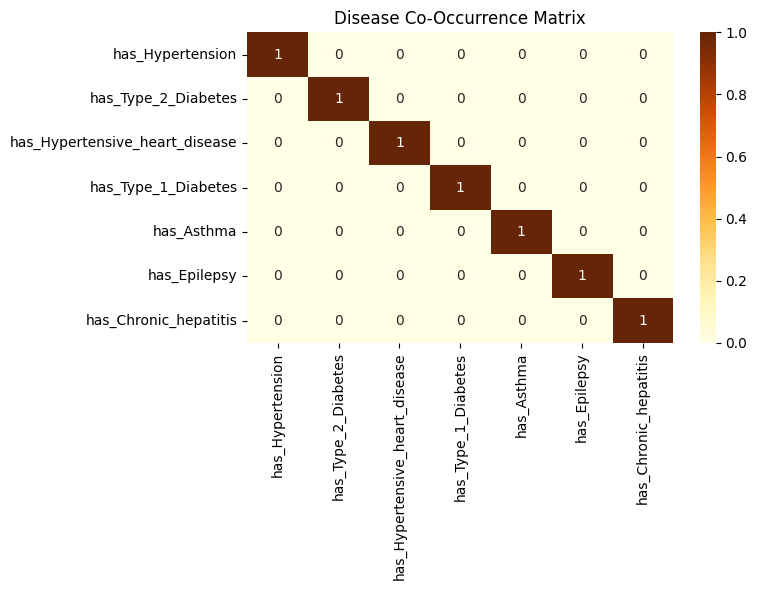


Stratifying has_Hypertension by tribe...
Chi-squared test p-value: 0.00000


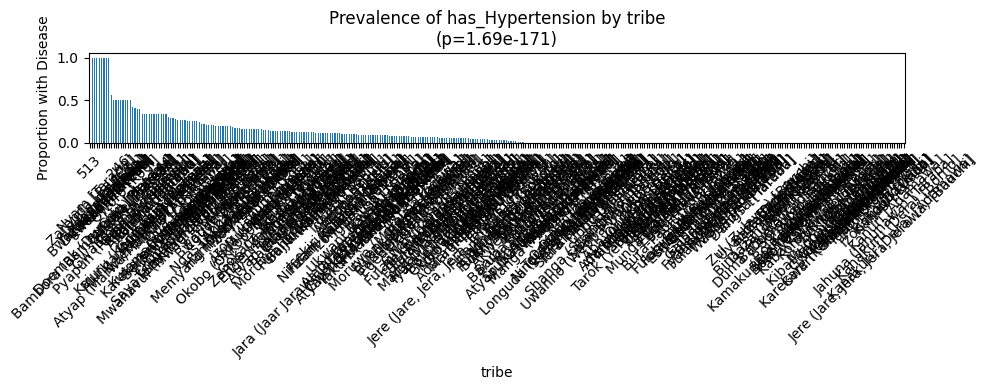


Stratifying has_Hypertension by religion...
Chi-squared test p-value: 0.00000


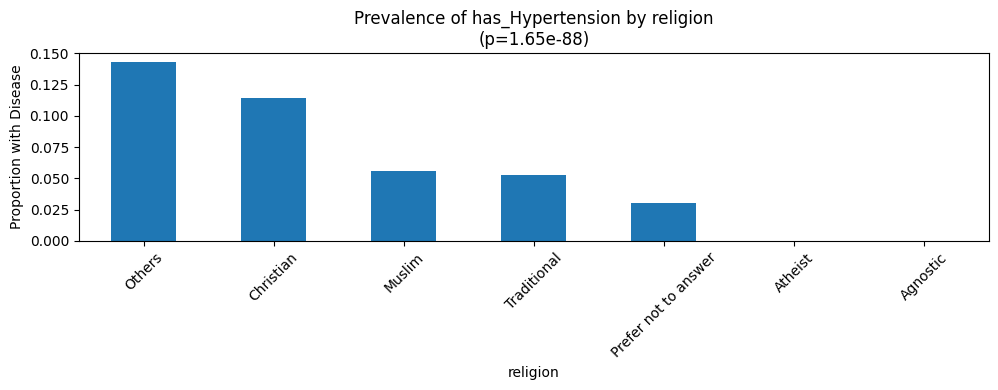


Stratifying has_Hypertension by income...
Chi-squared test p-value: 0.00000


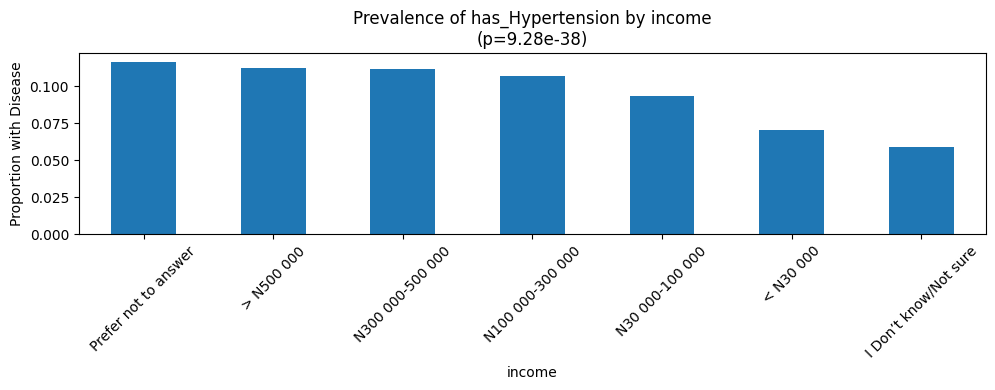


Stratifying has_Type_2_Diabetes by tribe...
Chi-squared test p-value: 0.00000


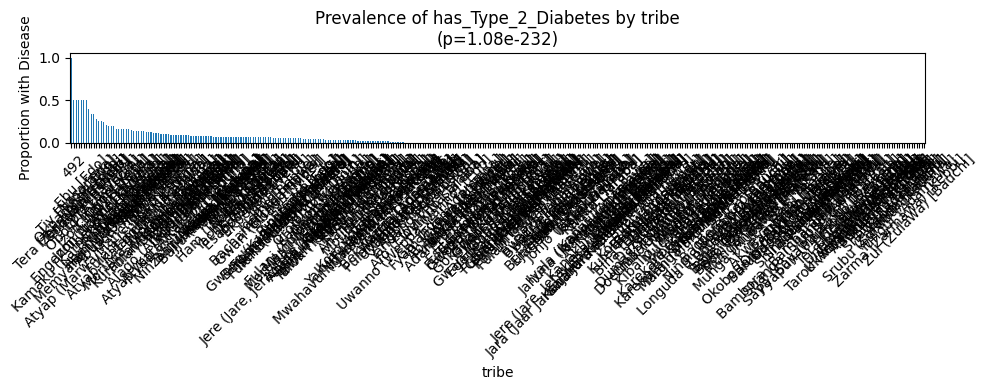


Stratifying has_Type_2_Diabetes by religion...
Chi-squared test p-value: 0.00000


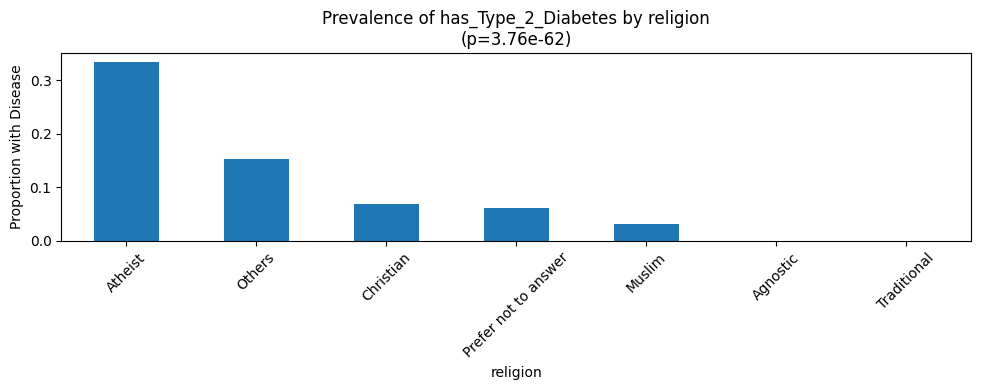


Stratifying has_Type_2_Diabetes by income...
Chi-squared test p-value: 0.00000


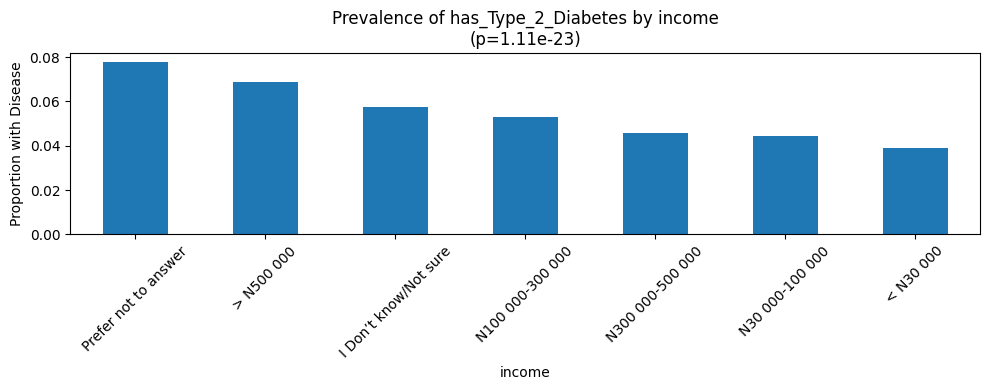


Stratifying has_Hypertensive_heart_disease by tribe...
Chi-squared test p-value: 0.00000


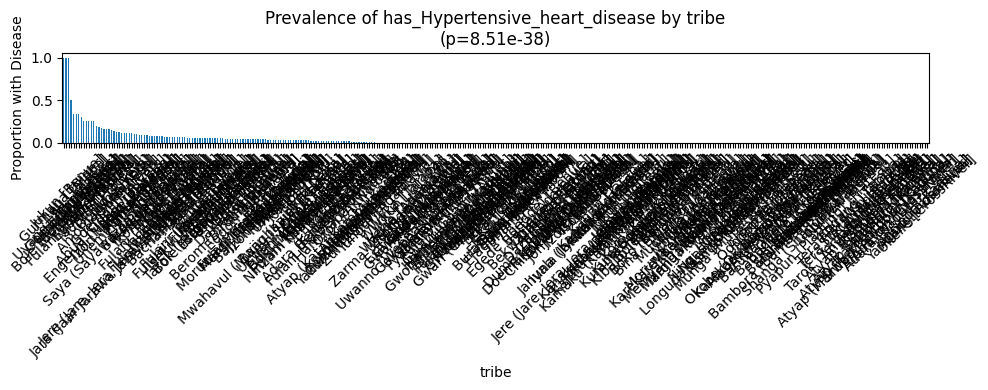


Stratifying has_Hypertensive_heart_disease by religion...
Chi-squared test p-value: 0.30723


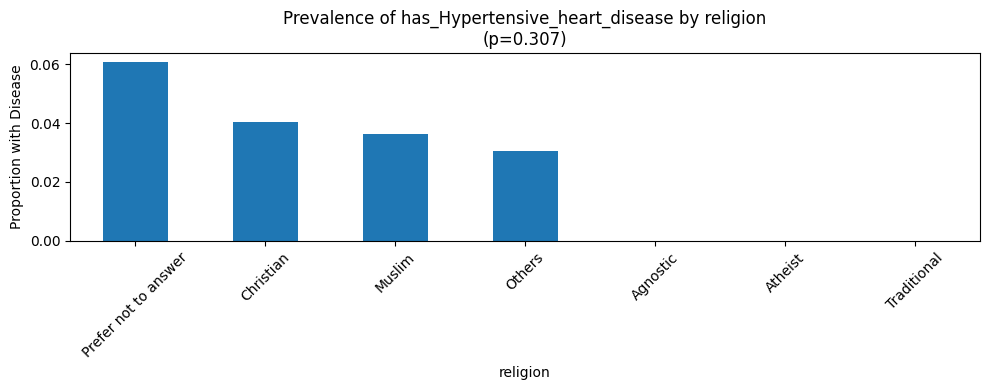


Stratifying has_Hypertensive_heart_disease by income...
Chi-squared test p-value: 0.00000


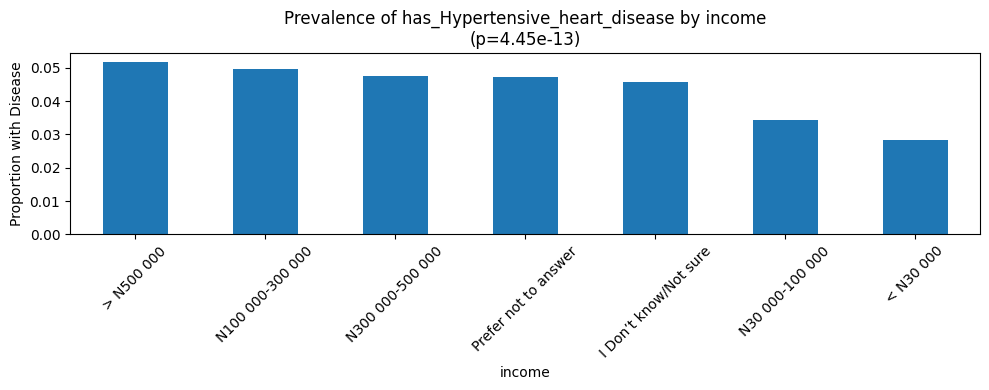


Stratifying has_Type_1_Diabetes by tribe...
Chi-squared test p-value: 0.90645


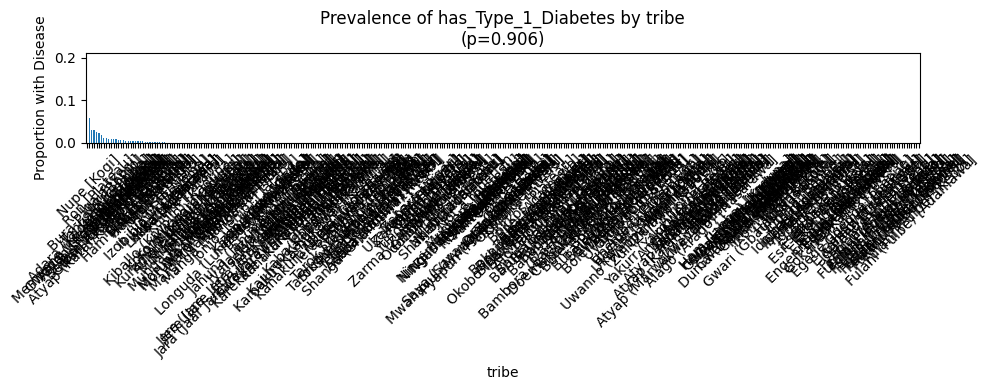


Stratifying has_Type_1_Diabetes by religion...
Chi-squared test p-value: 0.00060


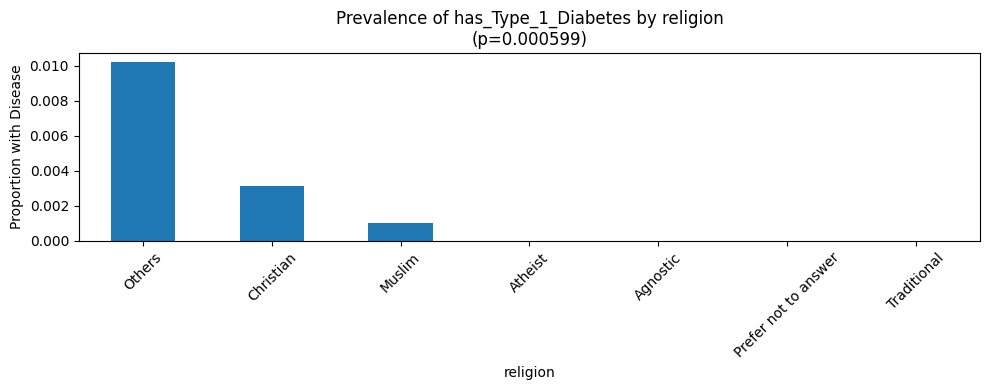


Stratifying has_Type_1_Diabetes by income...
Chi-squared test p-value: 0.09041


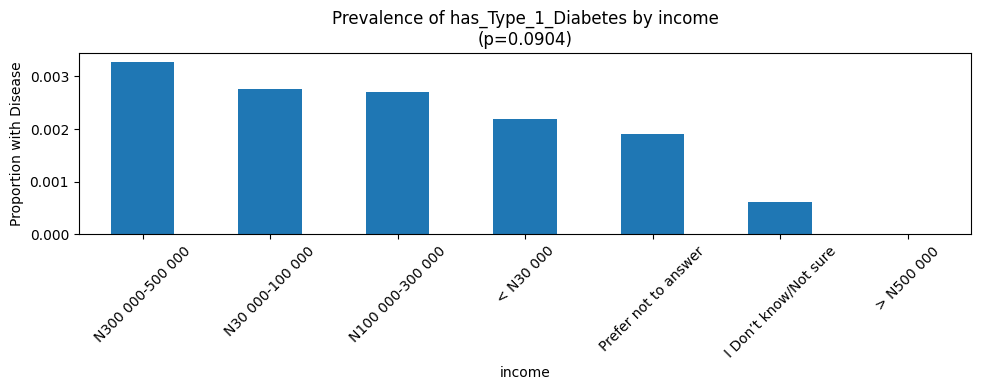


Stratifying has_Asthma by tribe...
Chi-squared test p-value: 0.00000


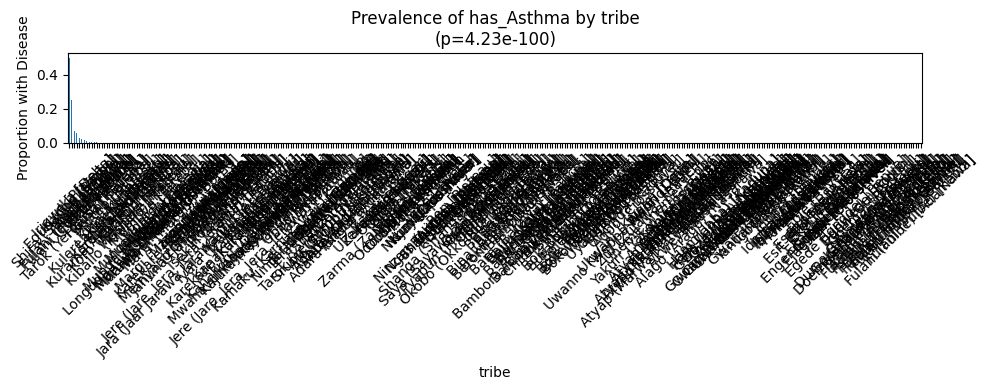


Stratifying has_Asthma by religion...
Chi-squared test p-value: 0.66937


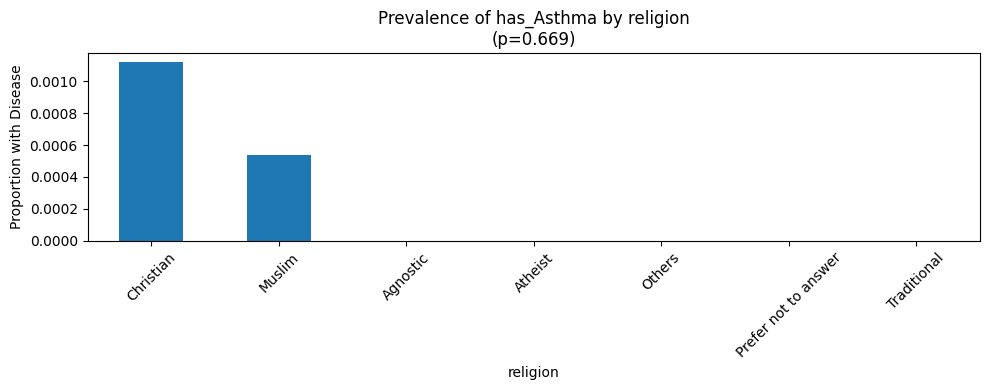


Stratifying has_Asthma by income...
Chi-squared test p-value: 0.73162


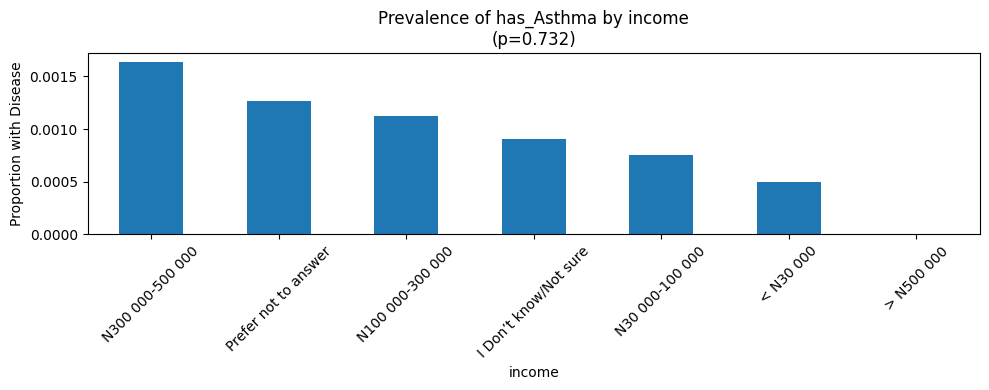


Stratifying has_Epilepsy by tribe...
Chi-squared test p-value: 1.00000


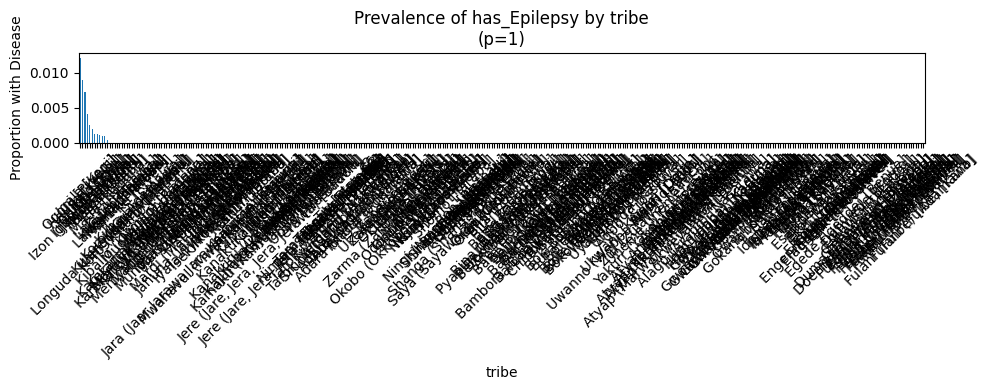


Stratifying has_Epilepsy by religion...
Chi-squared test p-value: 0.00930


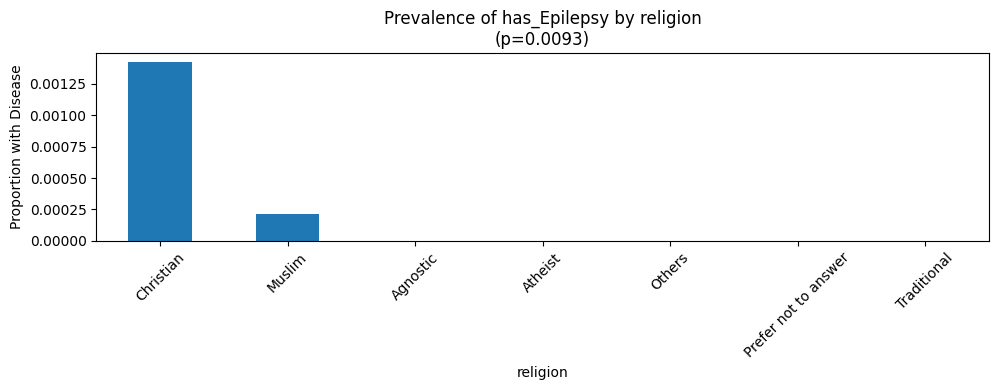


Stratifying has_Epilepsy by income...
Chi-squared test p-value: 0.00000


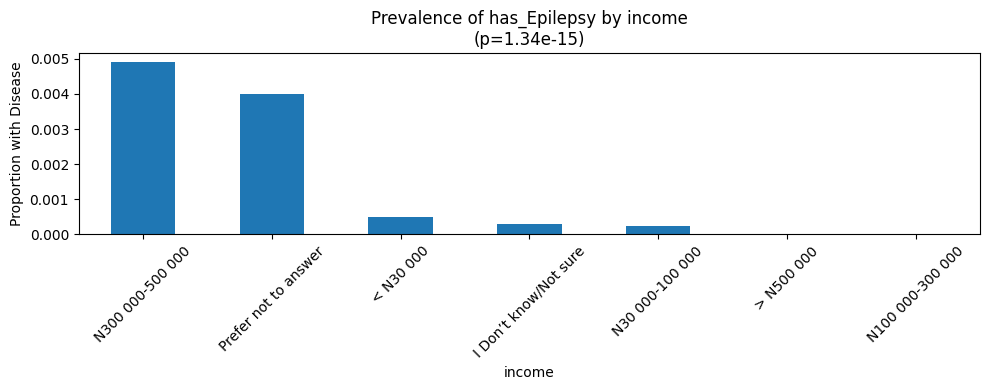


Stratifying has_Chronic_hepatitis by tribe...
Chi-squared test p-value: 0.00000


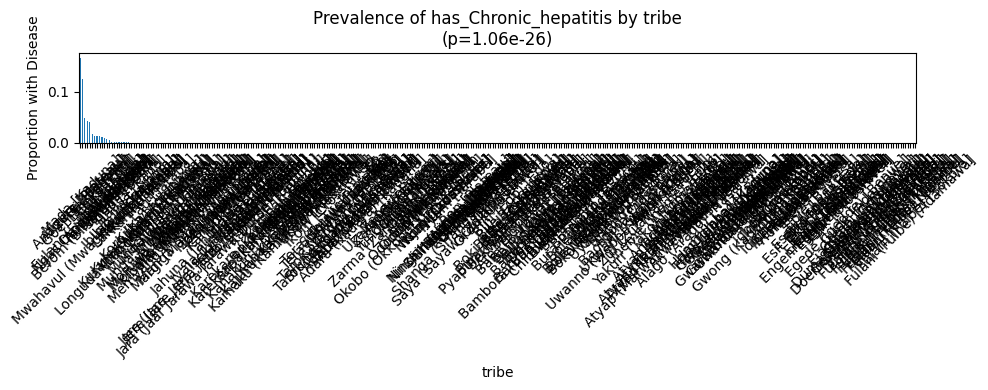


Stratifying has_Chronic_hepatitis by religion...
Chi-squared test p-value: 0.47159


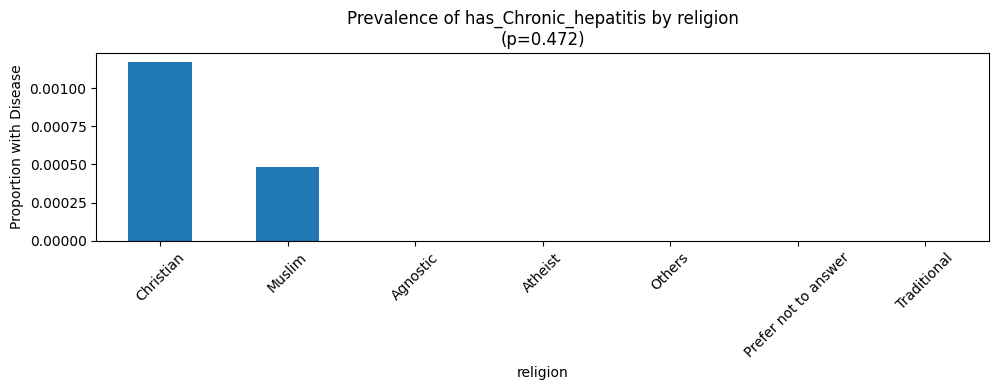


Stratifying has_Chronic_hepatitis by income...
Chi-squared test p-value: 0.03150


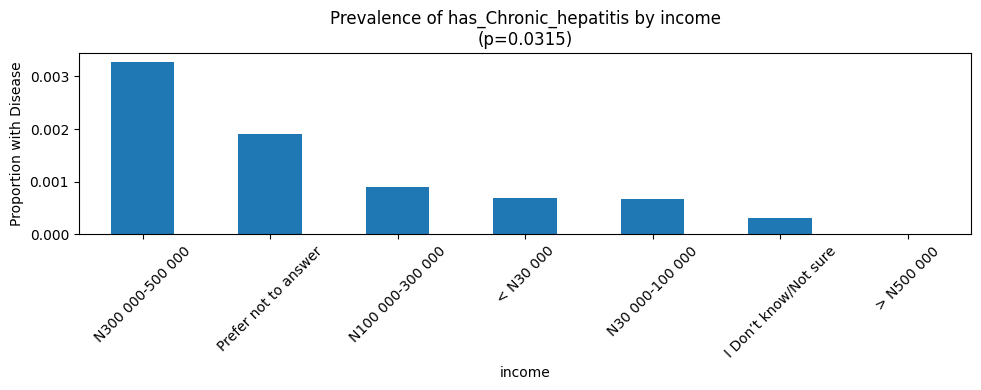

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# === Load Data ===
df = pd.read_csv("/content/phenotype_with_flags.csv")


# === Disease Prevalence Barplot ===
def plot_disease_prevalence(df, disease_flags):
    prevalence = df[disease_flags].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=prevalence.values, y=prevalence.index)
    plt.title("Chronic Disease Prevalence")
    plt.xlabel("Proportion of Individuals")
    plt.tight_layout()
    plt.savefig("fig_disease_prevalence.png")
    plt.show()

# === Comorbidity Heatmap ===
def plot_comorbidity_heatmap(df, disease_flags):
    co_matrix = df[disease_flags].T.dot(df[disease_flags])  # co-occurrence count
    plt.figure(figsize=(8, 6))
    sns.heatmap(co_matrix, annot=True, fmt=".0f", cmap="YlOrBr")
    plt.title("Disease Co-Occurrence Matrix")
    plt.tight_layout()
    plt.savefig("fig_disease_cooccurrence.png")
    plt.show()

# === Stratification by Sociodemographic Variable ===
def stratify_and_test(df, disease_flag, sociodemo_col):
    print(f"\nStratifying {disease_flag} by {sociodemo_col}...")
    summary = df.groupby(sociodemo_col)[disease_flag].agg(['mean', 'count'])
    summary.columns = ['proportion_positive', 'N']
    summary = summary.sort_values('proportion_positive', ascending=False)

    # Create contingency table
    contingency = pd.crosstab(df[sociodemo_col], df[disease_flag])

    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-squared test p-value: {p:.5f}")

    # Plot
    summary['proportion_positive'].plot(kind="bar", figsize=(10, 4))
    plt.title(f"Prevalence of {disease_flag} by {sociodemo_col}\n(p={p:.3g})")
    plt.ylabel("Proportion with Disease")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"fig_{disease_flag}_by_{sociodemo_col}.png")
    plt.show()

    # Save to CSV
    summary.to_csv(f"table_{disease_flag}_by_{sociodemo_col}.csv")

    return summary, p

# === Main Pipeline Execution ===
if __name__ == "__main__":
    # Load phenotype with disease flags
    df_clean = pd.read_csv("/content/phenotype_with_flags.csv", low_memory=False)

    # Dynamically detect disease flags
    disease_flags = [col for col in df_clean.columns if col.startswith("has_")]
    sociodemo_fields = ['tribe', 'religion', 'income']

    print(f"Detected disease flags: {disease_flags}")

    # Step 1: Disease Prevalence
    plot_disease_prevalence(df_clean, disease_flags)

    # Step 2: Comorbidity Matrix
    plot_comorbidity_heatmap(df_clean, disease_flags)

    # Step 3: Stratification + Chi-squared per sociodemographic field
    for disease in disease_flags:
        for demo in sociodemo_fields:
            try:
                stratify_and_test(df_clean, disease, demo)
            except Exception as e:
                print(f" Failed stratification for {disease} by {demo}: {e}")


/tmp/ipython-input-32-4203989278.py:9: DtypeWarning: Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/phenotype_with_flags.csv")


Detected disease flags: ['has_Hypertension', 'has_Type_2_Diabetes', 'has_Hypertensive_heart_disease', 'has_Type_1_Diabetes', 'has_Asthma', 'has_Epilepsy', 'has_Chronic_hepatitis']


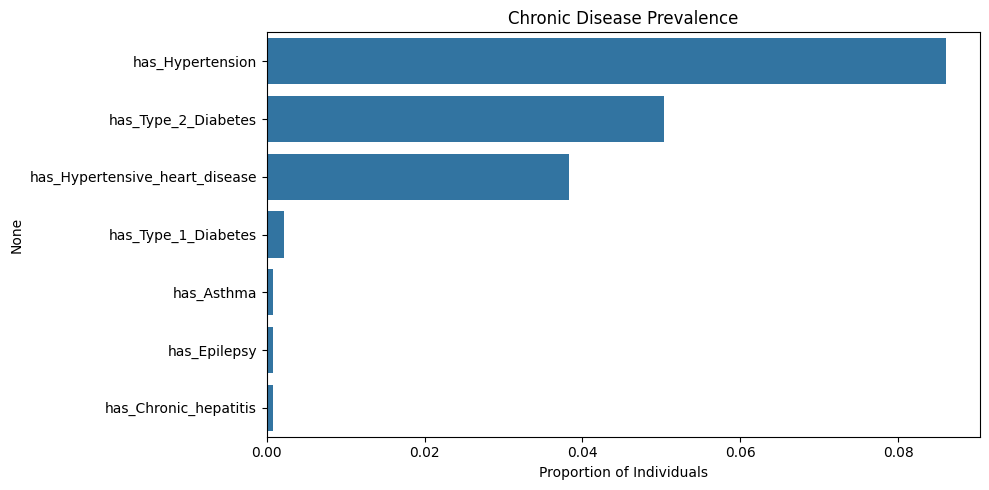

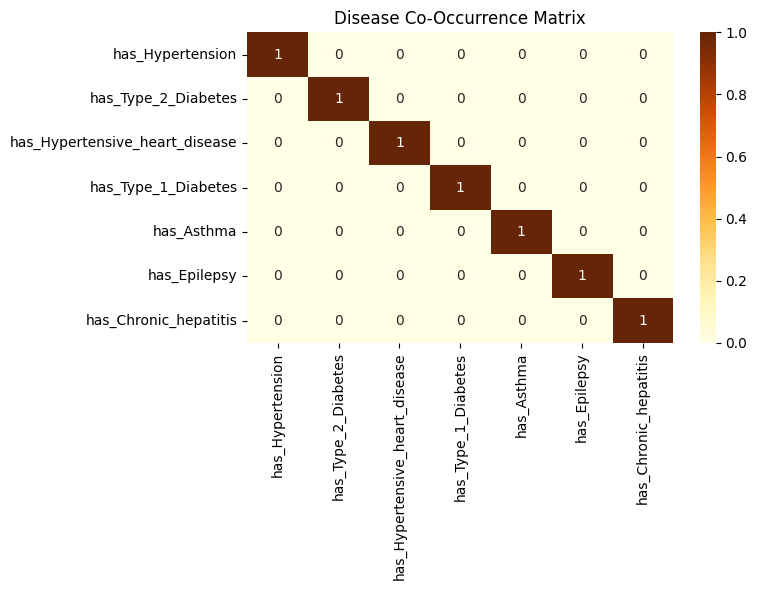


Stratifying has_Hypertension by tribe...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Hypertension_by_tribe.png


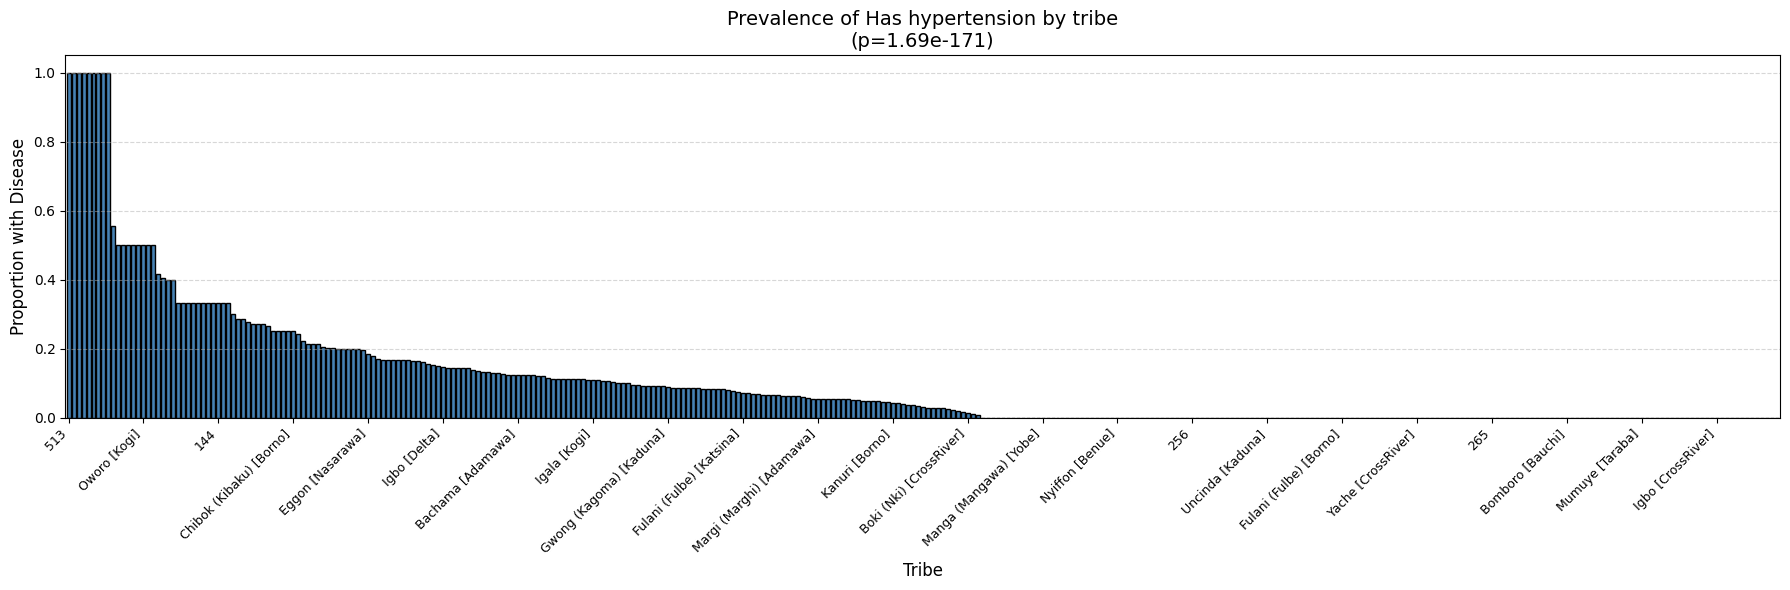


Stratifying has_Hypertension by religion...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Hypertension_by_religion.png


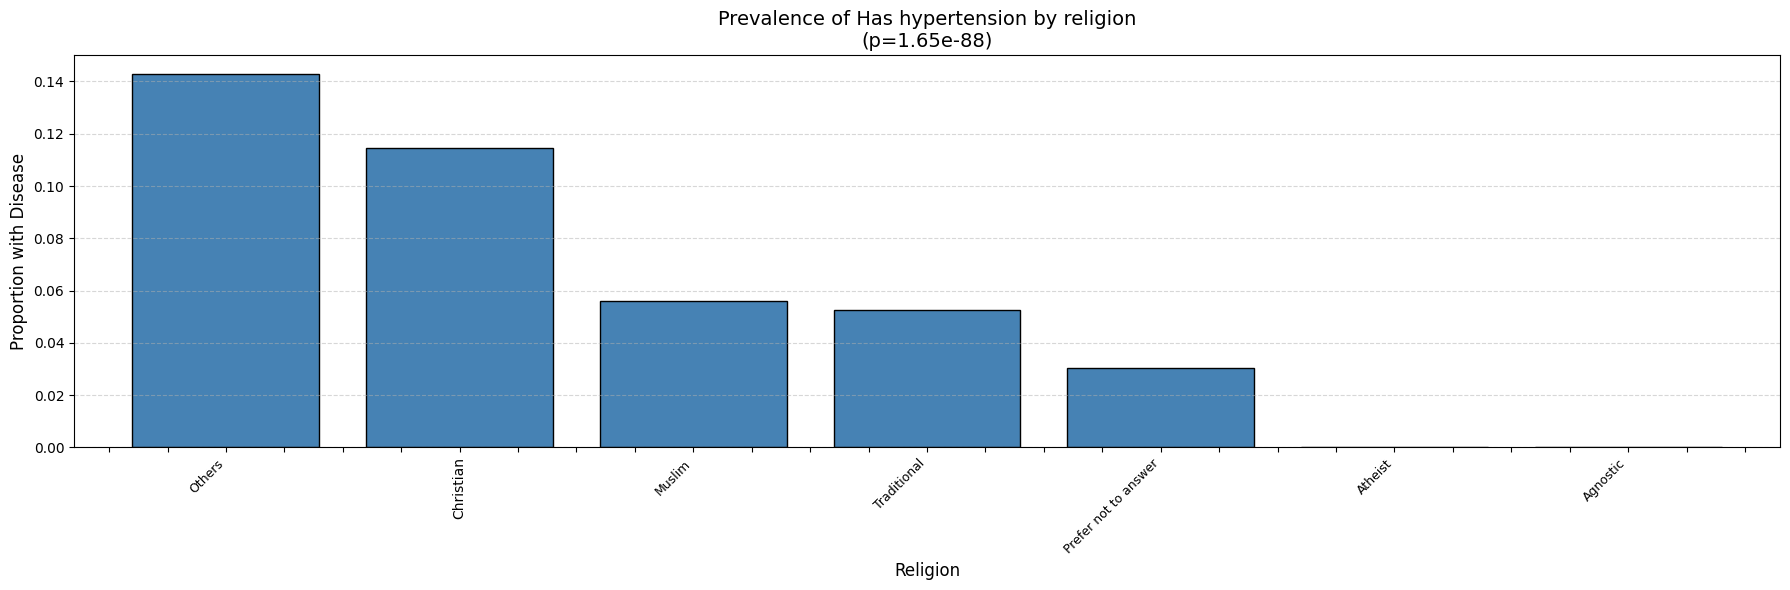


Stratifying has_Hypertension by income...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Hypertension_by_income.png


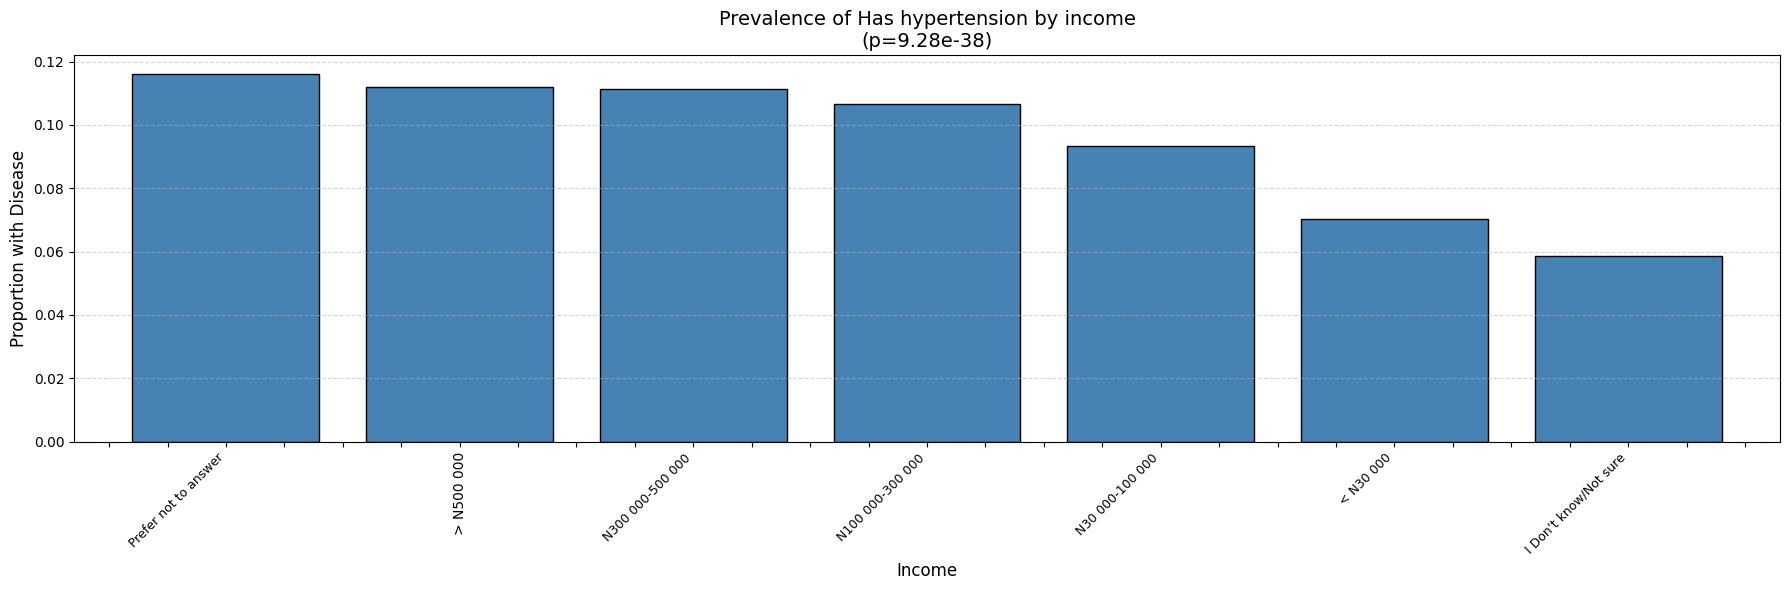


Stratifying has_Type_2_Diabetes by tribe...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Type_2_Diabetes_by_tribe.png


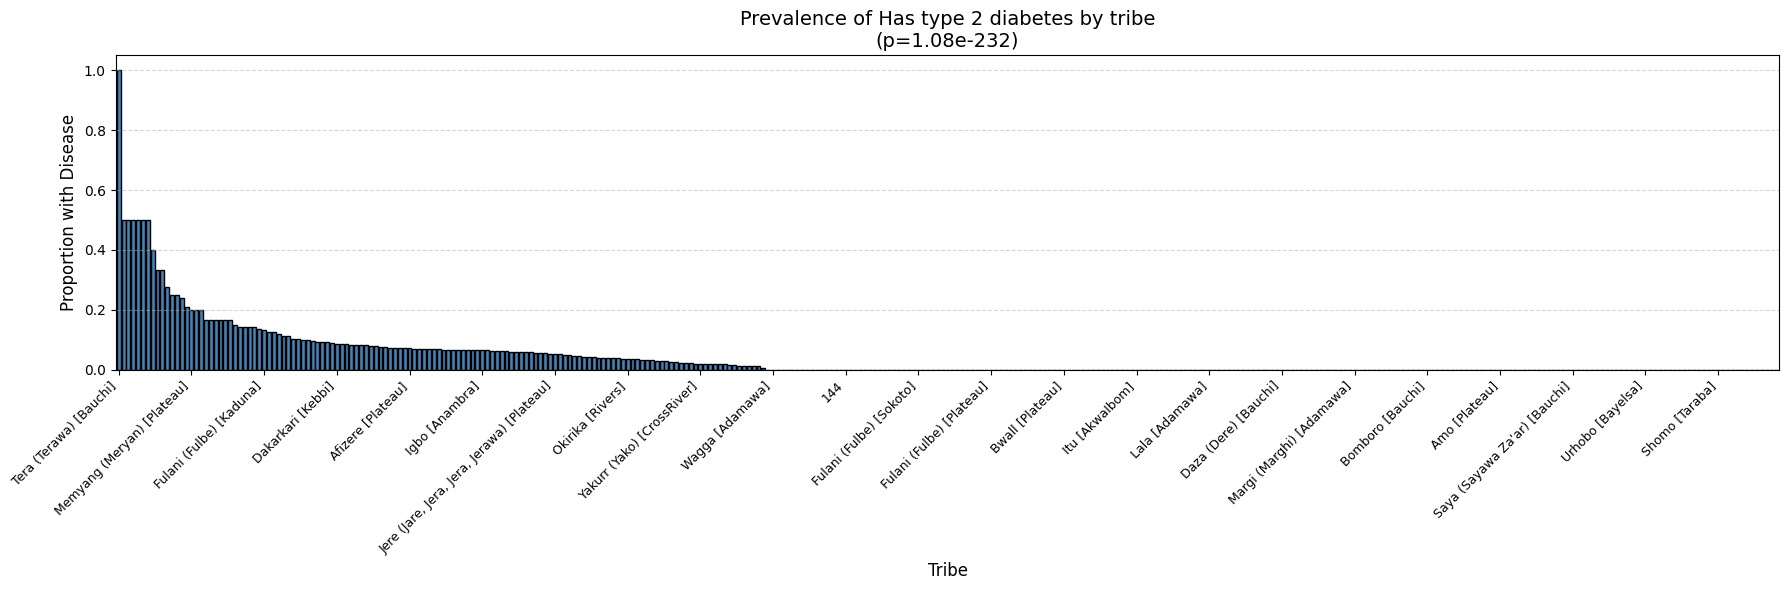


Stratifying has_Type_2_Diabetes by religion...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Type_2_Diabetes_by_religion.png


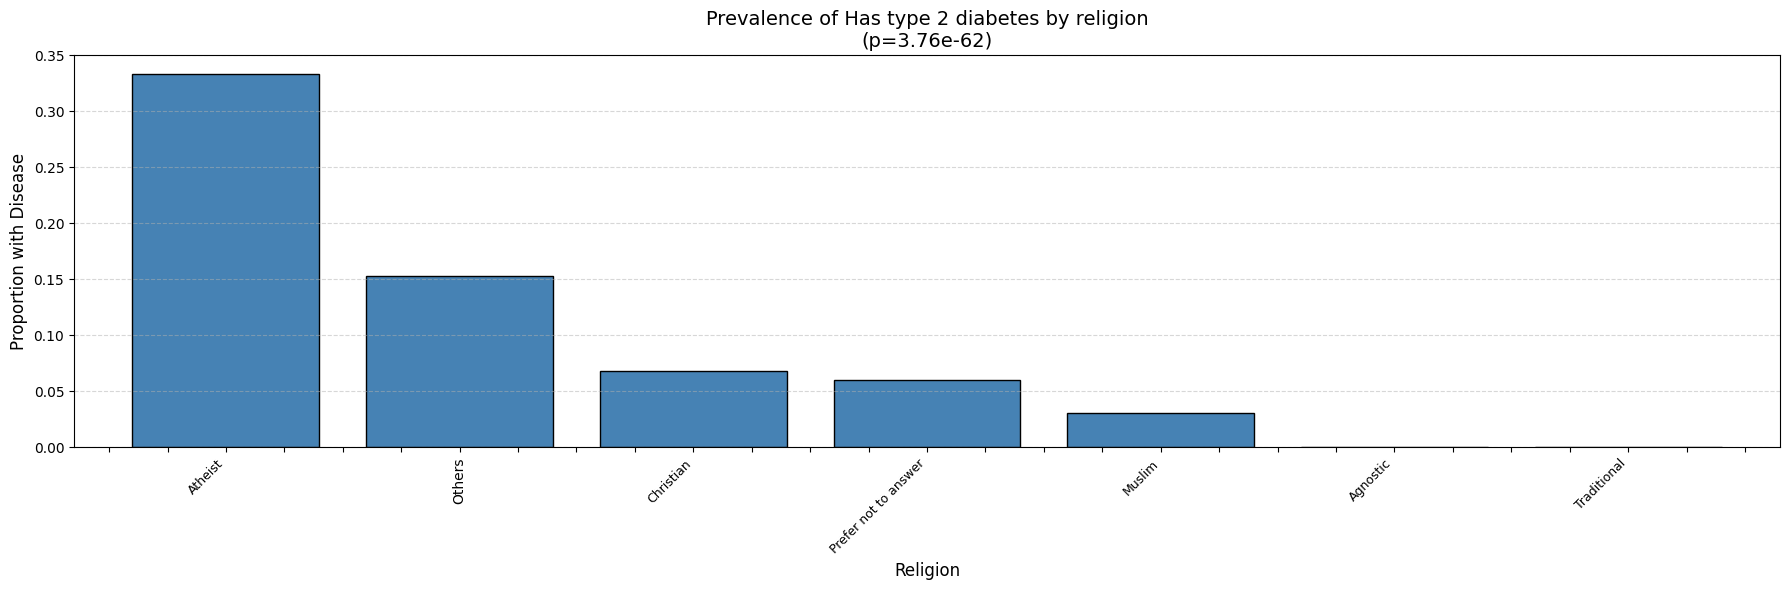


Stratifying has_Type_2_Diabetes by income...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Type_2_Diabetes_by_income.png


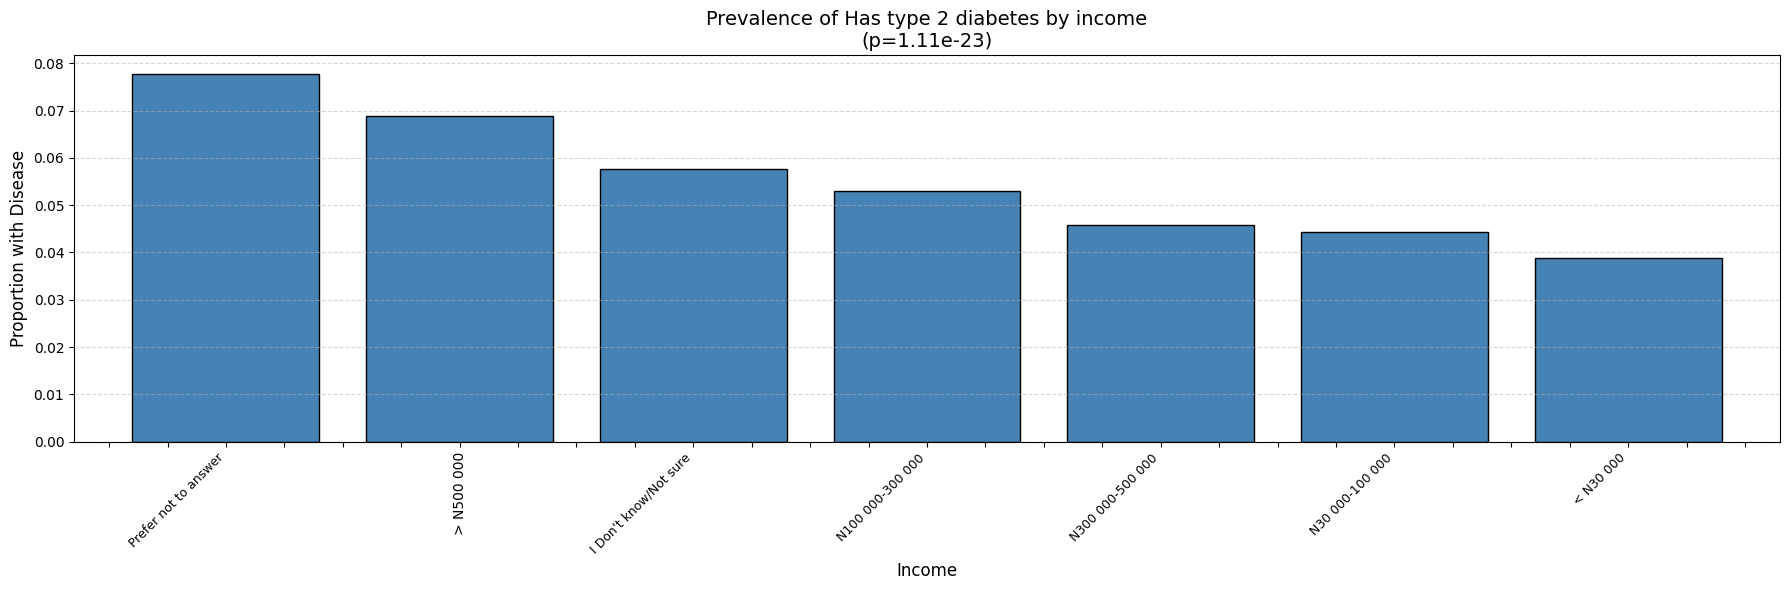


Stratifying has_Hypertensive_heart_disease by tribe...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Hypertensive_heart_disease_by_tribe.png


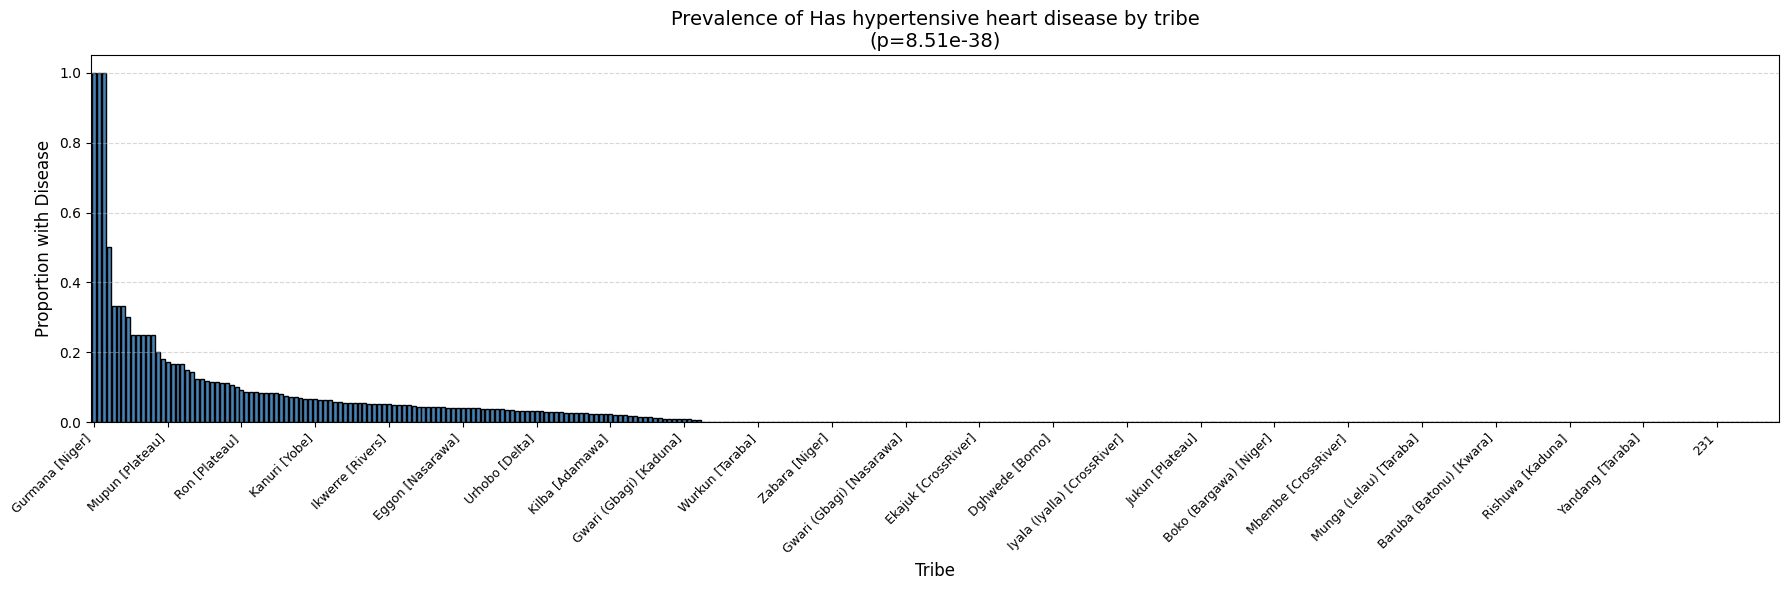


Stratifying has_Hypertensive_heart_disease by religion...
Chi-squared test p-value: 0.30723
[✓] Saved plot to fig_has_Hypertensive_heart_disease_by_religion.png


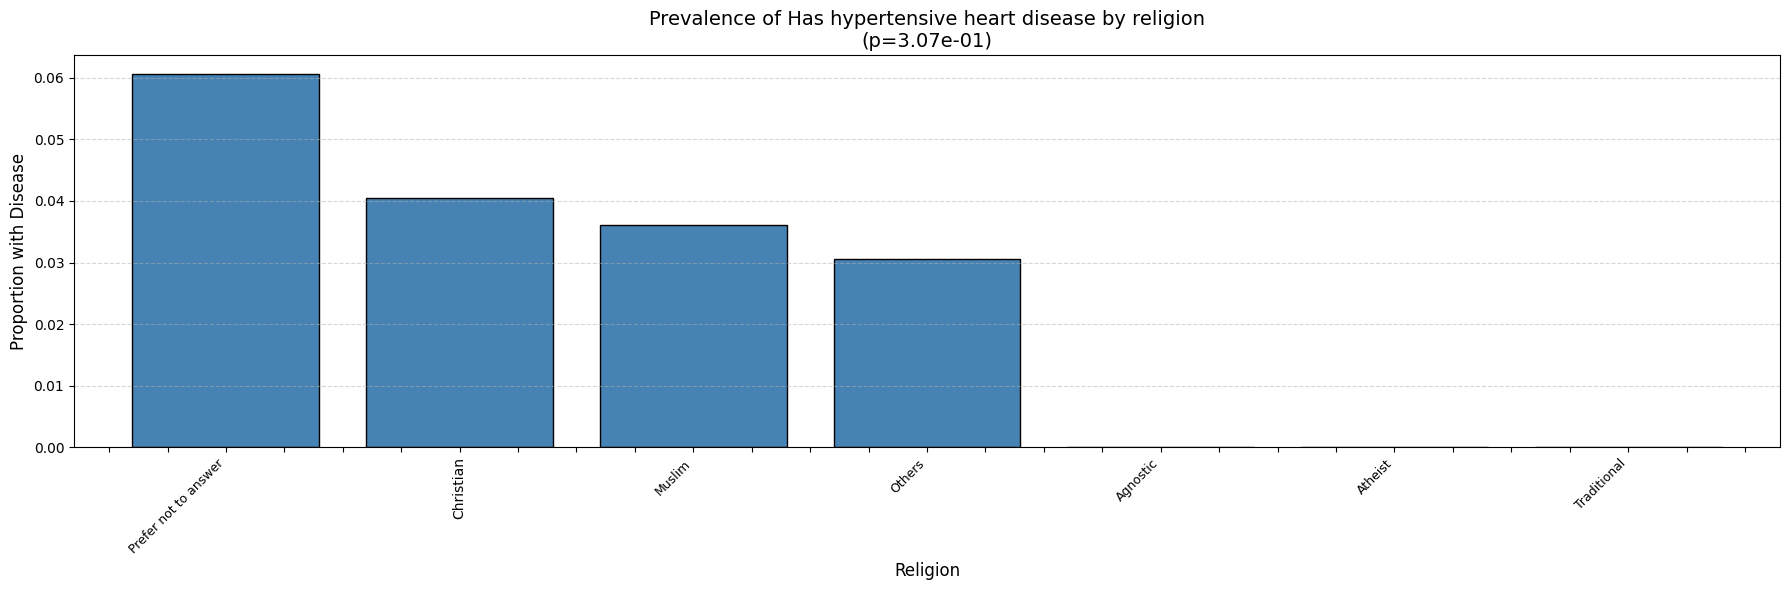


Stratifying has_Hypertensive_heart_disease by income...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Hypertensive_heart_disease_by_income.png


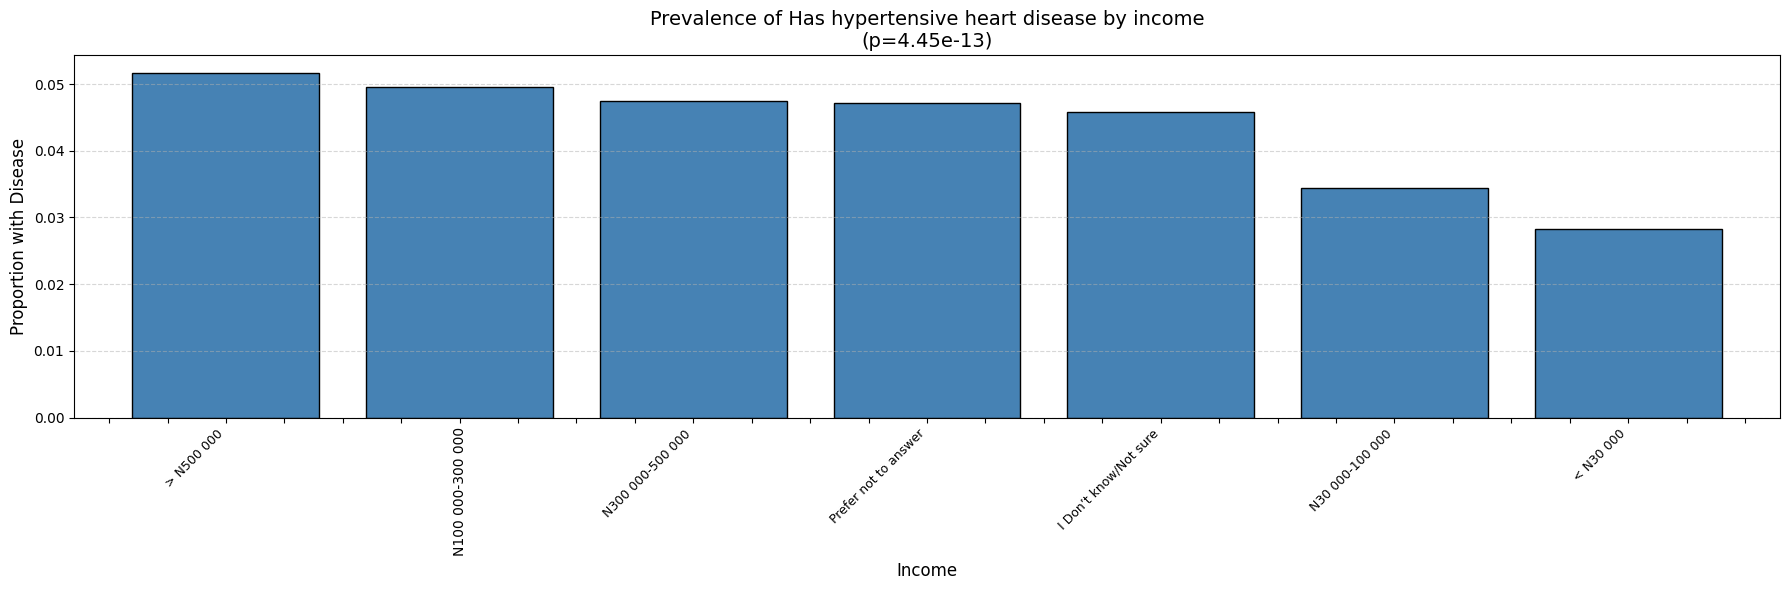


Stratifying has_Type_1_Diabetes by tribe...
Chi-squared test p-value: 0.90645
[✓] Saved plot to fig_has_Type_1_Diabetes_by_tribe.png


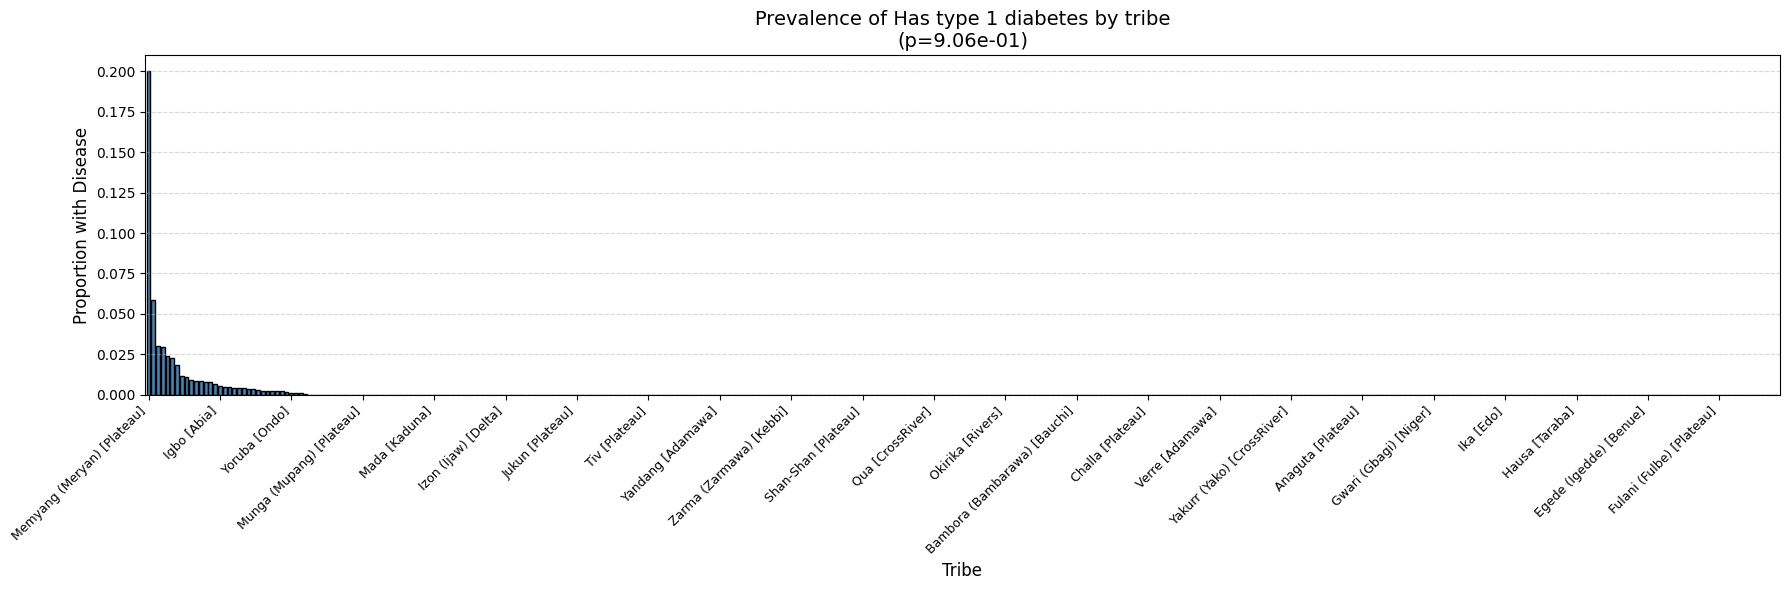


Stratifying has_Type_1_Diabetes by religion...
Chi-squared test p-value: 0.00060
[✓] Saved plot to fig_has_Type_1_Diabetes_by_religion.png


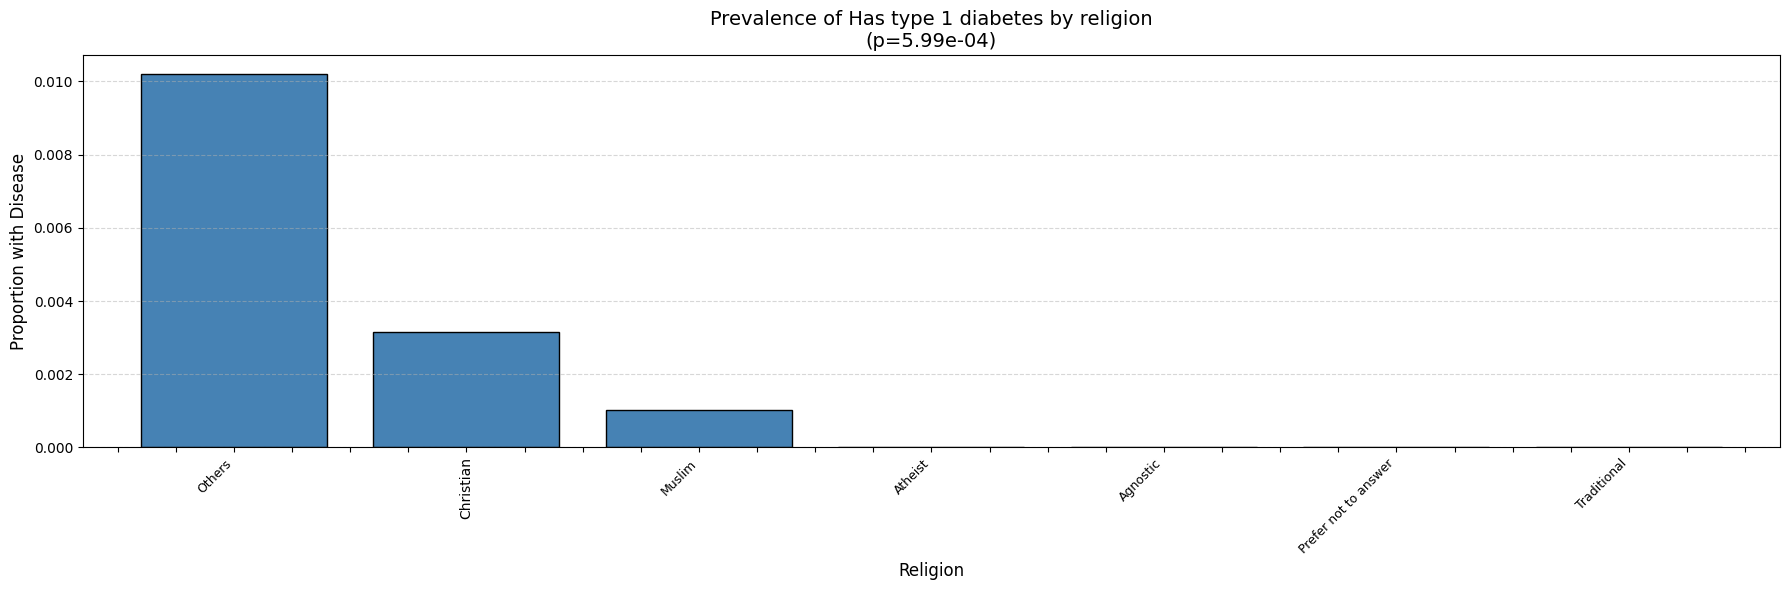


Stratifying has_Type_1_Diabetes by income...
Chi-squared test p-value: 0.09041
[✓] Saved plot to fig_has_Type_1_Diabetes_by_income.png


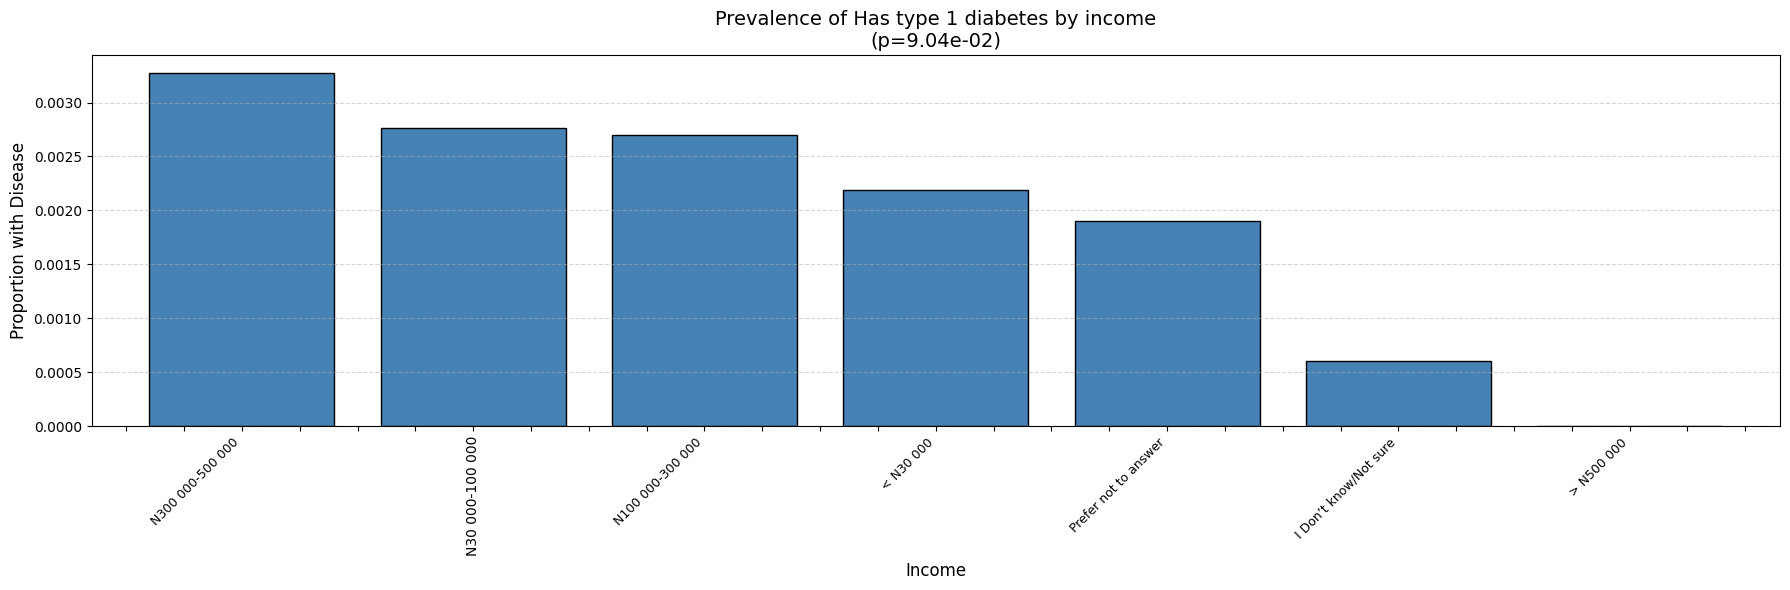


Stratifying has_Asthma by tribe...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Asthma_by_tribe.png


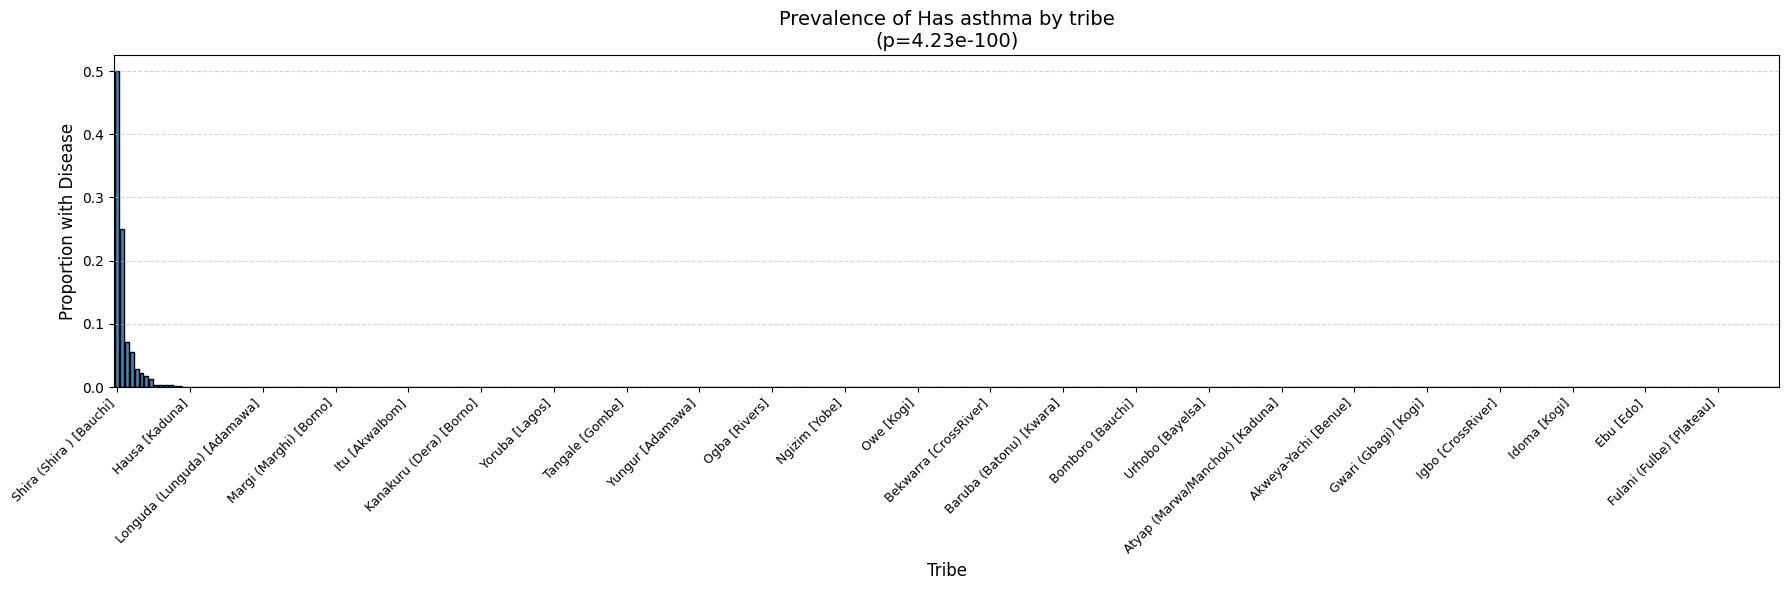


Stratifying has_Asthma by religion...
Chi-squared test p-value: 0.66937
[✓] Saved plot to fig_has_Asthma_by_religion.png


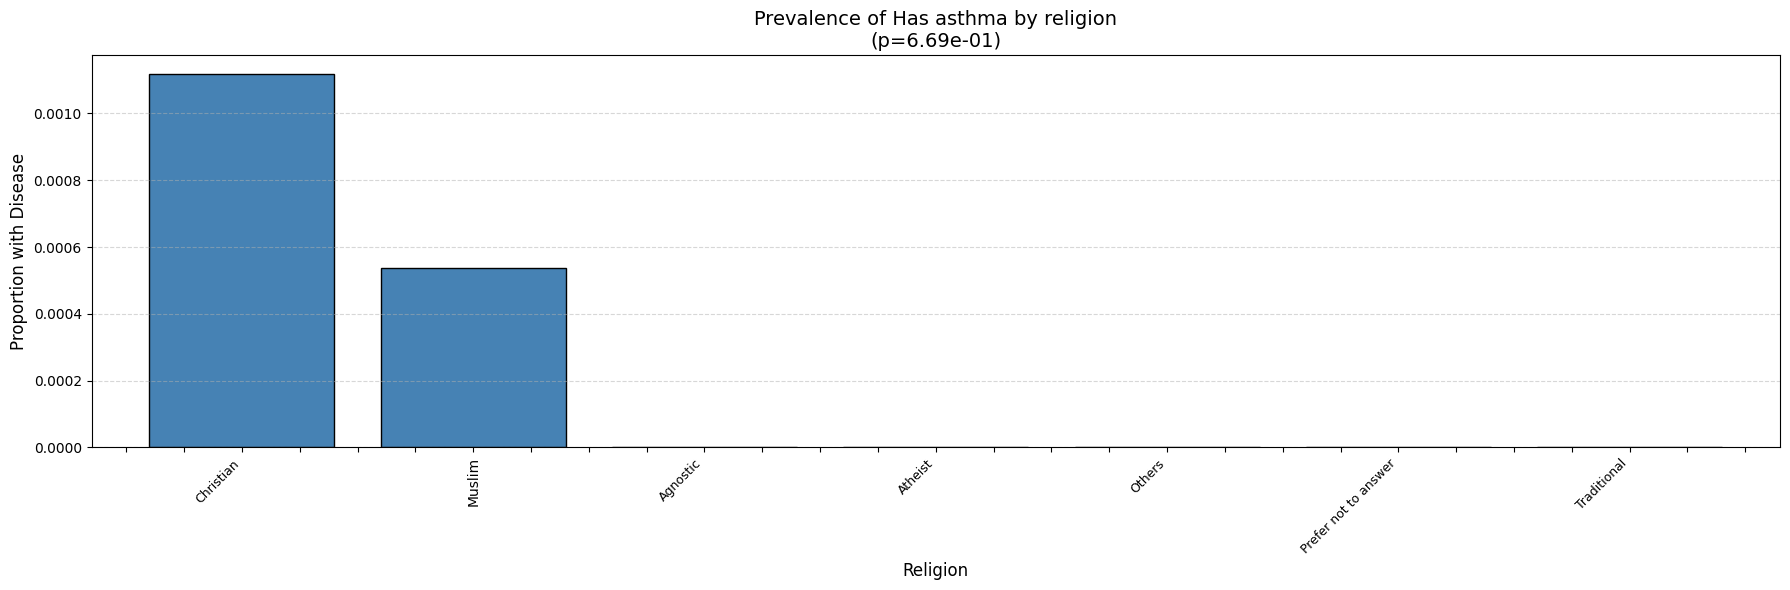


Stratifying has_Asthma by income...
Chi-squared test p-value: 0.73162
[✓] Saved plot to fig_has_Asthma_by_income.png


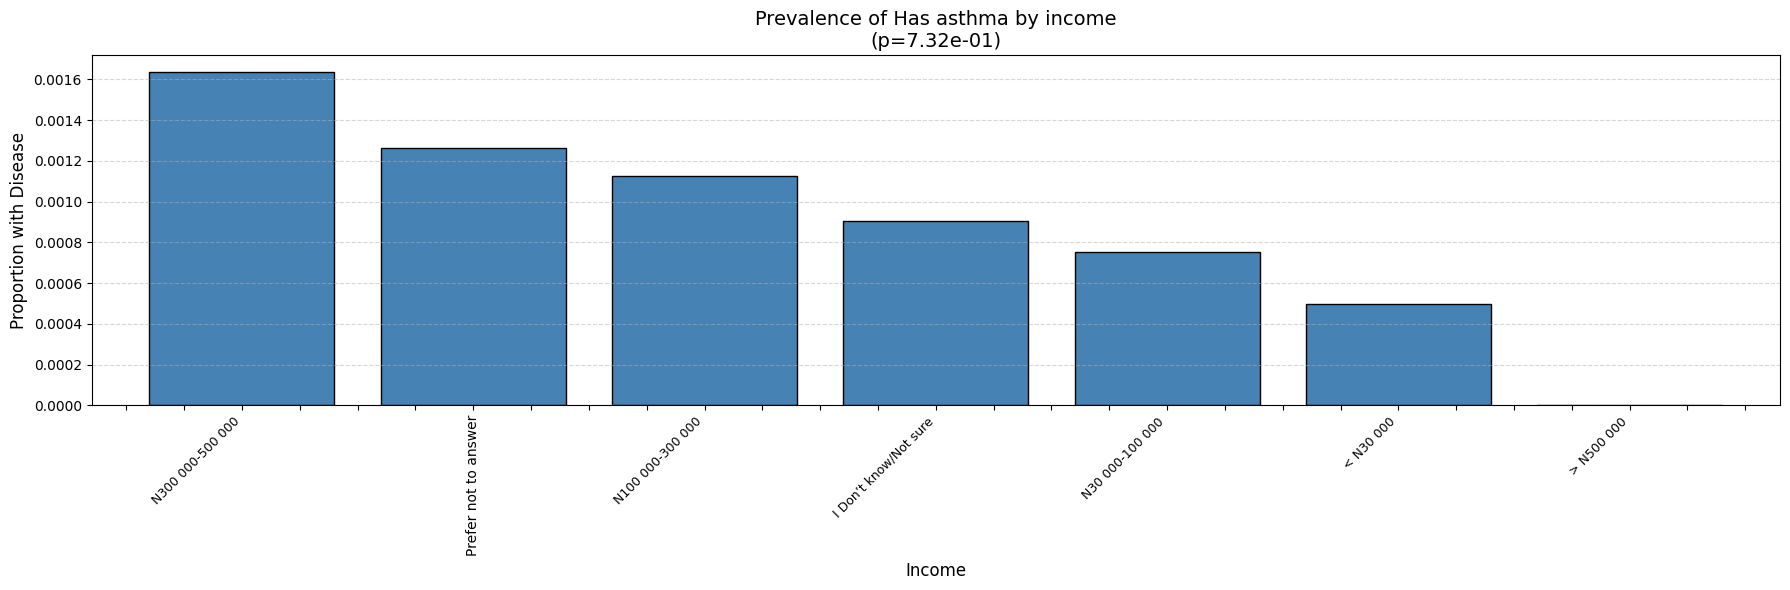


Stratifying has_Epilepsy by tribe...
Chi-squared test p-value: 1.00000
[✓] Saved plot to fig_has_Epilepsy_by_tribe.png


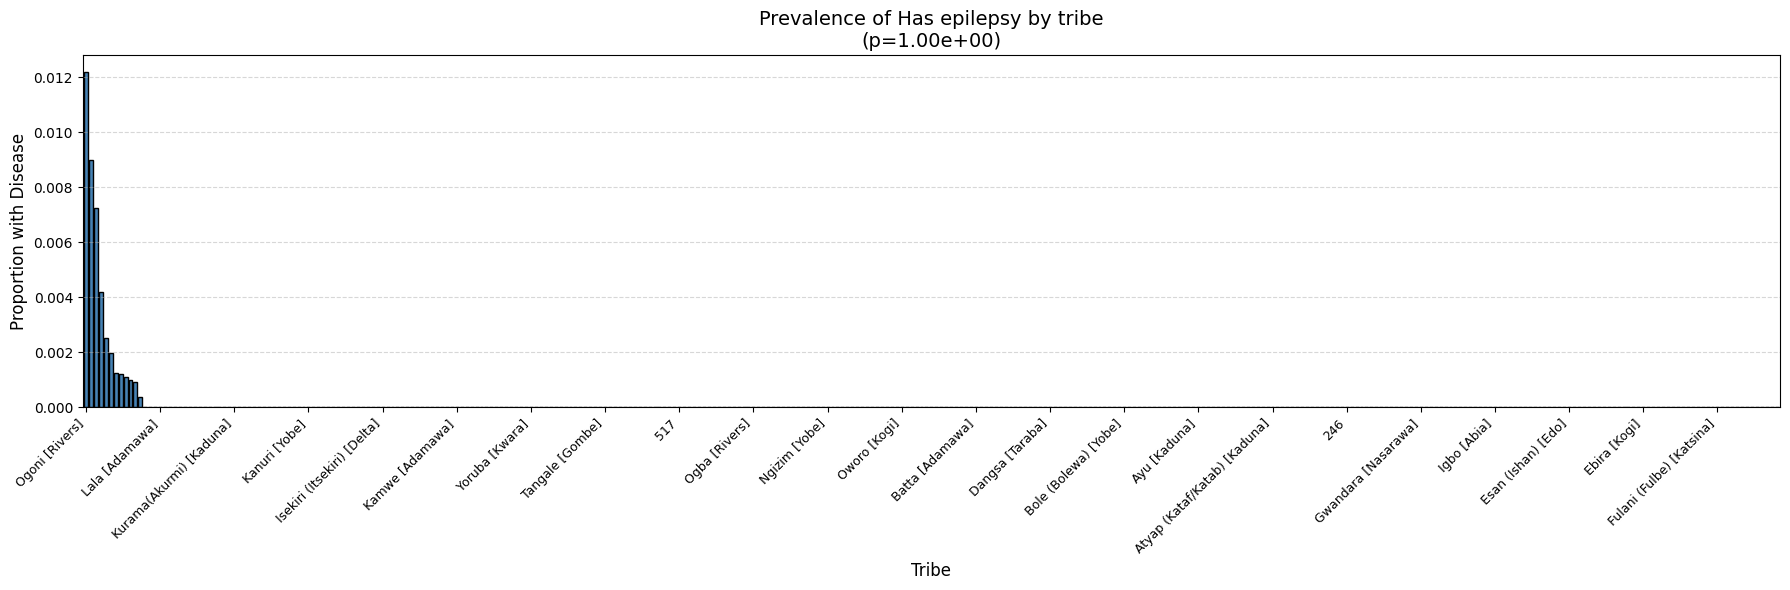


Stratifying has_Epilepsy by religion...
Chi-squared test p-value: 0.00930
[✓] Saved plot to fig_has_Epilepsy_by_religion.png


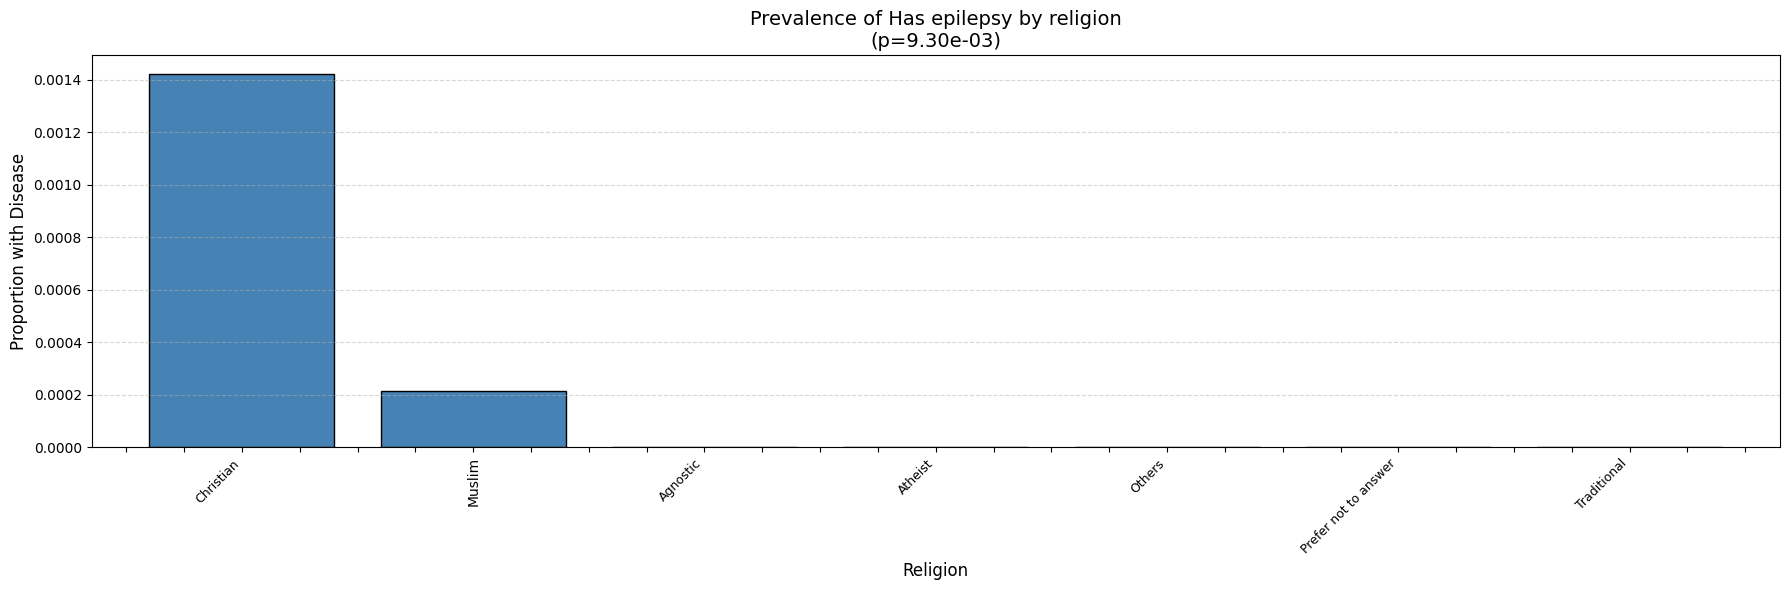


Stratifying has_Epilepsy by income...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Epilepsy_by_income.png


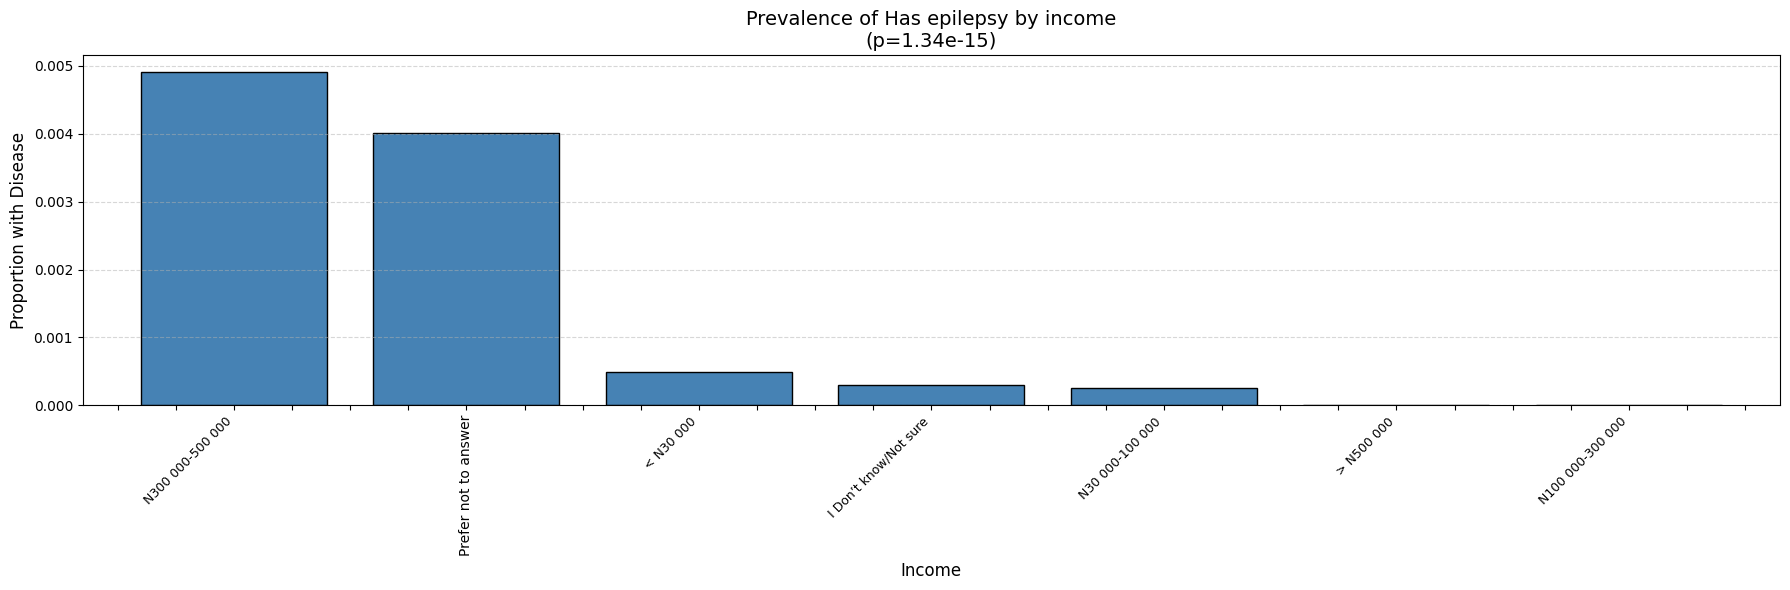


Stratifying has_Chronic_hepatitis by tribe...
Chi-squared test p-value: 0.00000
[✓] Saved plot to fig_has_Chronic_hepatitis_by_tribe.png


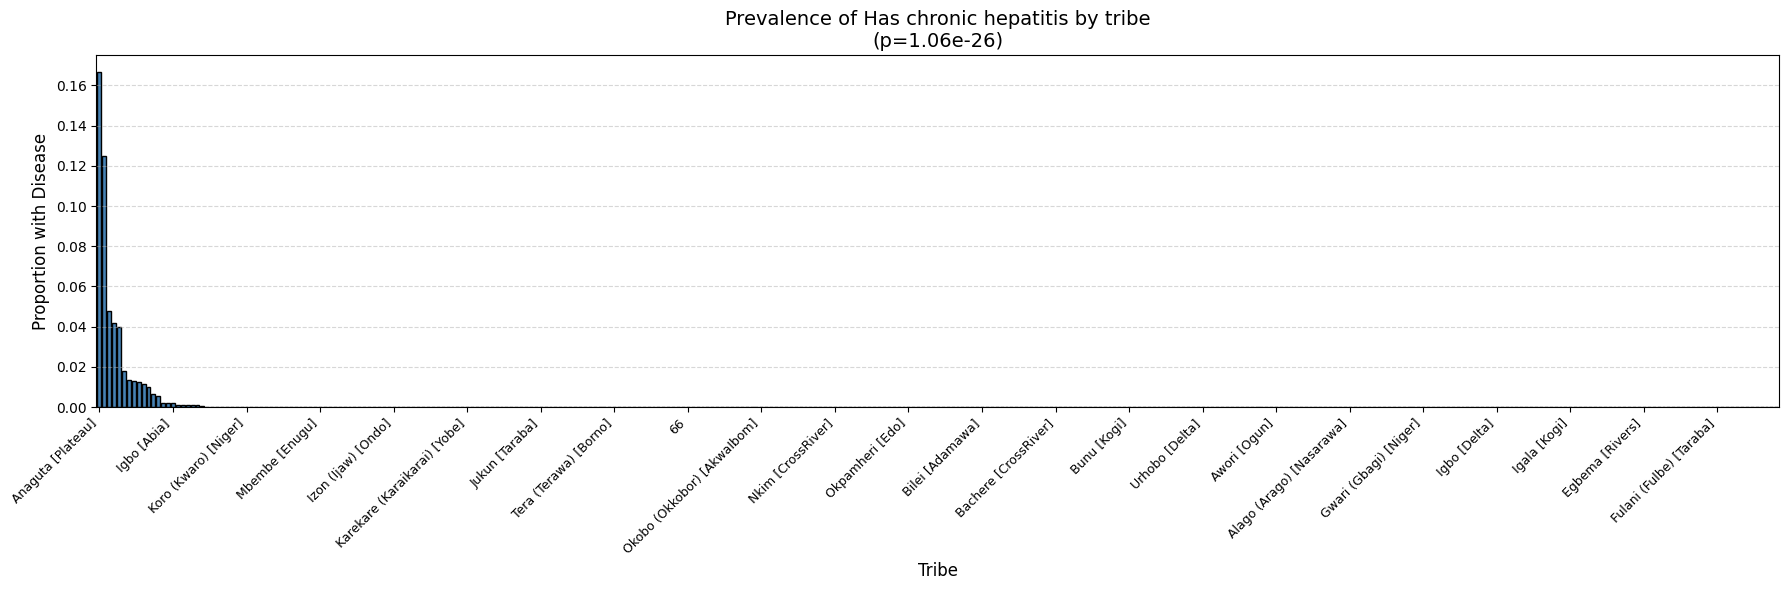


Stratifying has_Chronic_hepatitis by religion...
Chi-squared test p-value: 0.47159
[✓] Saved plot to fig_has_Chronic_hepatitis_by_religion.png


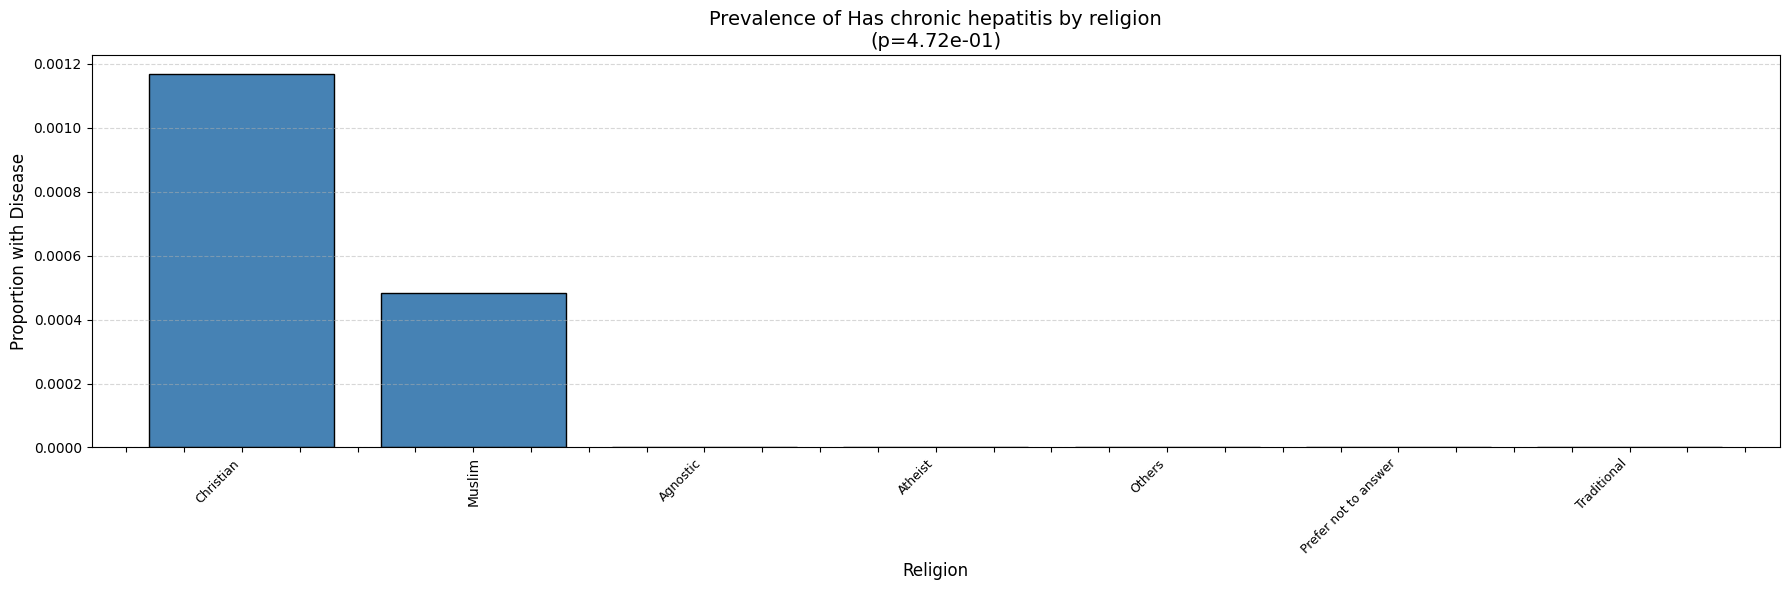


Stratifying has_Chronic_hepatitis by income...
Chi-squared test p-value: 0.03150
[✓] Saved plot to fig_has_Chronic_hepatitis_by_income.png


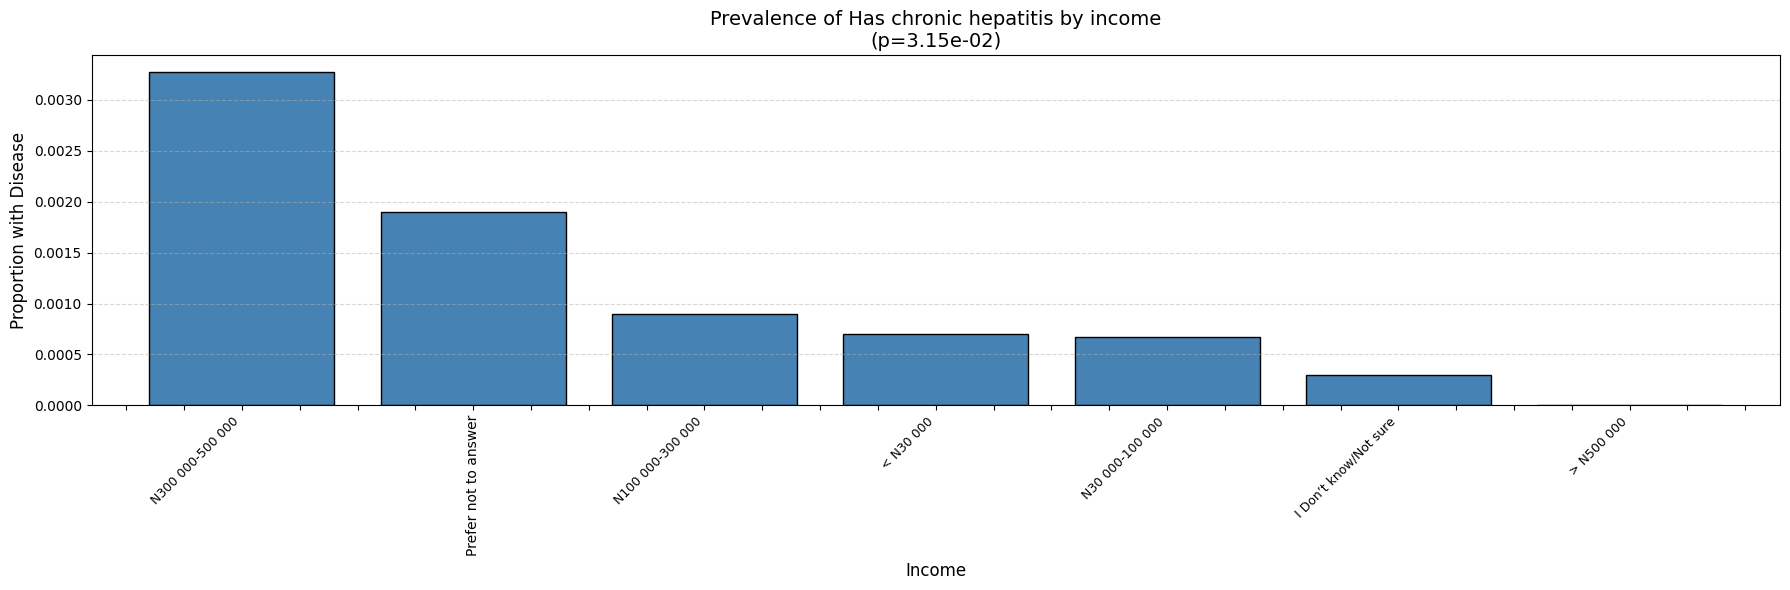

In [ ]:
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# === Load Data ===
df = pd.read_csv("/content/phenotype_with_flags.csv")


# === Disease Prevalence Barplot ===
def plot_disease_prevalence(df, disease_flags):
    prevalence = df[disease_flags].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=prevalence.values, y=prevalence.index)
    plt.title("Chronic Disease Prevalence")
    plt.xlabel("Proportion of Individuals")
    plt.tight_layout()
    plt.savefig("fig_disease_prevalence.png")
    plt.show()

# === Comorbidity Heatmap ===
def plot_comorbidity_heatmap(df, disease_flags):
    co_matrix = df[disease_flags].T.dot(df[disease_flags])  # co-occurrence count
    plt.figure(figsize=(8, 6))
    sns.heatmap(co_matrix, annot=True, fmt=".0f", cmap="YlOrBr")
    plt.title("Disease Co-Occurrence Matrix")
    plt.tight_layout()
    plt.savefig("fig_disease_cooccurrence.png")
    plt.show()

def stratify_and_test(df, disease_flag, sociodemo_col):
    print(f"\nStratifying {disease_flag} by {sociodemo_col}...")
    summary = df.groupby(sociodemo_col)[disease_flag].agg(['mean', 'count'])
    summary.columns = ['proportion_positive', 'N']
    summary = summary.sort_values('proportion_positive', ascending=False)

    # Create contingency table
    contingency = pd.crosstab(df[sociodemo_col], df[disease_flag])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-squared test p-value: {p:.5f}")

    # === PLOT SETTINGS ===
    plt.figure(figsize=(18, 6))  # Wider plot to accommodate long labels
    ax = summary['proportion_positive'].plot(
        kind="bar", width=0.8, color="steelblue", edgecolor='black'
    )

    plt.title(f"Prevalence of {disease_flag.replace('_', ' ').capitalize()} by {sociodemo_col}\n(p={p:.2e})", fontsize=14)
    plt.ylabel("Proportion with Disease", fontsize=12)
    plt.xlabel(sociodemo_col.capitalize(), fontsize=12)

    # Improve tick label readability
    plt.xticks(rotation=45, ha='right', fontsize=9)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit number of ticks

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Save and show
    filename = f"fig_{disease_flag}_by_{sociodemo_col}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"[✓] Saved plot to {filename}")
    plt.show()

    # Save table
    summary.to_csv(f"table_{disease_flag}_by_{sociodemo_col}.csv")

    return summary, p

# === Main Pipeline Execution ===
if __name__ == "__main__":
    # Load phenotype with disease flags
    df_clean = pd.read_csv("/content/phenotype_with_flags.csv", low_memory=False)

    # Dynamically detect disease flags
    disease_flags = [col for col in df_clean.columns if col.startswith("has_")]
    sociodemo_fields = ['tribe', 'religion', 'income']

    print(f"Detected disease flags: {disease_flags}")

    # Step 1: Disease Prevalence
    plot_disease_prevalence(df_clean, disease_flags)

    # Step 2: Comorbidity Matrix
    plot_comorbidity_heatmap(df_clean, disease_flags)

    # Step 3: Stratification + Chi-squared per sociodemographic field
    for disease in disease_flags:
        for demo in sociodemo_fields:
            try:
                stratify_and_test(df_clean, disease, demo)
            except Exception as e:
                print(f" Failed stratification for {disease} by {demo}: {e}")


#  Disease Prevalence, Comorbidity, and Sociodemographic Stratification Analysis

This pipeline analyzes chronic disease prevalence, co-occurrence, and sociodemographic disparities from a phenotype dataset with ICD-10 derived disease flags.

---

##  Data Input

```python
df = pd.read_csv("/content/phenotype_with_flags.csv")
```

- Loads a phenotype dataset previously augmented with binary disease flags (e.g., has_Hypertension).

- Assumes a cleaned CSV with participant-level variables and binary indicators for diseases.

## Disease Prevalence Barplot

```python
def plot_disease_prevalence(df, disease_flags):
    prevalence = df[disease_flags].mean().sort_values(ascending=False)
    ...
```

### Purpose:
- Visualizes the proportion of individuals affected by each chronic condition.

- Uses barplot (horizontal) to show most common diseases first.

### Output:
- fig_disease_prevalence.png: Proportion barplot sorted by prevalence.

## Disease Co-Occurrence Heatmap

```python
def plot_comorbidity_heatmap(df, disease_flags):
    co_matrix = df[disease_flags].T.dot(df[disease_flags])
    ...
```

### Purpose:
- Computes a co-occurrence matrix (e.g., how many people have both Diabetes and Hypertension).

Highlights comorbidity clusters.

### How It Works:
- Matrix multiplication T.dot(...) gives pairwise co-flag counts.

### Output:
- fig_disease_cooccurrence.png: Annotated heatmap showing how frequently diseases co-occur.

## Stratified Disease Prevalence + Chi-Squared Testing

```python
def stratify_and_test(df, disease_flag, sociodemo_col):
    ...
    chi2, p, dof, expected = chi2_contingency(contingency)
    ...
```

### Purpose:
- For each disease and each sociodemographic variable (e.g., tribe, religion, income):

- Computes prevalence within subgroups.

- Tests statistical association via Chi-squared test.

- Plots barplots of prevalence by subgroup.

### Output:
- fig_<disease_flag>_by_<sociodemo_col>.png: Stratified barplot.

- table_<disease_flag>_by_<sociodemo_col>.csv: Table with counts and proportions.

- Chi-squared p-value printed in console for significance evaluation.

## Main Pipeline Execution
```python
if __name__ == "__main__":
    ...

```

## Workflow:
- Load cleaned phenotype data.

- Detect all binary disease flags.

## Generate:

- Prevalence barplot across entire cohort.

- Disease co-occurrence heatmap.

- Stratified barplots for each disease across tribe, religion, income.

- Chi-squared test to check significance of stratified differences.

## Relevance to Project
This pipeline is central to:

- Quantifying health disparities across Nigerian ethnic and religious subgroups.

- Identifying comorbidity clusters relevant for multimorbidity modeling.

- Providing visual + statistical evidence to support precision public health interventions in:

“AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations.”

In [ ]:
pip install umap-learn

/tmp/ipython-input-75-2716694372.py:20: DtypeWarning: Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loaded data with shape: (38518, 167)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too sma

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9630

    accuracy                           1.00      9630
   macro avg       1.00      1.00      1.00      9630
weighted avg       1.00      1.00      1.00      9630



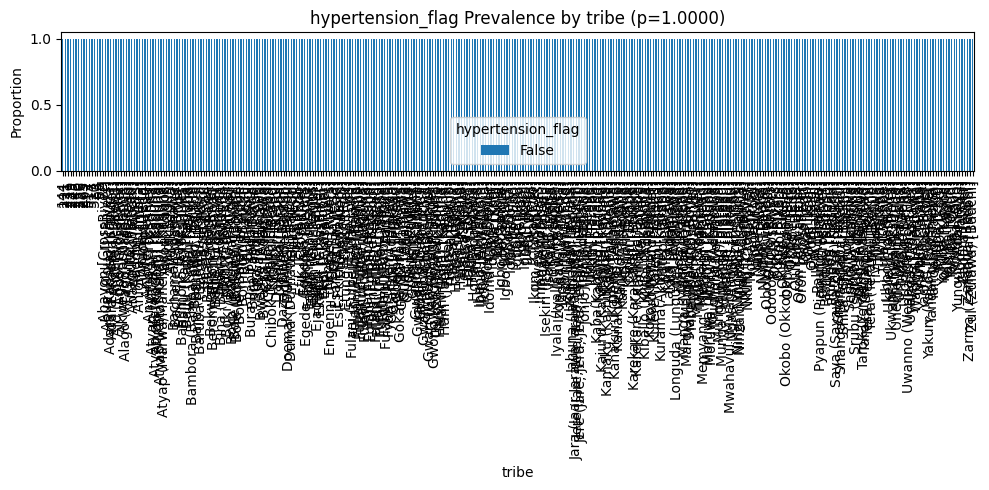

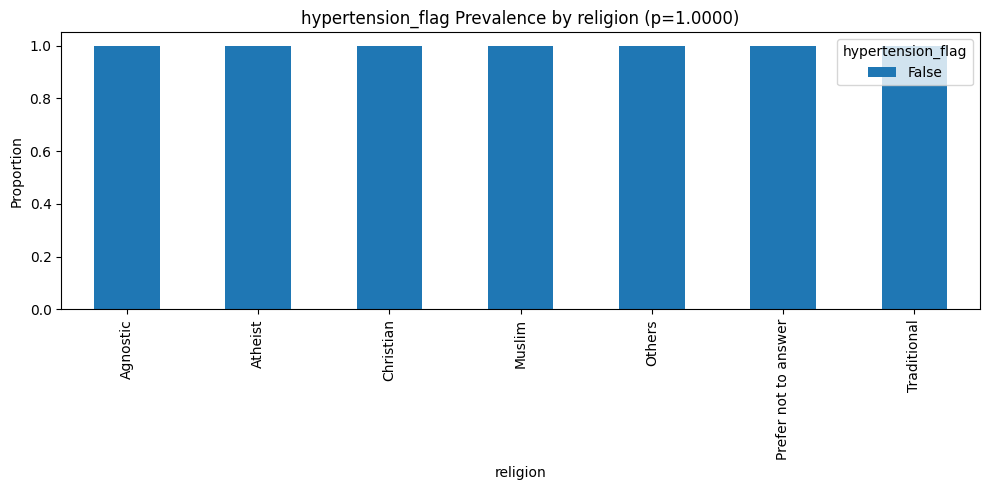

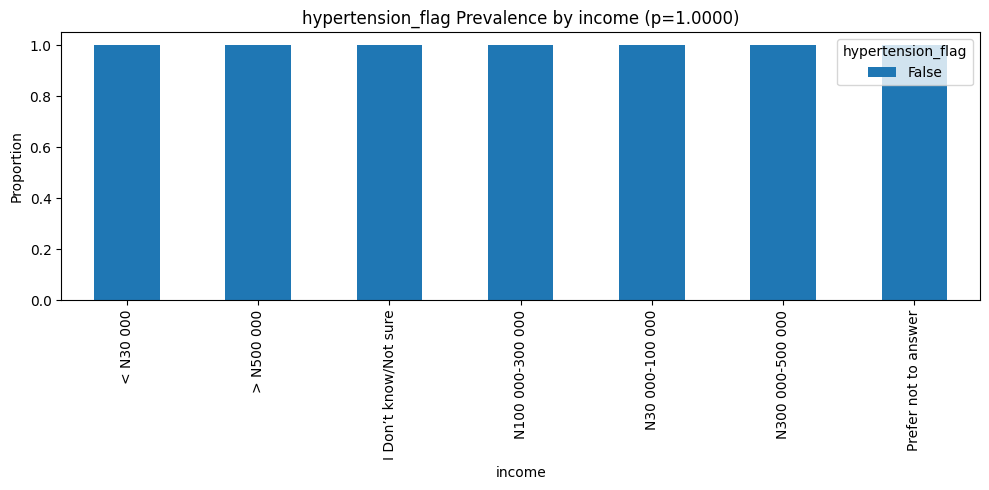

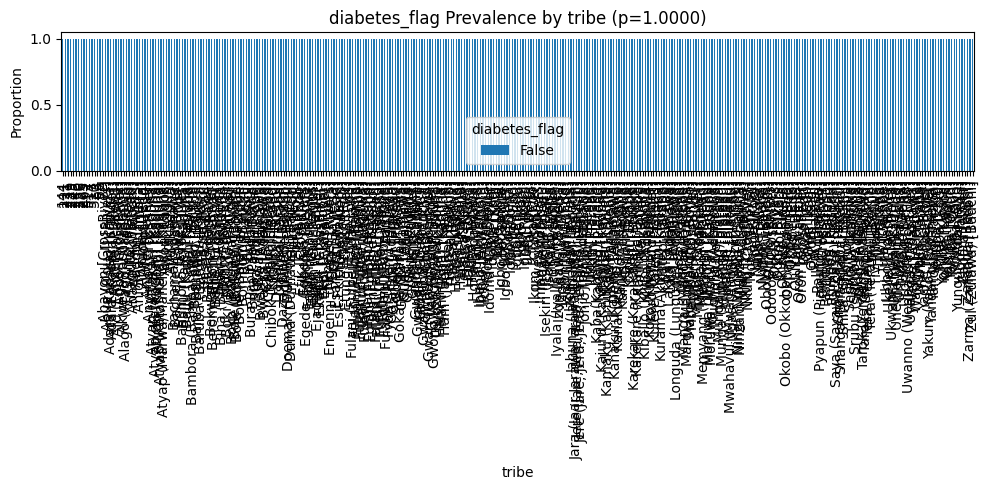

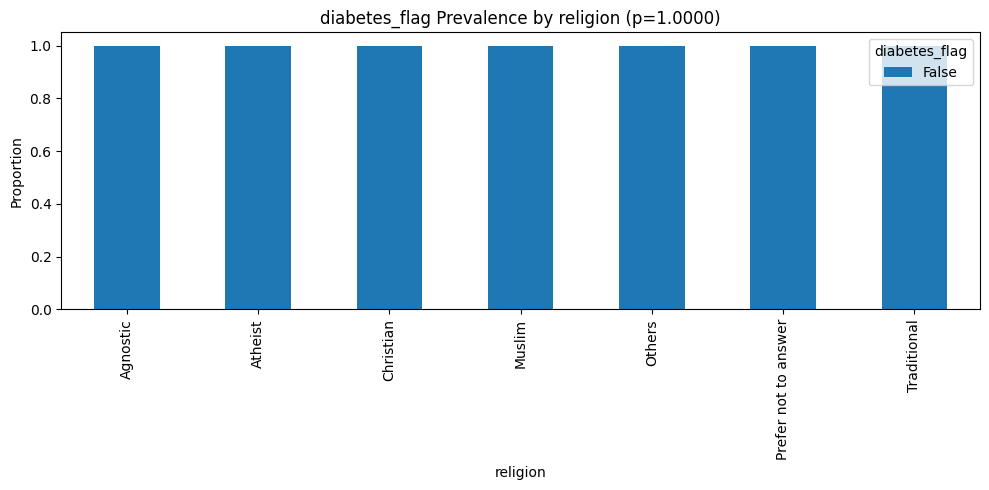

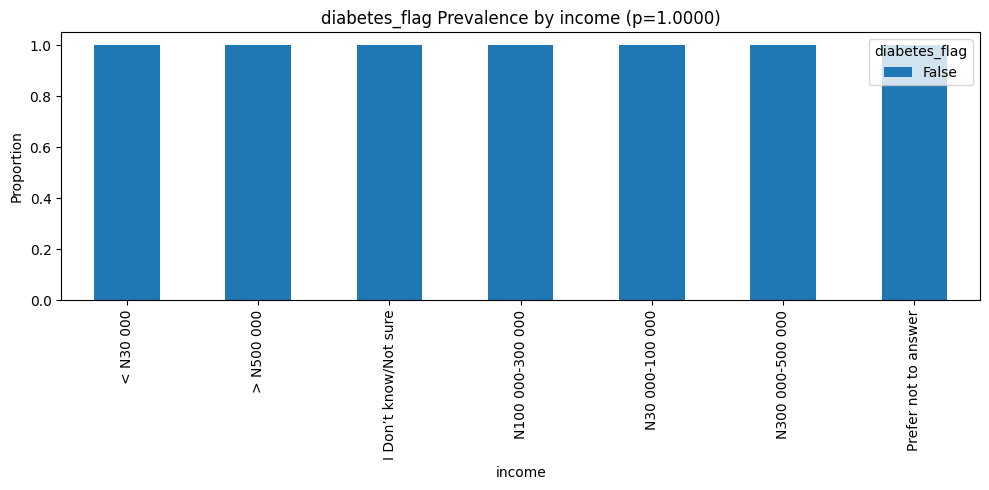

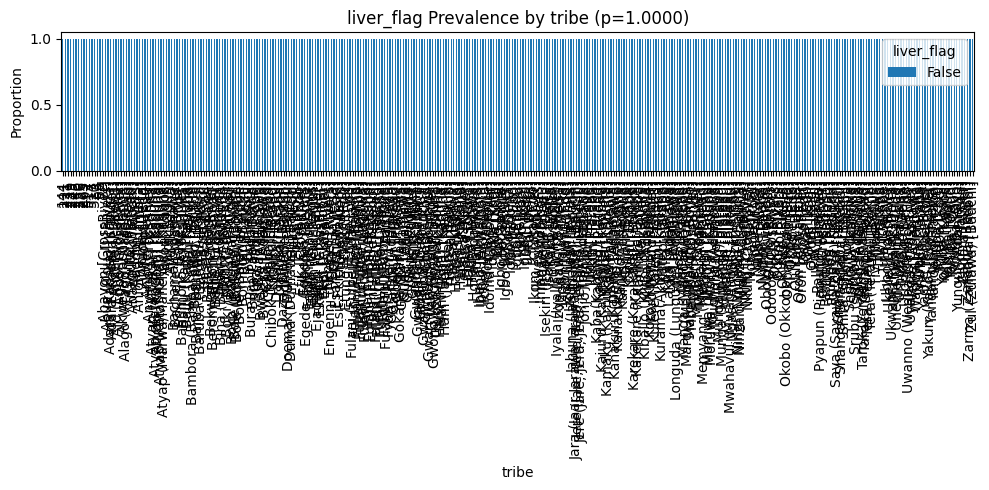

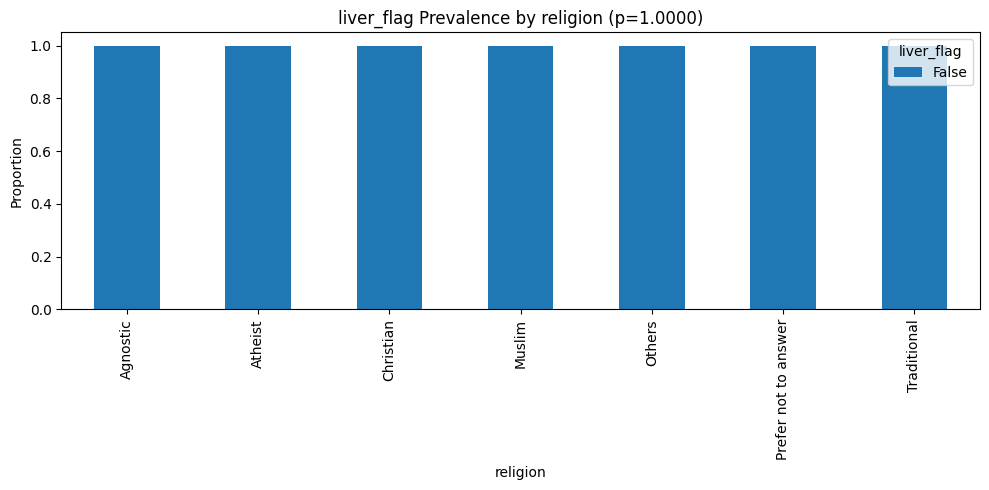

In [ ]:
# sociogenomic_pipeline.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap
from scipy.stats import chi2_contingency
import plotly.express as px

# === Load and Audit Phenotypic Data ===
def load_phenotype_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded data with shape: {df.shape}")
    assert df['pid'].is_unique, "PIDs are not unique!"
    return df

# === Create ICD-10 Based Disease Flags ===
def create_icd10_flags(df):
    df['hypertension_flag'] = df['ICD10_comobidity_1'].str.contains("I10", na=False)
    df['diabetes_flag'] = df['ICD10_comobidity_1'].str.contains("E11", na=False)
    df['liver_flag'] = df['ICD10_comobidity_1'].str.contains("K7", na=False)
    return df

# === Encode Features ===
def encode_features(df, categorical_columns, numeric_columns):
    df = df[categorical_columns + numeric_columns].fillna("Unknown")
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cat = encoder.fit_transform(df[categorical_columns])
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

    # Clean column names for XGBoost compatibility
    clean_names = [col.replace('[', '_').replace(']', '').replace('<', 'lt').replace('>', 'gt') for col in encoded_feature_names]
    X_cat = pd.DataFrame(encoded_cat, columns=clean_names)

    X_num = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
    return X

# === Disease Prevalence Plot ===
def plot_disease_prevalence(df, disease_flags):
    counts = df[disease_flags].sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=counts.values, y=counts.index)
    plt.title("Disease Prevalence")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig("fig_disease_prevalence.png")
    plt.close()

# === Comorbidity Heatmap ===
def plot_comorbidity_heatmap(df, disease_flags):
    mat = df[disease_flags].astype(int).T @ df[disease_flags].astype(int)
    plt.figure(figsize=(6, 5))
    sns.heatmap(mat, annot=True, fmt="d", cmap="Blues")
    plt.title("Comorbidity Co-occurrence")
    plt.tight_layout()
    plt.savefig("fig_comorbidity_heatmap.png")
    plt.close()

# === Sociodemographic Stratification ===
def stratify_and_test(df, disease_flag, group_col):
    cross_tab = pd.crosstab(df[group_col], df[disease_flag])
    chi2, pval, _, _ = chi2_contingency(cross_tab)
    summary = cross_tab.div(cross_tab.sum(1), axis=0)
    summary.plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.title(f"{disease_flag} Prevalence by {group_col} (p={pval:.4f})")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.savefig(f"fig_{group_col}_{disease_flag}.png")
    summary.to_csv(f"summary_{group_col}_{disease_flag}.csv")
    return summary, pval

# === UMAP + KMeans Clustering ===
def run_umap_clustering(X, n_clusters=5):
    # PCA
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X)

    # UMAP
    umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X_pca)

    # KMeans Clustering
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X_umap)
    df_plot = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
    df_plot['Cluster'] = km.labels_

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10")
    plt.title("UMAP Clustering by Phenotypic Features")
    plt.tight_layout()
    plt.savefig("fig_umap_clusters.png")
    plt.close()
    return df_plot

# === XGBoost + SHAP Explanation ===
def run_xgb_shap(X, y, output_prefix="hypertension"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    print(classification_report(y_test, model.predict(X_test)))

    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)

    # Plot SHAP summary
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(f"fig_shap_summary_{output_prefix}.png")
    plt.close()

    # Export SHAP values as CSV
    shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
    shap_mean_abs = shap_df.abs().mean().sort_values(ascending=False).reset_index()
    shap_mean_abs.columns = ['feature', 'mean_abs_shap']
    shap_mean_abs.to_csv(f"shap_values_{output_prefix}.csv", index=False)

def plotly_shap_dashboard(shap_csv_path, top_k=20):
    df_shap = pd.read_csv(shap_csv_path)
    df_shap = df_shap.head(top_k)

    fig = px.bar(
        df_shap[::-1],  # Flip for top-down
        x='mean_abs_shap',
        y='feature',
        orientation='h',
        title=f"Top {top_k} SHAP Feature Importances",
        labels={"mean_abs_shap": "Mean |SHAP|", "feature": "Feature"}
    )
    fig.update_layout(template="plotly_white", height=600)
    fig.write_html("interactive_shap_dashboard.html")
    fig.show()

def group_shap_by_domain(shap_csv_path, domain_mapper):
    df = pd.read_csv(shap_csv_path)

    # Match substrings for each domain
    def assign_domain(feature):
        for domain, substrs in domain_mapper.items():
            if any(s in feature for s in substrs):
                return domain
        return "Other"

    df['domain'] = df['feature'].apply(assign_domain)
    grouped = df.groupby('domain')['mean_abs_shap'].sum().sort_values(ascending=False).reset_index()

    # Plot domain summary
    fig = px.bar(grouped, x='mean_abs_shap', y='domain', orientation='h',
                 title="SHAP Importance by Domain", labels={'mean_abs_shap': 'Sum |SHAP|'})
    fig.update_layout(template="plotly_white", height=500)
    fig.write_html("shap_domain_summary.html")
    fig.show()

    return grouped

# === Main Execution ===
if __name__ == "__main__":
    df = load_phenotype_data("/content/phenotype_with_flags.csv")
    df = create_icd10_flags(df)

    disease_flags = ['hypertension_flag', 'diabetes_flag', 'liver_flag']
    plot_disease_prevalence(df, disease_flags)
    plot_comorbidity_heatmap(df, disease_flags)

    for disease in disease_flags:
        for demo in ['tribe', 'religion', 'income']:
            if demo in df.columns:
                stratify_and_test(df, disease, demo)

    X_meta = encode_features(df, ['tribe', 'religion', 'oil_type'], ['fruit_servings', 'veg_servings', 'BMI'])
    run_umap_clustering(X_meta)

    y_htn = df['hypertension_flag'].astype(int)
    run_xgb_shap(X_meta, y_htn)

    shap_file = "/content/shap_values_hypertension.csv"
    plotly_shap_dashboard(shap_file)

    domain_mapper = {
    "Socioeconomic": ["income", "education", "employment"],
    "Tribe": ["tribe"],
    "Religion": ["religion"],
    "Diet": ["fruit", "veg", "oil", "salt", "protein"],
    "BMI & Health": ["BMI", "exercise", "smoke", "alcohol"]
    }
    group_shap_by_domain(shap_file, domain_mapper)

/tmp/ipython-input-33-797225888.py:20: DtypeWarning: Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loaded data with shape: (38518, 167)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too sma

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9630

    accuracy                           1.00      9630
   macro avg       1.00      1.00      1.00      9630
weighted avg       1.00      1.00      1.00      9630



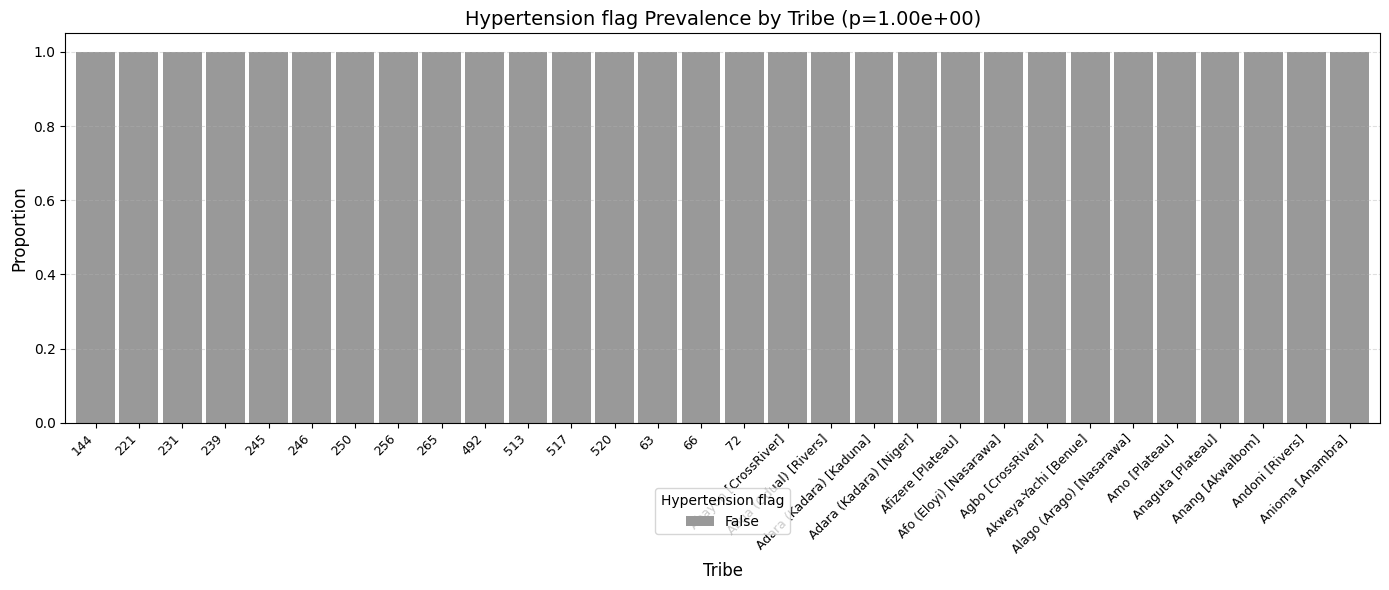

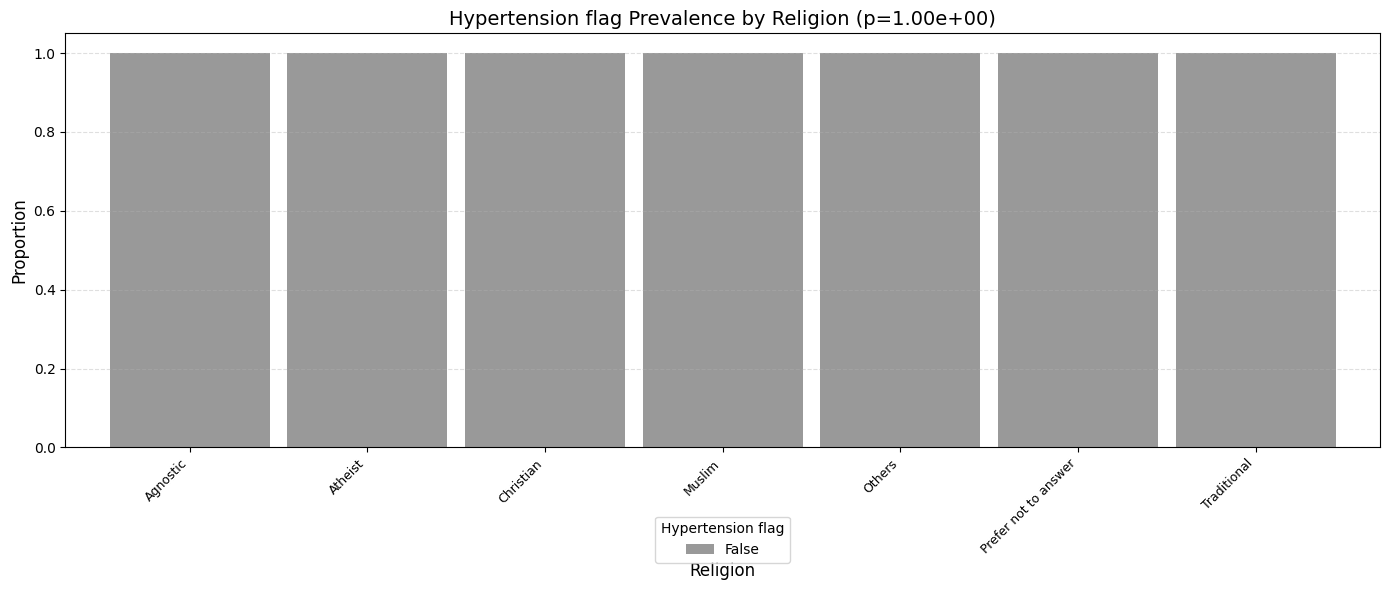

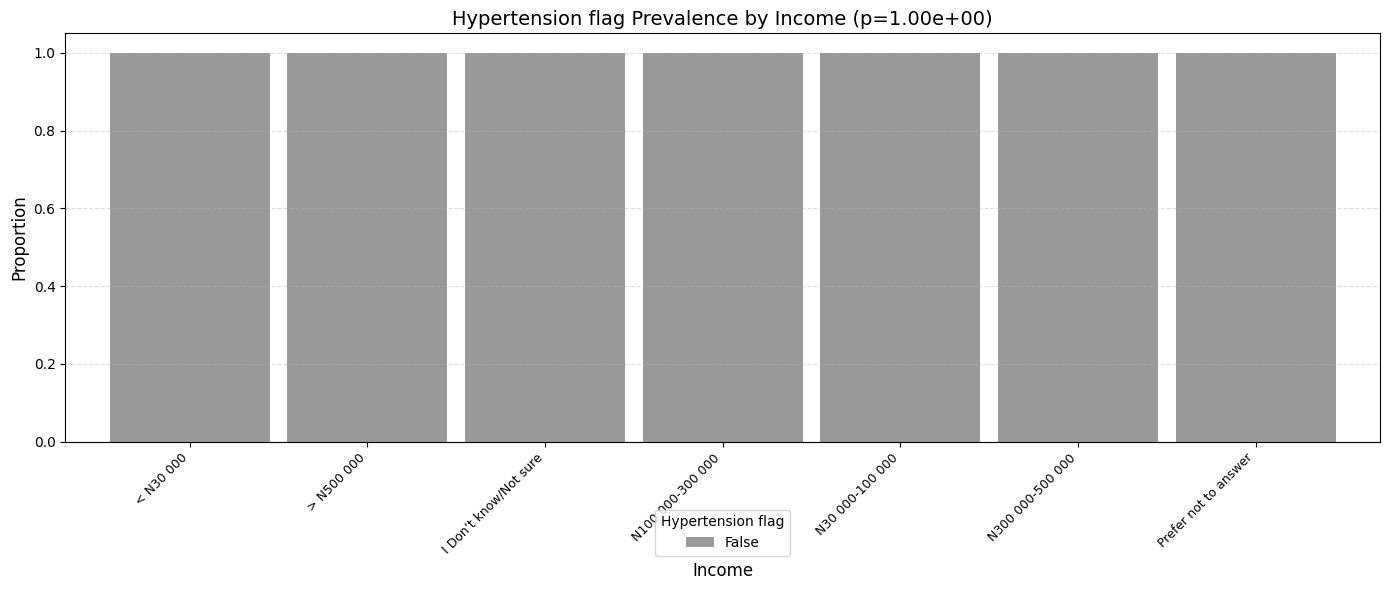

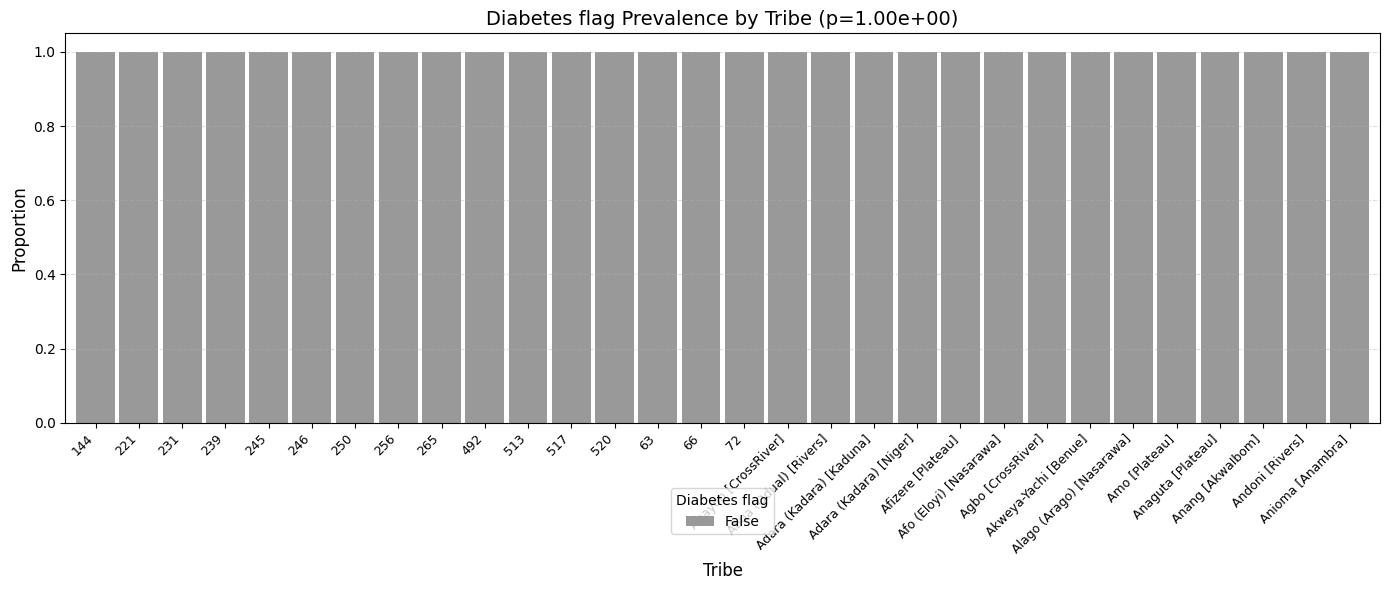

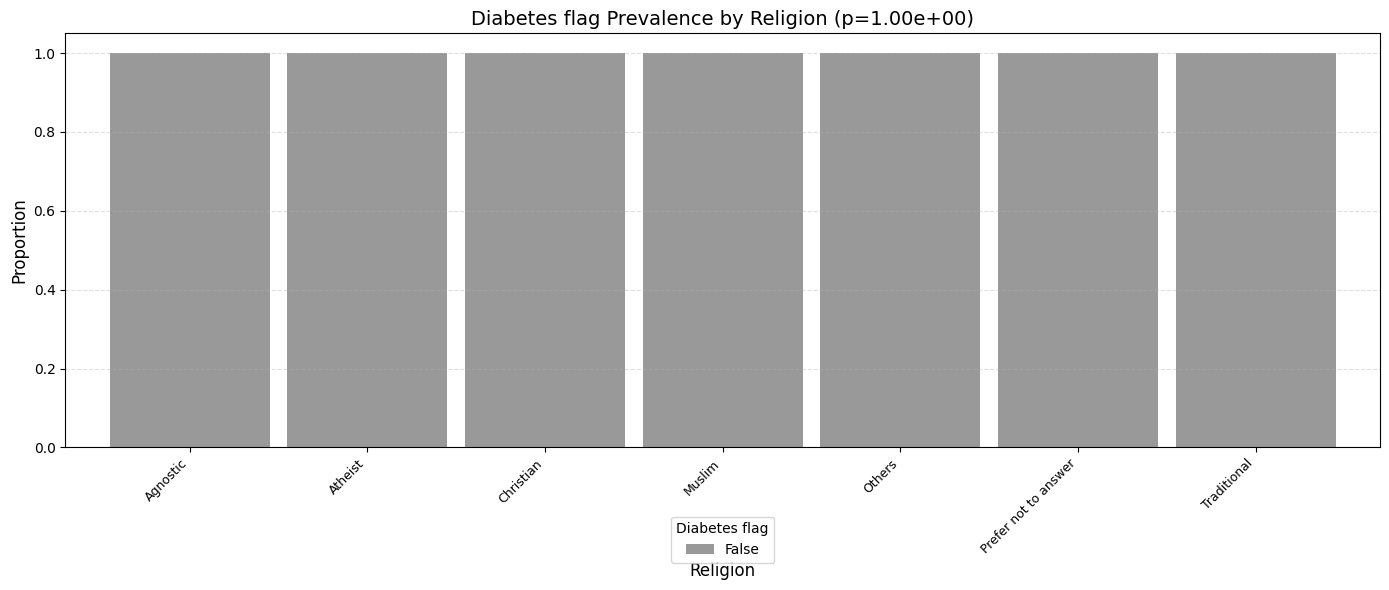

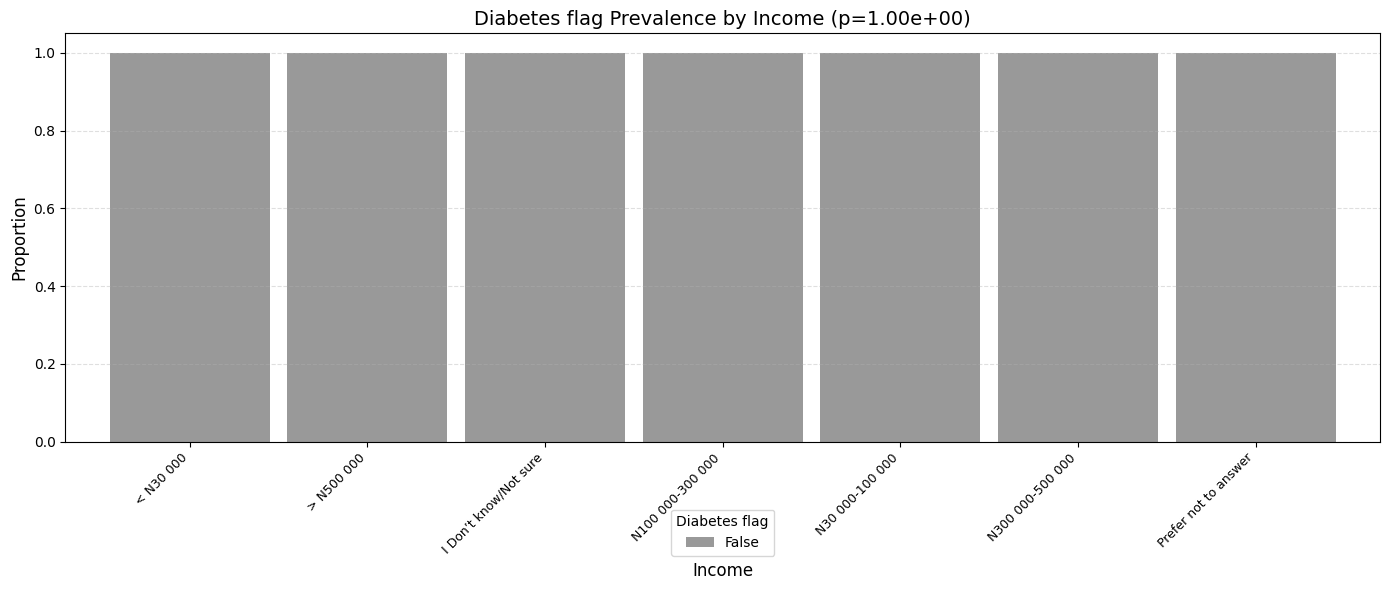

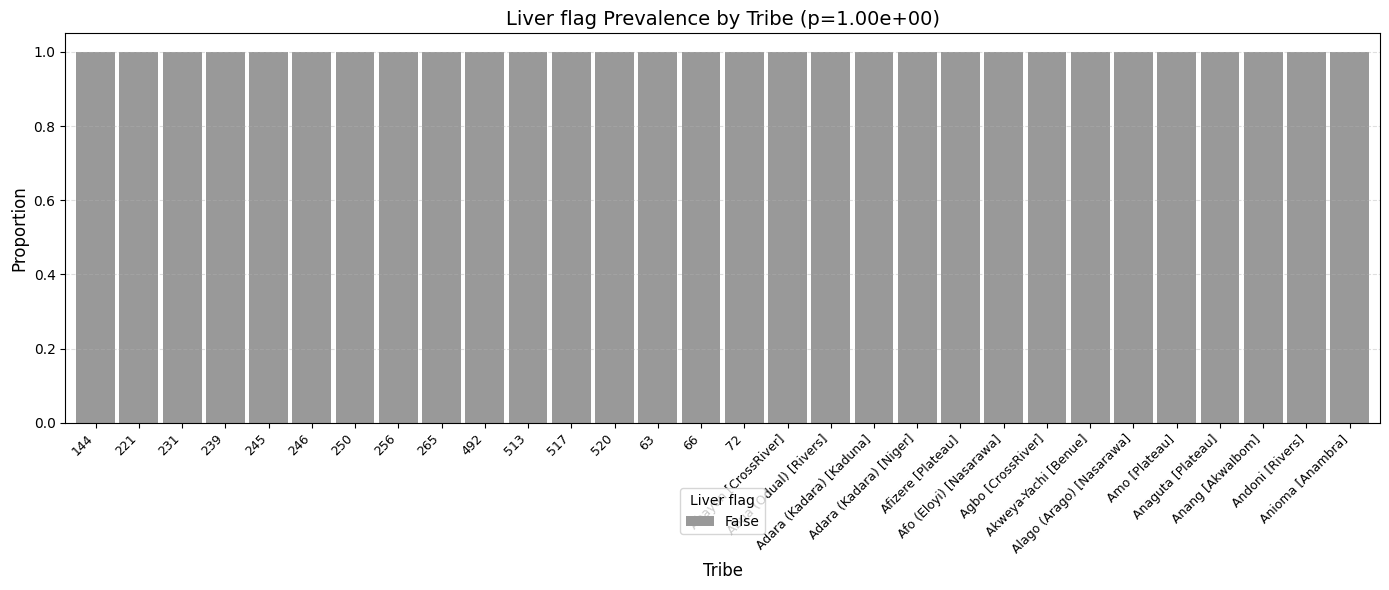

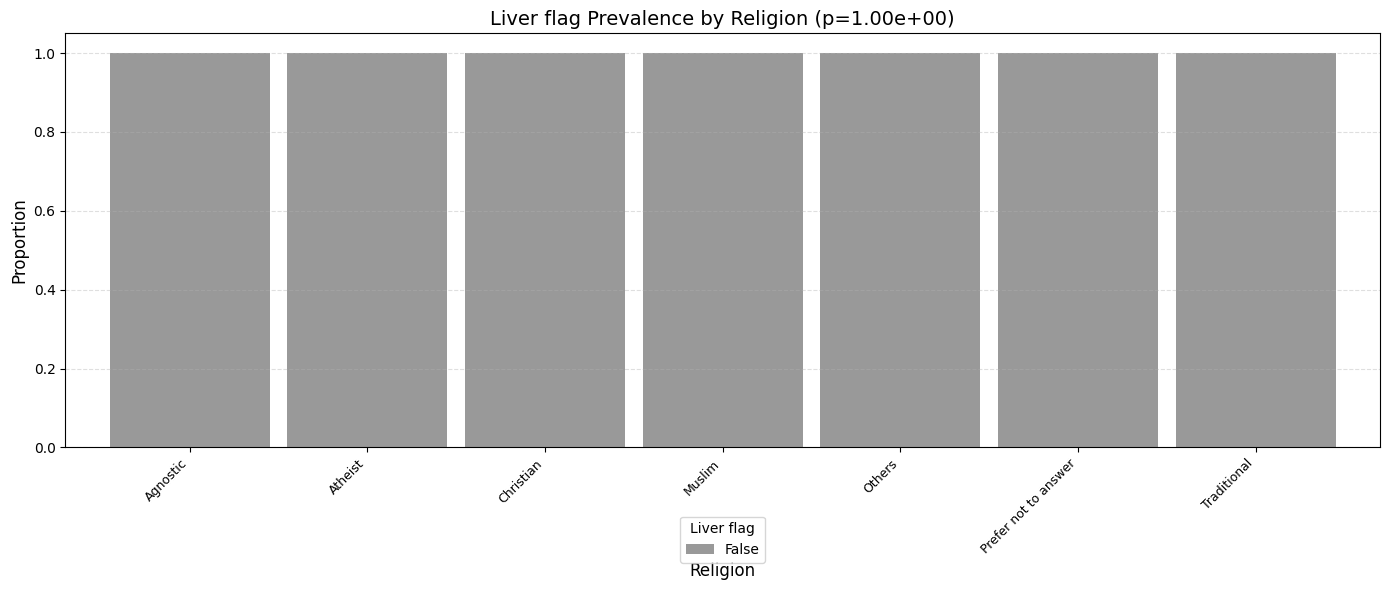

In [ ]:
# sociogenomic_pipeline.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap
from scipy.stats import chi2_contingency
import plotly.express as px

# === Load and Audit Phenotypic Data ===
def load_phenotype_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded data with shape: {df.shape}")
    assert df['pid'].is_unique, "PIDs are not unique!"
    return df

# === Create ICD-10 Based Disease Flags ===
def create_icd10_flags(df):
    df['hypertension_flag'] = df['ICD10_comobidity_1'].str.contains("I10", na=False)
    df['diabetes_flag'] = df['ICD10_comobidity_1'].str.contains("E11", na=False)
    df['liver_flag'] = df['ICD10_comobidity_1'].str.contains("K7", na=False)
    return df

# === Encode Features ===
def encode_features(df, categorical_columns, numeric_columns):
    df = df[categorical_columns + numeric_columns].fillna("Unknown")
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cat = encoder.fit_transform(df[categorical_columns])
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

    # Clean column names for XGBoost compatibility
    clean_names = [col.replace('[', '_').replace(']', '').replace('<', 'lt').replace('>', 'gt') for col in encoded_feature_names]
    X_cat = pd.DataFrame(encoded_cat, columns=clean_names)

    X_num = df[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
    return X

# === Disease Prevalence Plot ===
def plot_disease_prevalence(df, disease_flags):
    counts = df[disease_flags].sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=counts.values, y=counts.index)
    plt.title("Disease Prevalence")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig("fig_disease_prevalence.png")
    plt.close()

# === Comorbidity Heatmap ===
def plot_comorbidity_heatmap(df, disease_flags):
    mat = df[disease_flags].astype(int).T @ df[disease_flags].astype(int)
    plt.figure(figsize=(6, 5))
    sns.heatmap(mat, annot=True, fmt="d", cmap="Blues")
    plt.title("Comorbidity Co-occurrence")
    plt.tight_layout()
    plt.savefig("fig_comorbidity_heatmap.png")
    plt.close()

# === Sociodemographic Stratification ===
def stratify_and_test(df, disease_flag, group_col):
    cross_tab = pd.crosstab(df[group_col], df[disease_flag])

    # Remove rare or homogeneous groups
    cross_tab = cross_tab.loc[(cross_tab.sum(axis=1) > 0)]

    # Chi-squared test
    chi2, pval, _, _ = chi2_contingency(cross_tab)

    # Compute proportions
    summary = cross_tab.div(cross_tab.sum(1), axis=0)

    # Sort and limit top 30
    if True in summary.columns:
        summary = summary.sort_values(by=True, ascending=False).head(30)
    else:
        summary = summary.head(30)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    summary.plot(kind='bar', stacked=True, ax=ax, width=0.9, color=['#1f77b4', '#ff7f0e'] if True in summary.columns else ['#999999'])

    ax.set_title(f"{disease_flag.replace('_', ' ').capitalize()} Prevalence by {group_col.capitalize()} (p={pval:.2e})", fontsize=14)
    ax.set_ylabel("Proportion", fontsize=12)
    ax.set_xlabel(group_col.capitalize(), fontsize=12)
    ax.set_xticklabels(summary.index, rotation=45, ha='right', fontsize=9)
    ax.legend(title=disease_flag.replace('_', ' ').capitalize(), loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()

    # Save
    fig.savefig(f"fig_{group_col}_{disease_flag}.png", dpi=300, bbox_inches='tight')
    summary.to_csv(f"summary_{group_col}_{disease_flag}.csv")

    return summary, pval

# === UMAP + KMeans Clustering ===
def run_umap_clustering(X, n_clusters=5):
    # PCA
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X)

    # UMAP
    umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X_pca)

    # KMeans Clustering
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X_umap)
    df_plot = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
    df_plot['Cluster'] = km.labels_

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10")
    plt.title("UMAP Clustering by Phenotypic Features")
    plt.tight_layout()
    plt.savefig("fig_umap_clusters.png")
    plt.close()
    return df_plot

# === XGBoost + SHAP Explanation ===
def run_xgb_shap(X, y, output_prefix="hypertension"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    print(classification_report(y_test, model.predict(X_test)))

    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)

    # Plot SHAP summary
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(f"fig_shap_summary_{output_prefix}.png")
    plt.close()

    # Export SHAP values as CSV
    shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
    shap_mean_abs = shap_df.abs().mean().sort_values(ascending=False).reset_index()
    shap_mean_abs.columns = ['feature', 'mean_abs_shap']
    shap_mean_abs.to_csv(f"shap_values_{output_prefix}.csv", index=False)

def plotly_shap_dashboard(shap_csv_path, top_k=20):
    df_shap = pd.read_csv(shap_csv_path)
    df_shap = df_shap.head(top_k)

    fig = px.bar(
        df_shap[::-1],  # Flip for top-down
        x='mean_abs_shap',
        y='feature',
        orientation='h',
        title=f"Top {top_k} SHAP Feature Importances",
        labels={"mean_abs_shap": "Mean |SHAP|", "feature": "Feature"}
    )
    fig.update_layout(template="plotly_white", height=600)
    fig.write_html("interactive_shap_dashboard.html")
    fig.show()

def group_shap_by_domain(shap_csv_path, domain_mapper):
    df = pd.read_csv(shap_csv_path)

    # Match substrings for each domain
    def assign_domain(feature):
        for domain, substrs in domain_mapper.items():
            if any(s in feature for s in substrs):
                return domain
        return "Other"

    df['domain'] = df['feature'].apply(assign_domain)
    grouped = df.groupby('domain')['mean_abs_shap'].sum().sort_values(ascending=False).reset_index()

    # Plot domain summary
    fig = px.bar(grouped, x='mean_abs_shap', y='domain', orientation='h',
                 title="SHAP Importance by Domain", labels={'mean_abs_shap': 'Sum |SHAP|'})
    fig.update_layout(template="plotly_white", height=500)
    fig.write_html("shap_domain_summary.html")
    fig.show()

    return grouped

# === Main Execution ===
if __name__ == "__main__":
    df = load_phenotype_data("/content/phenotype_with_flags.csv")
    df = create_icd10_flags(df)

    disease_flags = ['hypertension_flag', 'diabetes_flag', 'liver_flag']
    plot_disease_prevalence(df, disease_flags)
    plot_comorbidity_heatmap(df, disease_flags)

    for disease in disease_flags:
        for demo in ['tribe', 'religion', 'income']:
            if demo in df.columns:
                stratify_and_test(df, disease, demo)

    X_meta = encode_features(df, ['tribe', 'religion', 'oil_type'], ['fruit_servings', 'veg_servings', 'BMI'])
    run_umap_clustering(X_meta)

    y_htn = df['hypertension_flag'].astype(int)
    run_xgb_shap(X_meta, y_htn)

    shap_file = "/content/shap_values_hypertension.csv"
    plotly_shap_dashboard(shap_file)

    domain_mapper = {
    "Socioeconomic": ["income", "education", "employment"],
    "Tribe": ["tribe"],
    "Religion": ["religion"],
    "Diet": ["fruit", "veg", "oil", "salt", "protein"],
    "BMI & Health": ["BMI", "exercise", "smoke", "alcohol"]
    }
    group_shap_by_domain(shap_file, domain_mapper)

#  Sociogenomic Modeling Pipeline

This pipeline performs a comprehensive analysis of sociodemographic and ICD-10-based disease data to uncover chronic disease prevalence, comorbidity, latent clusters, and interpretable feature importances using SHAP and XGBoost.

---

## Load and Audit Phenotypic Data

```python
df = pd.read_csv(file_path)
assert df['pid'].is_unique
```

- Ensures each participant (pid) is uniquely represented.

- Verifies data integrity before further processing.

## Create ICD-10 Based Disease Flags

```python
df['hypertension_flag'] = df['ICD10_comobidity_1'].str.contains("I10", na=False)
```

## Translates ICD-10 codes into interpretable binary flags:

- "I10" → hypertension_flag

- "E11" → diabetes_flag

- "K7" → liver_flag

## Encode Features

```python
OneHotEncoder → Categorical Variables
pd.to_numeric → Continuous Variables
```

## Transforms raw phenotype data into machine-learning-compatible matrices.

- Handles missing values:

   - "Unknown" for categoricals

   - 0 for numerics

- Cleans column names for compatibility with XGBoost.

## Disease Prevalence and Comorbidity Visualization

### Prevalence Barplot
- Generates horizontal barplot of disease prevalence counts.

### Comorbidity Heatmap
- Uses matrix multiplication to calculate disease co-occurrence matrix.

- Plots with heatmap and saves to fig_comorbidity_heatmap.png.

## Sociodemographic Stratification

```python
chi2_contingency(pd.crosstab(group, disease_flag))
```

- Stratifies disease prevalence across sociodemographic groups (tribe, religion, income).

- Performs Chi-squared tests to assess statistical differences.

- Outputs:

   - Stacked barplots

   - CSV summaries

   - p-values for disparities


## UMAP + KMeans for Phenotypic Clustering

```python
PCA → UMAP → KMeans
```

- Reduces phenotype matrix to 2D using UMAP.

- Discovers phenotypic clusters using KMeans.

- Plots UMAP clusters colored by cluster ID.

- Output: fig_umap_clusters.png


## XGBoost Classifier + SHAP Interpretability

### Training

```python
XGBClassifier → Binary Classification (e.g., hypertension)
```

- Evaluates model using classification_report.

### SHAP Values

```python
shap.Explainer → shap.summary_plot
```

- Computes SHAP values on test set to understand feature impact.

- Exports:

   - fig_shap_summary_<disease>.png

   - shap_values_<disease>.csv

## Interactive Plotly Dashboard (Top Features)

```python
plotly.express.bar → SHAP summary dashboard
```

- Visualizes top-k SHAP features interactively.

- Saves and renders interactive_shap_dashboard.html.

## SHAP Domain Aggregation

```python
group_shap_by_domain(shap_file, domain_mapper)
```

- Aggregates SHAP values by domain using substring mapping.

- Example Domains:

  - Socioeconomic, Religion, Tribe, BMI, Diet, etc.

  - Output: shap_domain_summary.html

## Final Pipeline Execution

```python
if __name__ == "__main__":
```

### Executes full pipeline:
- Loads and audits data

- Creates ICD-based disease flags

- Generates prevalence/comorbidity visualizations

- Performs stratified group testing

- Runs UMAP clustering

- Trains and explains XGBoost disease classifier

- Builds interactive SHAP dashboards

- Summarizes SHAP values by domain

## Relevance to Project
This pipeline powers the AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations, supporting:

- Epidemiological profiling

- Gene–environment interaction modeling

- Equity-focused public health strategies

- Explainable ML for phenotypic features

All results (CSV, PNG, HTML) are auto-saved and ready for integration into dashboards, reports, and publications.




### Shap Dash Dashboard App

In [ ]:
!pip install dash plotly pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.7 MB/s eta 0:00:00


In [ ]:
import shutil

# Define source file and target directory
src_file = "/content/shap_values_hypertension.csv"
target_dir = "/content/shap_outputs/"

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Move the file into the target directory
shutil.move(src_file, os.path.join(target_dir, os.path.basename(src_file)))

print(f"Moved {src_file} to {target_dir}")

In [ ]:
# app_shap_dashboard.py
import dash
from dash import dcc, html, Input, Output, State, dash_table
import pandas as pd
import plotly.express as px
import os

# === Constants ===
SHAP_DIR = "/content/shap_outputs/"
PHENO_FILE = "/content/phenotype_with_flags.csv"
TOP_K_DEFAULT = 15

# === Load phenotype metadata (for overlays) ===
df_pheno = pd.read_csv(PHENO_FILE)
overlay_fields = ['age', 'income', 'tribe']

# === Load SHAP Files ===
shap_files = [f for f in os.listdir(SHAP_DIR) if f.endswith(".csv")]

# === Start App ===
app = dash.Dash(__name__, suppress_callback_exceptions=True)
app.title = "SHAP Dashboard"

app.layout = html.Div([
    html.H2(" SHAP Feature Explorer Dashboard"),

    dcc.Tabs([
        dcc.Tab(label="SHAP Barplot", children=[
            html.Div([
                html.Label("Select SHAP File / Disease:"),
                dcc.Dropdown(
                    id='shap-file-dropdown',
                    options=[{'label': f, 'value': f} for f in shap_files],
                    value=shap_files[0]
                ),

                html.Label("Top K Features:"),
                dcc.Slider(id='top-k-slider', min=5, max=50, step=1, value=TOP_K_DEFAULT,
                           marks={i: str(i) for i in range(5, 55, 5)}),

                html.Label("Filter by keyword:"),
                dcc.Input(id='feature-keyword', type='text', placeholder="e.g. veg, BMI, religion"),

                dcc.Graph(id='shap-barplot'),
                html.Button("Export CSV", id='export-button'),
                dcc.Download(id='shap-download')
            ])
        ]),

        dcc.Tab(label="UMAP / Clustering", children=[
            html.Div([
                html.Label("Select SHAP File for Clustering:"),
                dcc.Dropdown(
                    id='shap-cluster-dropdown',
                    options=[{'label': f, 'value': f} for f in shap_files],
                    value=shap_files[0]
                ),
                html.Label("Overlay phenotype field:"),
                dcc.Dropdown(
                    id='overlay-dropdown',
                    options=[{'label': col, 'value': col} for col in overlay_fields],
                    value=overlay_fields[0]
                ),
                dcc.Graph(id='umap-scatter')
            ])
        ])
    ])
])

# === Callbacks ===
@app.callback(
    Output('shap-barplot', 'figure'),
    Input('shap-file-dropdown', 'value'),
    Input('top-k-slider', 'value'),
    Input('feature-keyword', 'value')
)
def update_barplot(shap_file, top_k, keyword):
    df = pd.read_csv(os.path.join(SHAP_DIR, shap_file))
    df = df.sort_values('importance', ascending=False)

    if keyword:
        df = df[df['feature'].str.contains(keyword, case=False, na=False)]

    fig = px.bar(df.head(top_k), x='importance', y='feature', orientation='h', color='domain')
    fig.update_layout(title=f"Top {top_k} SHAP Features")
    return fig

@app.callback(
    Output('shap-download', 'data'),
    Input('export-button', 'n_clicks'),
    State('shap-file-dropdown', 'value'),
    prevent_initial_call=True
)
def export_filtered_shap(n, shap_file):
    df = pd.read_csv(os.path.join(SHAP_DIR, shap_file))
    return dcc.send_data_frame(df.to_csv, f"filtered_{shap_file}")

@app.callback(
    Output('umap-scatter', 'figure'),
    Input('shap-cluster-dropdown', 'value'),
    Input('overlay-dropdown', 'value')
)
def update_umap(shap_file, overlay):
    from sklearn.manifold import TSNE
    df = pd.read_csv(os.path.join(SHAP_DIR, shap_file))
    df_vals = df.drop(columns=['feature', 'importance', 'domain'], errors='ignore')
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embedding = tsne.fit_transform(df_vals.T)
    coords = pd.DataFrame(embedding, columns=["TSNE1", "TSNE2"])
    coords[overlay] = df_pheno[overlay].values[:coords.shape[0]]
    fig = px.scatter(coords, x="TSNE1", y="TSNE2", color=overlay, title="t-SNE on SHAP Samples")
    return fig

# === Launch App ===
if __name__ == '__main__':
    app.run(debug=True)


/tmp/ipython-input-81-4052289165.py:14: DtypeWarning:

Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.



<IPython.core.display.Javascript object>

#  SHAP Feature Explorer Dashboard

An interactive, web-based **Dash app** for exploring SHAP values from phenotype-driven disease models. This app supports **barplot visualization**, **keyword filtering**, **dimensionality reduction (t-SNE)**, and **phenotype overlays** for analyzing the role of sociodemographic factors in chronic disease prediction.

---

##  Step 1: Setup and File Management

```python
shutil.move(src_file, os.path.join(target_dir, ...))
```

- Moves a SHAP CSV output (e.g., shap_values_hypertension.csv) into a centralized folder (/content/shap_outputs/) for app access.

- Ensures files are structured and discoverable for dropdown selectors.

## App Overview

```python
dash.Dash(...)
```

- Built using Dash and Plotly Express.

- Organized into two tabs:

  - SHAP Barplot

  - UMAP / Clustering (via t-SNE)

## Tab 1: SHAP Barplot
### Inputs:
- SHAP File Selector – Choose disease-specific SHAP results

- Top-K Slider – Select number of top features (5–50)

- Keyword Filter – Filter features using keyword search (e.g., BMI, veg, religion)

### Outputs:
- Barplot of SHAP Features

- Ranks features by importance (mean |SHAP|)

- Color-coded by domain (e.g., Diet, Religion, BMI)

- Download Button – Export filtered results as CSV  


## Backend Logic:

```python
df = df.sort_values('importance', ascending=False)
df = df[df['feature'].str.contains(keyword)]
```

## Tab 2: UMAP / Clustering Visualization
### Inputs:
- SHAP File Selector

- Phenotype Overlay Selector (e.g., age, tribe, income)

### Outputs:
- 2D Scatter Plot via t-SNE over transposed SHAP matrix

- Each point = individual/sample

- Color = selected phenotype metadata

- Allows clustering exploration based on SHAP embeddings

## Backend Logic:

```python
from sklearn.manifold import TSNE
embedding = tsne.fit_transform(df_vals.T)
```

## Technical Highlights
### Backend:

- Reads CSVs from shap_outputs/

- Filters and transforms SHAP values on-the-fly

### Frontend:

- Powered by Dash HTML components, tabs, dropdowns, and graph widgets

- Export Functionality:

- SHAP tables can be downloaded for external reporting or analysis


## Relevance to Project
This dashboard is a key component of:

“AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations”

- Enables visual and interactive exploration of how features (e.g., religion, diet, tribe) contribute to disease predictions
- Provides decision-makers and researchers with interpretable, quantifiable, and exportable results
- Bridges the gap between complex SHAP modeling and actionable insights in public health and genomic equity

### Socigenomic Dashboard App

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import umap
from sklearn.cluster import KMeans

st.set_page_config(page_title="Sociogenomic Risk Explorer", layout="wide")

st.title(" Sociogenomic Risk Explorer for Nigerian Populations")
st.markdown("This tool predicts chronic disease risks based on tribe, lifestyle, and social factors. Genotype features will be supported in future versions.")

# === Upload Section ===
st.sidebar.header(" Upload Your Data")
uploaded_file = st.sidebar.file_uploader("Upload processed phenotype data (CSV)", type=["csv"])

# === Load Model ===
@st.cache_resource
def load_model():
    try:
        model = joblib.load("saved_model.pkl")
        return model
    except:
        st.warning("Model not found. Train and save a model as 'saved_model.pkl'")
        return None

model = load_model()

# === Data Display ===
if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.write("###  Uploaded Data", df.head())

    if model:
        # Extract features
        X = df.select_dtypes(include=[np.number])

        # Predict
        preds = model.predict_proba(X)[:, 1]
        df["RiskScore"] = preds

        st.write("###  Predicted Risk Scores", pd.DataFrame({"Risk Score": preds}))

        # SHAP Explanation
        st.subheader(" SHAP Feature Importance")
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        fig, ax = plt.subplots()
        shap.summary_plot(shap_values, X, show=False)
        st.pyplot(fig)

        # Tribe-based summary
        if "tribe" in df.columns:
            st.subheader(" Tribe-level Average Risk")
            tribe_summary = df.groupby("tribe")["RiskScore"].mean().reset_index().sort_values("RiskScore", ascending=False)
            st.dataframe(tribe_summary)

        # Clustering + UMAP visualization
        st.subheader(" Risk Clusters with UMAP + KMeans")
        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(X)

        kmeans = KMeans(n_clusters=5, random_state=42)
        clusters = kmeans.fit_predict(X)

        umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
        umap_df["Cluster"] = clusters
        umap_df["Risk"] = preds

        fig2, ax2 = plt.subplots()
        sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster", size="Risk", palette="tab10", ax=ax2)
        plt.title("UMAP Risk Clusters")
        st.pyplot(fig2)

        st.markdown("---")
        st.markdown(" Built with SHAP, UMAP, and XGBoost — extendable to genomics soon!")


2025-06-30 19:53:19.715 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 19:53:19.718 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 19:53:20.065 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-30 19:53:20.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 19:53:20.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 19:53:20.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 19:53:20.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

# Sociogenomic Risk Explorer for Nigerian Populations (`Streamlit App`)

A powerful, interactive **Streamlit dashboard** designed to visualize and predict chronic disease risks based on **sociodemographic and lifestyle factors** such as **tribe, diet, and income**. The app also provides **SHAP-based interpretability** and **UMAP clustering** to enhance transparency and insight.

---

## Overview

- **Framework**: Streamlit (`st`)
- **Model**: XGBoost model loaded from `saved_model.pkl`
- **Input**: Uploaded phenotype CSV
- **Output**:
  - Individual risk scores
  - SHAP feature importance
  - Tribe-level risk summaries
  - UMAP-based clustering plots

---

## Step-by-Step Features

### App Header and Description

```python
st.title("Sociogenomic Risk Explorer")
```

- Sets the app's page title and layout.

- Introduces the goal of the tool: risk prediction from sociodemographic variables.

## Sidebar – Data Upload

```python
uploaded_file = st.sidebar.file_uploader(...)
```

- Allows users to upload a .csv file with cleaned phenotype features.

- Automatically processes and visualizes the data if valid.

## Model Loading

```python
model = joblib.load("saved_model.pkl")
```

- Loads a pretrained XGBoost model from disk using joblib.

- Caches the model to speed up app interactions.

## Data Display and Prediction

```python
df["RiskScore"] = model.predict_proba(X)[:, 1]
```

- Automatically extracts numeric features from uploaded data.

- Predicts chronic disease risk per individual.

- Appends RiskScore to the dataset for downstream analysis.

## SHAP Feature Importance

```python
shap.summary_plot(shap_values, X, show=False)
```

- Uses shap.Explainer to interpret model predictions.

- Displays a SHAP summary plot of the top features contributing to disease risk.

- Helps users understand what drives prediction (e.g., BMI, tribe, oil_type).

## Tribe-level Risk Summary

```python
df.groupby("tribe")["RiskScore"].mean()
```

- Aggregates individual risk scores by tribal group.

- Useful for highlighting disparities in disease burden across ethnic subgroups.

## UMAP + KMeans Clustering

```python
embedding = umap.UMAP(...).fit_transform(X)
clusters = KMeans(...).fit_predict(X)
```

- Projects high-dimensional feature space into 2D using UMAP.

- Clusters individuals using KMeans based on their profile and predicted risk.

- Plots clusters using Seaborn with Risk as marker size and Cluster as color.


## Relevance to Project
This interactive dashboard directly contributes to the goals of:

“AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations.”

- Translates sociodemographic profiles into actionable disease risk predictions.

- Supports policy-relevant subgroup analysis (e.g., by tribe).

- Will support genomic features in future (PRS, SNPs).

- Built using transparent, interpretable ML (XGBoost + SHAP + UMAP).

## Future Extensions
- Integration with genotype data

- Auto-upload of saved SHAP outputs

- REST API + database backends for research use

- Support for additional chronic diseases

## Technologies Used
- Streamlit – Interactive web dashboard

- SHAP – Model explanation and feature attribution

- UMAP – Dimensionality reduction for visualization

- XGBoost – Core model for classification

- KMeans – Unsupervised clustering of risk profiles

### ICD1O Flag Generator

In [ ]:
import pandas as pd
import json

def generate_disease_flags(df, icd_col, mapper_path="/content/sample_data/icd10_flag_mapper.json"):
    '''
    Adds binary disease flag columns to the dataframe using ICD-10 codes.

    Parameters:
    - df: input phenotype dataframe
    - icd_col: name of the column containing ICD-10 codes
    - mapper_path: path to JSON dictionary mapping ICD codes to disease names

    Returns:
    - df with new binary columns like 'has_Hypertension', 'has_Diabetes', etc.
    '''
    with open(mapper_path, 'r') as f:
        icd_map = json.load(f)

    # Initialize all new flag columns to False
    for disease in icd_map.values():
        col_name = f"has_{disease.replace(' ', '_')}"
        df[col_name] = False

    # Set flags based on ICD-10 prefix matches
    for code, disease in icd_map.items():
        col_name = f"has_{disease.replace(' ', '_')}"
        df[col_name] = df[icd_col].astype(str).str.startswith(code) | df[col_name]

    return df

def main():
    input_csv = "/content/phenotype_survey_cleaned.csv"
    icd_col = "ICD10_comobidity_1"
    df = pd.read_csv(input_csv)
    df = generate_disease_flags(df, icd_col)
    df.to_csv("phenotype_with_flags.csv", index=False)
    print(" Disease flags added and saved to phenotype_with_flags.csv")

if __name__ == "__main__":
    main()


/tmp/ipython-input-86-3808815870.py:34: DtypeWarning:

Columns (39,125,128) have mixed types. Specify dtype option on import or set low_memory=False.



 Disease flags added and saved to phenotype_with_flags.csv


#  ICD-10 Disease Flag Generator:

This script augments a phenotype dataset with **binary disease indicator columns** using ICD-10 diagnosis codes. It allows downstream tasks (e.g., modeling, stratification, visualization) to reference clear, analyzable flags like `has_Hypertension`, `has_Diabetes`, etc.

---

##  Purpose

To convert **raw ICD-10 diagnosis codes** into **interpretable binary variables**, enabling:
- Exploratory data analysis
- Disease prevalence estimates
- Model training and SHAP interpretation

---

##  Function: `generate_disease_flags`

```python
def generate_disease_flags(df, icd_col, mapper_path):
```

## Inputs:
- df: Pandas DataFrame containing patient phenotype data

- icd_col: Column name holding ICD-10 diagnosis codes (e.g., "ICD10_comobidity_1")

- mapper_path: Path to a JSON file mapping ICD-10 code prefixes to disease labels

## Example mapper_path JSON:

```python
{
  "I10": "Hypertension",
  "E11": "Diabetes",
  "K70": "Liver Disease"
}
```

## Output:
- Returns the same DataFrame df with new columns added like:

  - has_Hypertension

  - has_Diabetes

  - has_Liver_Disease

Each is a boolean column based on whether the ICD-10 code in icd_col starts with the prefix from the JSON map.

## Key Logic
### Initialize flag columns to False:

```python
df[col_name] = False
```

### Set flags using string prefix matching:

```python
df[col_name] = df[icd_col].astype(str).str.startswith(code) | df[col_name]
```

This approach ensures multiple diagnosis codes (e.g., I10, I11) can be correctly handled without overwriting previous matches.

## Main Pipeline: main()

```python
def main():
    df = pd.read_csv("/content/phenotype_survey_cleaned.csv")
    df = generate_disease_flags(df, icd_col="ICD10_comobidity_1")
    df.to_csv("phenotype_with_flags.csv")
```

- Loads a cleaned phenotype CSV

- Applies the ICD-to-flag mapping

- Saves the output to phenotype_with_flags.csv

### Output
- After running:

- A new CSV file named phenotype_with_flags.csv will be created

- Contains original phenotype features plus binary disease flags

## Relevance to Project
This utility is essential for the project:
“AI-Driven Discovery of Polygenic–Sociodemographic Interactions Affecting Health Inequities in Nigerian Populations”

### Enables:

- Structured modeling input

- Clear disease-specific analysis

- Stratification by tribe, religion, income, etc.

- Consistent phenotype definition across tools